In [1569]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import networkx as nx
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2


! if [ ! -d /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis/ ]; then mkdir /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis; fi

os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/dhcr24_analysis/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [1570]:
def quantileNormalize(vals1, vals2):
    '''
    input: two scalar arrays
    output: two quantile normalized scalar arrays
    '''
    vals1 = np.array(vals1)
    vals2 = np.array(vals2)
    
    ranks_1 = scipy.stats.rankdata(vals1, method = 'dense')
    ranks_2 = scipy.stats.rankdata(vals2, method = 'dense')
    
    sorted_vals_1 = sorted(vals1)
    sorted_vals_2 = sorted(vals2)
    means = np.mean([sorted_vals_1,sorted_vals_2], axis=0)
    
    rank_mean_dict = dict(zip(sorted(ranks_1), sorted(means)))
    normalized_vals_1 = np.array([rank_mean_dict[x] for x in ranks_1])
    normalized_vals_2 = np.array([rank_mean_dict[x] for x in ranks_2])
    return normalized_vals_1, normalized_vals_2

def calcMAD(vals):
    '''
    inputs: an array of scalars
    output: median absolute deviation of input array
    Calculates MAD, the median of the absolute values 
    of the differences between the data values and the 
    overall median of the data set
    '''
    overall_median = np.median(vals)
    absolute_distances = [abs(x-overall_median) for x in vals]
    mad = np.median(absolute_distances)
    return mad

def medNormalize(vals1, vals2):
    med_1 = np.median(vals1)
    med_2 = np.median(vals2)
    if med_1 > med_2:
        corrected_vals1 = vals1
        corrected_vals2 = vals2 + (med-1 - med_2)
    else:
        corrected_vals1 = vehicle_vals+ (med_2 - med_1)
        corrected_vals2 = treated_vals
    return corrected_vals1, corrected_vals2

## Copy Files

In [1571]:
%%bash
# get differentially expressed gene files
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/homer_diffExpresion.tsv ./human_diffExpression.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/homer_diffExpresion.tsv ./mouse_diffExpression.tsv

# get IDR scores
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_Des_idrUnion.tsv ./mouse_des_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_DMHCA_idrUnion.tsv ./mouse_dmhca_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/idr/ThioMac_T09_idrUnion.tsv ./mouse_t09_idrUnion.tsv

cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_Des_idrUnion.tsv ./human_des_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_DMHCA_idrUnion.tsv ./human_dhmca_idrUnion.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/idr/Human_T09_idrUnion.tsv ./human_t09_idrUnion.tsv

# get rpkm values
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/rpkm.tsv ./mouse_rpkm.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/rpkm.tsv ./human_rpkm.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_mouseMacrophage_analysis/raw.tsv ./mouse_reads.tsv
cp /gpfs/data01/glasslab/home/jtao/analysis/dhcr24_humanMacrophage_analysis/raw.tsv ./human_reads.tsv


## Identify mouse human homologs

In [275]:
# download homolog file
! wget ftp://ftp.informatics.jax.org/pub/reports/HOM_MouseHumanSequence.rpt

--2016-08-01 09:56:57--  ftp://ftp.informatics.jax.org/pub/reports/HOM_MouseHumanSequence.rpt
           => ‘HOM_MouseHumanSequence.rpt’
Resolving ftp.informatics.jax.org (ftp.informatics.jax.org)... 64.147.54.33
Connecting to ftp.informatics.jax.org (ftp.informatics.jax.org)|64.147.54.33|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/reports ... done.
==> SIZE HOM_MouseHumanSequence.rpt ... 7596152
==> PASV ... done.    ==> RETR HOM_MouseHumanSequence.rpt ... done.
Length: 7596152 (7.2M) (unauthoritative)

100%[======================================>] 7,596,152   4.04MB/s   in 1.8s   

2016-08-01 09:57:00 (4.04 MB/s) - ‘HOM_MouseHumanSequence.rpt’ saved [7596152]



In [1572]:
homolog_frame = pd.read_csv('./HOM_MouseHumanSequence.rpt', sep='\t')

In [1573]:
mouse_homolog_genes = set()
human_homolog_genes = set()
current_frame = homolog_frame[homolog_frame['Common Organism Name'] == 'mouse, laboratory']

homoloGeneID_mouseGene_dict = dict(zip(current_frame['HomoloGene ID'].values, 
                                current_frame['Symbol'].values))

current_frame = homolog_frame[homolog_frame['Common Organism Name'] == 'human']

homoloGeneID_humanGene_dict = dict(zip(current_frame['HomoloGene ID'].values, 
                                current_frame['Symbol'].values))

mouse_human_homologMapping = {}
human_mouse_homologMapping = {}
count = 0
for key in homoloGeneID_humanGene_dict:
    if key in homoloGeneID_humanGene_dict and key in homoloGeneID_mouseGene_dict:
        mouse_gene = homoloGeneID_mouseGene_dict[key].upper()
        human_gene = homoloGeneID_humanGene_dict[key].upper()

        mouse_human_homologMapping[mouse_gene] = human_gene
        human_mouse_homologMapping[human_gene] = mouse_gene
        
        mouse_homolog_genes.add(mouse_gene)
        human_homolog_genes.add(human_gene)
    else:
        count+=1
print(count)

1951


### Read in RNA-seq Data

In [1574]:
# read in human rpkm values
rpkm_human_frame = pd.read_csv('./human_rpkm.tsv', sep='\t')
columns = rpkm_human_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
        tokens = columns[i].split('_')
        columns[i] = tokens[2] + '_' + tokens[0].split('-')[-1]
rpkm_human_frame.columns = columns    
rpkm_human_frame['gene'] = [x.split("|")[0].upper() for x in rpkm_human_frame['Annotation/Divergence']]
columns = list(rpkm_human_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_human_frame = rpkm_human_frame[columns]
rpkm_human_frame.index = rpkm_human_frame['gene'].values

# read in mouse rpkm values
rpkm_mouse_frame = pd.read_csv('./mouse_rpkm.tsv', sep='\t')
columns = rpkm_mouse_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
        tokens =  columns[i].split('_')[2].split('-')
        columns[i] = tokens[0] + '_' + tokens[1]
        
rpkm_mouse_frame.columns = columns    
rpkm_mouse_frame['gene'] = [x.split("|")[0].upper() for x in rpkm_mouse_frame['Annotation/Divergence']]
columns = list(rpkm_mouse_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_mouse_frame = rpkm_mouse_frame[columns]
rpkm_mouse_frame = rpkm_mouse_frame[rpkm_mouse_frame['gene'].isin(mouse_homolog_genes)]
rpkm_mouse_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping
                            else x
                            for x in rpkm_mouse_frame['gene'].values]
rpkm_mouse_frame.index = rpkm_mouse_frame['gene'].values

In [1575]:
reads_human_frame = pd.read_csv('./human_reads.tsv', sep='\t')
columns = reads_human_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
        tokens = columns[i].split('_')
        columns[i] = tokens[2] + '_' + tokens[0].split('-')[-1]
reads_human_frame.columns = columns    
reads_human_frame['gene'] = [x.split("|")[0].upper() for x in reads_human_frame['Annotation/Divergence']]
columns = list(reads_human_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
reads_human_frame = reads_human_frame[columns]
reads_human_frame.index = reads_human_frame['gene'].values

reads_mouse_frame = pd.read_csv('./mouse_reads.tsv', sep='\t')
columns = reads_mouse_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
        tokens =  columns[i].split('_')[2].split('-')
        columns[i] = tokens[0] + '_' + tokens[1]
reads_mouse_frame.columns = columns    
reads_mouse_frame['gene'] = [x.split("|")[0].upper() for x in reads_mouse_frame['Annotation/Divergence']]
columns = list(reads_mouse_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
reads_mouse_frame = reads_mouse_frame[columns]
reads_mouse_frame = reads_mouse_frame[reads_mouse_frame['gene'].isin(mouse_homolog_genes)]
reads_mouse_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping
                            else x
                            for x in reads_mouse_frame['gene'].values]
reads_mouse_frame.index = reads_mouse_frame['gene'].values

In [1576]:
### filter away genes that are expressed at less than 4 rpkm
rpkm_threshold = 4
# reads_threshold = 16
rpkm_human_frame = rpkm_human_frame[rpkm_human_frame.ix[:,9:].max(axis=1) >= rpkm_threshold]
rpkm_mouse_frame = rpkm_mouse_frame[rpkm_mouse_frame.ix[:,9:].max(axis=1) >= rpkm_threshold]

# reads_human_frame = reads_human_frame[reads_human_frame.ix[:,9:].max(axis=1) >= reads_threshold]
# reads_mouse_frame = reads_mouse_frame[reads_mouse_frame.ix[:,9:].max(axis=1) >= reads_threshold]

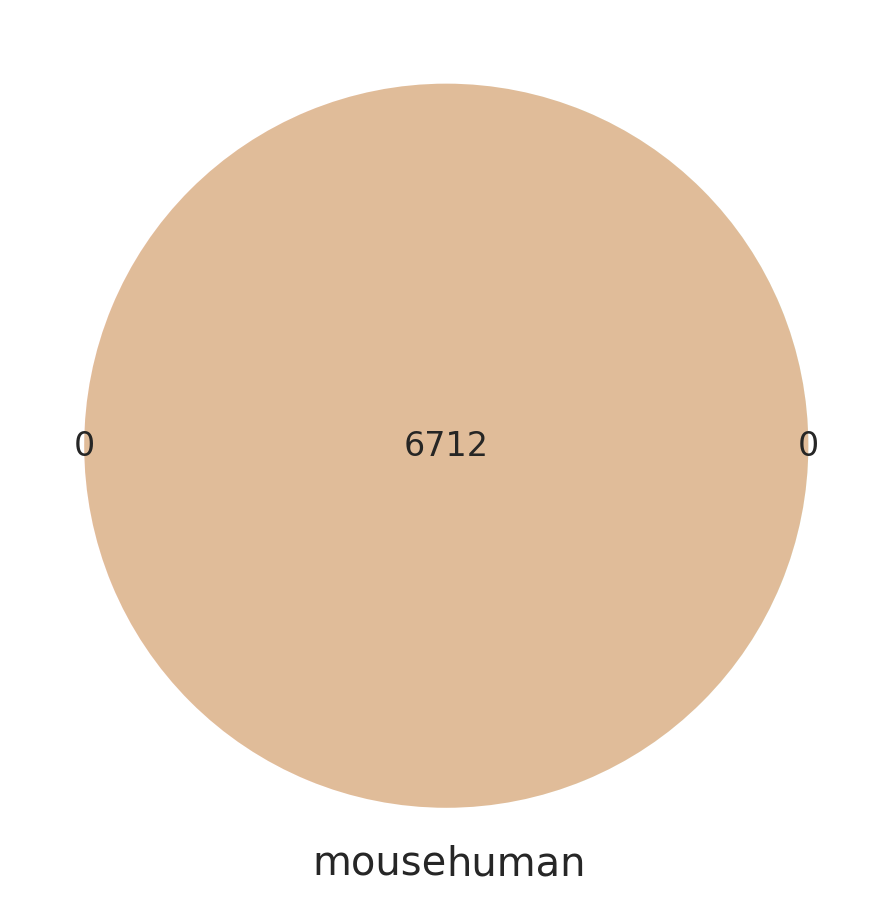

In [1577]:
### use only genes that appear in both human and mouse
intersecting_genes = set(rpkm_mouse_frame.index.values).intersection(set(rpkm_human_frame.index.values))

rpkm_mouse_frame = rpkm_mouse_frame[rpkm_mouse_frame.index.isin(intersecting_genes)]
rpkm_human_frame = rpkm_human_frame[rpkm_human_frame.index.isin(intersecting_genes)]

reads_mouse_frame = reads_mouse_frame[reads_mouse_frame.index.isin(intersecting_genes)]
reads_human_frame = reads_human_frame[reads_human_frame.index.isin(intersecting_genes)]

matplotlib_venn.venn2([set(rpkm_mouse_frame.index.values),
 set(rpkm_human_frame.index.values)],
 ['mouse', 'human'])

## Integrate IDR Scores with EdgeR

In [1578]:
condition_significantGenes_dict = {}
condition_significantFrame_dict = {}

In [1579]:
### Read in EdgeR Values

# human
diffExpression_human_frame = pd.read_csv('human_diffExpression.tsv', sep='\t')
columns = diffExpression_human_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_human_frame.columns=columns
diffExpression_human_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_human_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_human_frame.columns if 'vs.' in x]
diffExpression_human_frame = diffExpression_human_frame[columns]
diffExpression_human_frame = diffExpression_human_frame[diffExpression_human_frame['gene'].isin(human_homolog_genes)]
diffExpression_human_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping 
                                      else human_mouse_homologMapping[x] if x in mouse_human_homologMapping else x
                                      for x in diffExpression_human_frame['gene'].values]
diffExpression_human_frame.index = diffExpression_human_frame.gene.values


# mouse
diffExpression_mouse_frame = pd.read_csv('mouse_diffExpression.tsv', sep='\t')
columns = diffExpression_mouse_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_mouse_frame.columns=columns
diffExpression_mouse_frame['gene'] = [x.split('|')[0].upper() for x in diffExpression_mouse_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_mouse_frame.columns if 'vs.' in x]
diffExpression_mouse_frame = diffExpression_mouse_frame[columns]
diffExpression_mouse_frame = diffExpression_mouse_frame[diffExpression_mouse_frame['gene'].isin(mouse_homolog_genes)]
diffExpression_mouse_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping 
                                      else human_mouse_homologMapping[x] if x in mouse_human_homologMapping else x
                                      for x in diffExpression_mouse_frame['gene'].values]
diffExpression_mouse_frame.index = diffExpression_mouse_frame.gene.values



In [1580]:
### integrate mouse scores
treatments = ['Des', 'DMHCA', 'T09']
p_threshold = 0.05
fold_threshold = np.log2(2)
for treatment in treatments:
    idr_frame = pd.read_csv('mouse_' + treatment.lower() + '_idrUnion.tsv', sep='\t')
    idr_frame['gene'] = [x.split('|')[0].upper() for x in idr_frame['annotation'].values]
    idr_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping 
                                      else human_mouse_homologMapping[x] if x in mouse_human_homologMapping else x
                                      for x in idr_frame['gene']]
    idr_frame.index = idr_frame['gene'].values
    significant_frame = diffExpression_mouse_frame[
                            (diffExpression_mouse_frame[treatment + ' vs. Vehicle adj. p-value'] < p_threshold) &
                            (diffExpression_mouse_frame[treatment + ' vs. Vehicle Log2 Fold Change'].abs() > fold_threshold) &
                            (diffExpression_mouse_frame.index.isin(idr_frame.index.values)) &
                            (diffExpression_mouse_frame.index.isin(human_homolog_genes))
                        ][['gene', 
                           treatment + ' vs. Vehicle adj. p-value', 
                           treatment + ' vs. Vehicle Log2 Fold Change']]

    significant_idr_frame = idr_frame[idr_frame.index.isin(significant_frame.index.values)]
    gene_idrScore_dict = dict(zip(significant_idr_frame.index.values, 
                                  [[int(y) for y in x.split(', ')] for x in significant_idr_frame['idrScore']]))
    idr_means = []
    idr_medians = []
    idr_mins = []
    idr_maxes = []
    count = 0
    for gene in significant_frame.index.values:
        idr_vals = gene_idrScore_dict[gene]
        idr_means.append(np.mean(idr_vals))
        idr_medians.append(np.median(idr_vals))
        idr_mins.append(np.min(idr_vals))
        idr_maxes.append(np.max(idr_vals))
        
#     significant_frame['IDR Min'] = idr_mins
    significant_frame['IDR Mean'] = idr_means
    significant_frame['IDR Median'] = idr_medians
#     significant_frame['IDR Max'] = idr_maxes
    significant_frame = significant_frame.sort(treatment + ' vs. Vehicle adj. p-value')
    # down regulated genes
    down_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] > 0]
    down_frame.to_csv('mouse_'+treatment+'_down_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['mouse_' + treatment.lower() + '_down'] = down_frame
    condition_significantGenes_dict['mouse_' + treatment.lower() + '_down'] = down_frame.index.values
    # upregulated genes
    up_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] < 0]
    up_frame.to_csv('mouse_'+treatment+'_up_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['mouse_' + treatment.lower() + '_up'] = up_frame
    condition_significantGenes_dict['mouse_' + treatment.lower() + '_up'] = up_frame.index.values

In [1581]:
### integrate human scores
treatments = ['Des', 'DMHCA', 'T09']
p_threshold = 0.05
fold_threshold = np.log2(2)
for treatment in treatments:
    idr_frame = pd.read_csv('human_' + treatment.lower() + '_idrUnion.tsv', sep='\t')
    idr_frame['gene'] = [x.split('|')[0].upper() for x in idr_frame['annotation'].values]
    idr_frame['gene'] = [mouse_human_homologMapping[x] if x in mouse_human_homologMapping 
                                      else human_mouse_homologMapping[x] if x in mouse_human_homologMapping else x
                                      for x in idr_frame['gene']]
    idr_frame.index = idr_frame['gene'].values
    significant_frame = diffExpression_human_frame[
                            (diffExpression_human_frame[treatment + ' vs. Vehicle FDR'] < p_threshold) &
                            (diffExpression_human_frame[treatment + ' vs. Vehicle logFC'].abs() > fold_threshold) &
                            (diffExpression_human_frame.index.isin(idr_frame.index.values) &
                            (diffExpression_human_frame.index.isin(human_homolog_genes)))
                        ][['gene',
                           treatment + ' vs. Vehicle FDR', 
                           treatment + ' vs. Vehicle logFC']]
    
    significant_frame.columns = [x.replace('FDR', 'adj. p-value').replace('logFC', 'Log2 Fold Change')
                                 for x in significant_frame.columns.values]

    significant_idr_frame = idr_frame[idr_frame.index.isin(significant_frame.index.values)]
    gene_idrScore_dict = dict(zip(significant_idr_frame.index.values, 
                                  [[int(y) for y in x.split(', ')] for x in significant_idr_frame['idrScore']]))
    idr_means = []
    idr_medians = []
    idr_mins = []
    idr_maxes = []
    count = 0
    for gene in significant_frame.index.values:
        idr_vals = gene_idrScore_dict[gene]
        idr_means.append(np.mean(idr_vals))
        idr_medians.append(np.median(idr_vals))
        idr_mins.append(np.min(idr_vals))
        idr_maxes.append(np.max(idr_vals))
        
#     significant_frame['IDR Min'] = idr_mins
    significant_frame['IDR Mean'] = idr_means
    significant_frame['IDR Median'] = idr_medians
#     significant_frame['IDR Max'] = idr_maxes
    significant_frame = significant_frame.sort(treatment + ' vs. Vehicle adj. p-value')
    # down regulated genes
    down_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] > 0]
    down_frame.to_csv('human_'+treatment+'_down_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['human_' + treatment.lower() + '_down'] = down_frame
    condition_significantGenes_dict['human_' + treatment.lower() + '_down'] = down_frame.index.values
    # upregulated genes
    up_frame = significant_frame[significant_frame[treatment + ' vs. Vehicle Log2 Fold Change'] < 0]
    up_frame.to_csv('human_'+treatment+'_up_scores.tsv',sep='\t', index=False)
    condition_significantFrame_dict['human_' + treatment.lower() + '_up'] = up_frame
    condition_significantGenes_dict['human_' + treatment.lower() + '_up'] = up_frame.index.values

### Comparisons

### Des

In [1302]:
intersecting_genes = set(rpkm_mouse_frame.index.values).intersection(set(rpkm_human_frame.index.values))

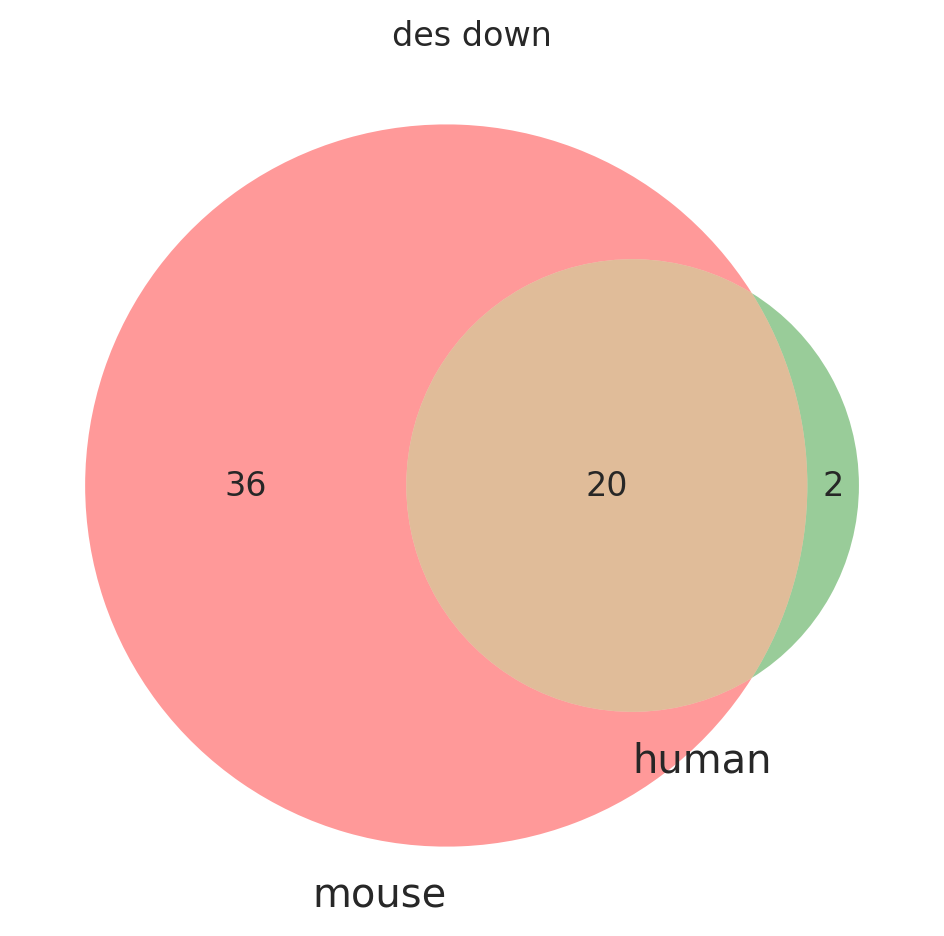

In [1303]:
treatment = 'des'
direction = 'down'

# gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
#             set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]
gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes)]



mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')




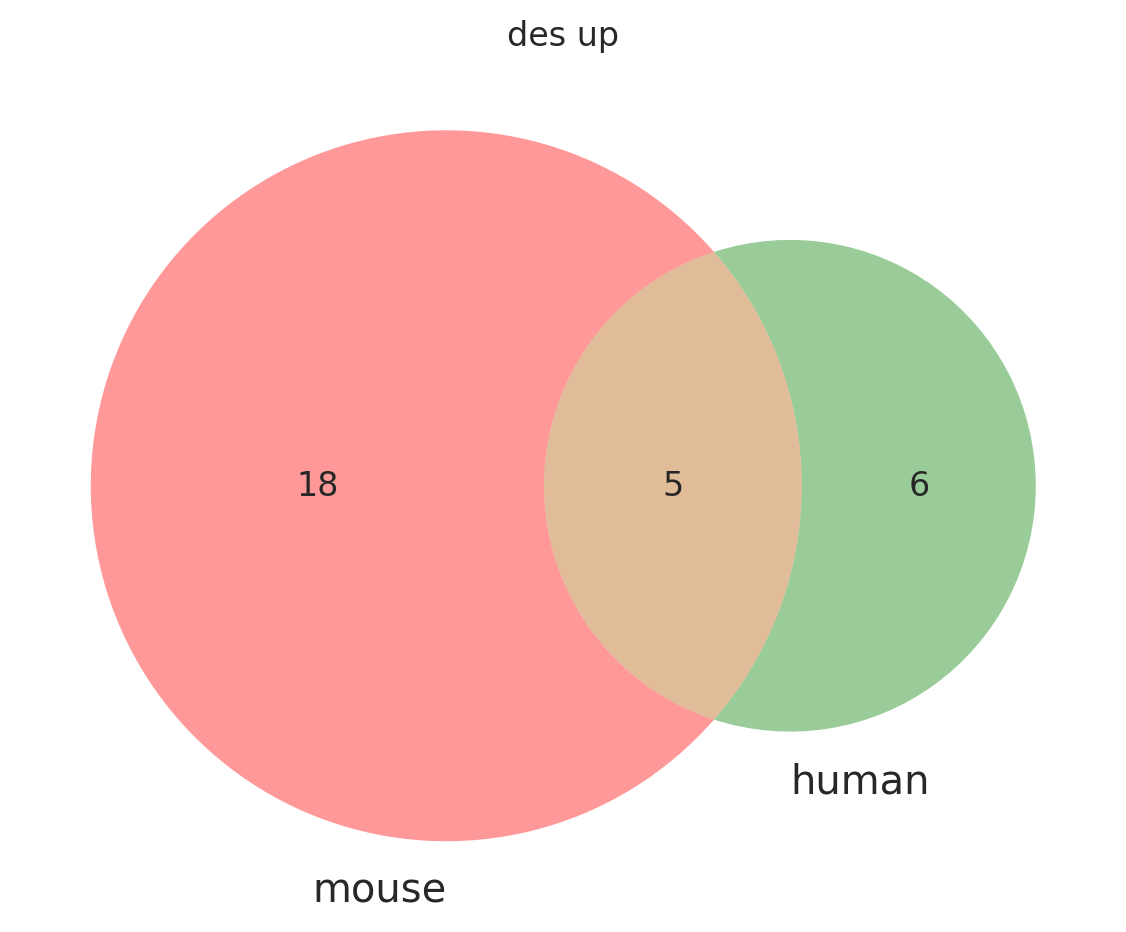

In [1304]:
treatment = 'des'
direction = 'up'

# gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
#             set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]
gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes)]


mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')



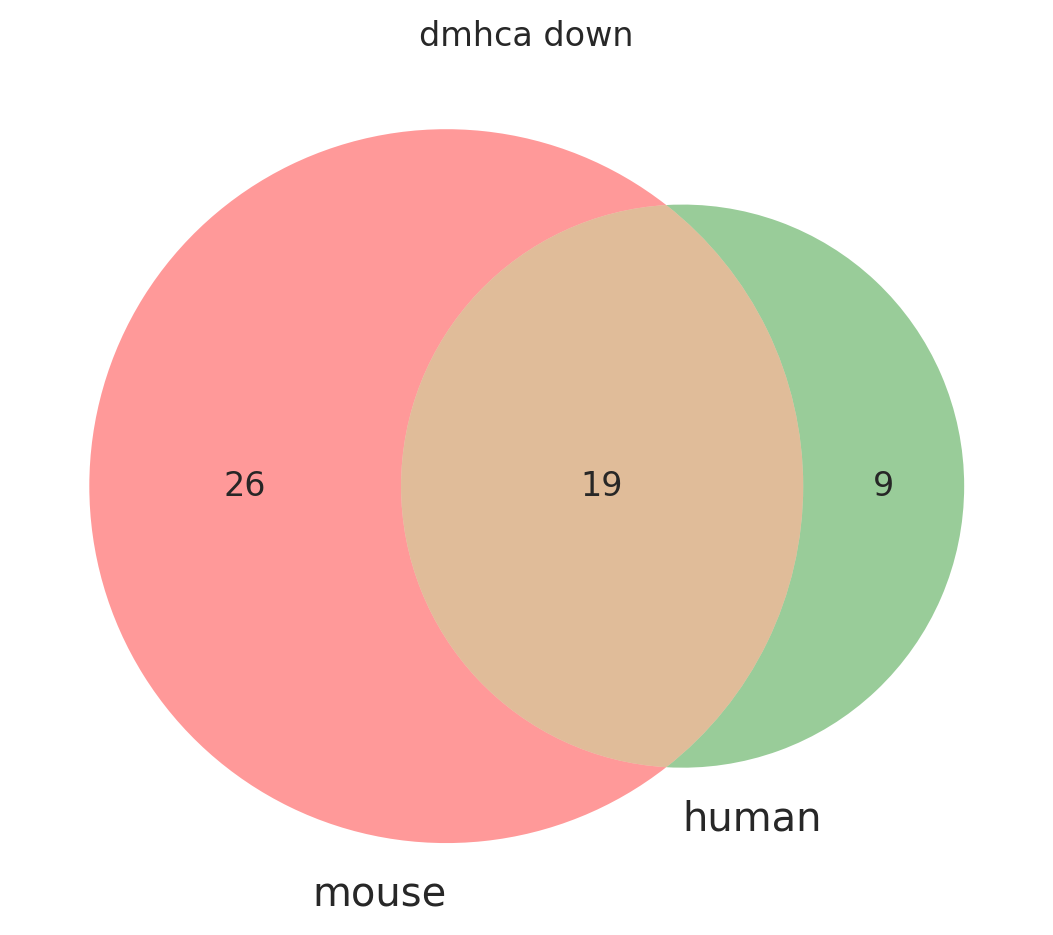

In [1305]:
treatment = 'dmhca'
direction = 'down'

# gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
#             set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]
gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes)]


mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')


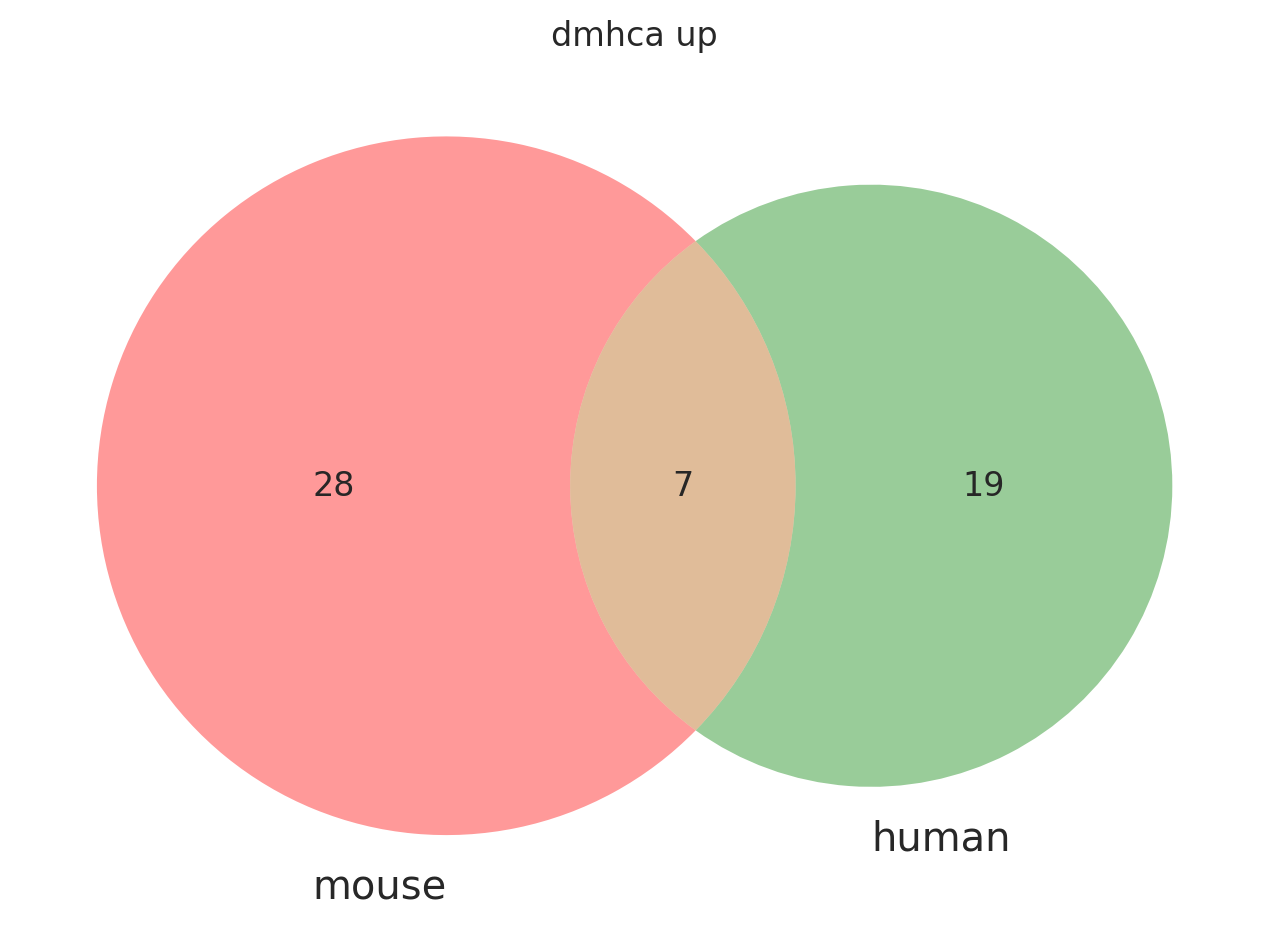

In [1306]:
treatment = 'dmhca'
direction = 'up'

# gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
#             set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]
gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes)]


mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')

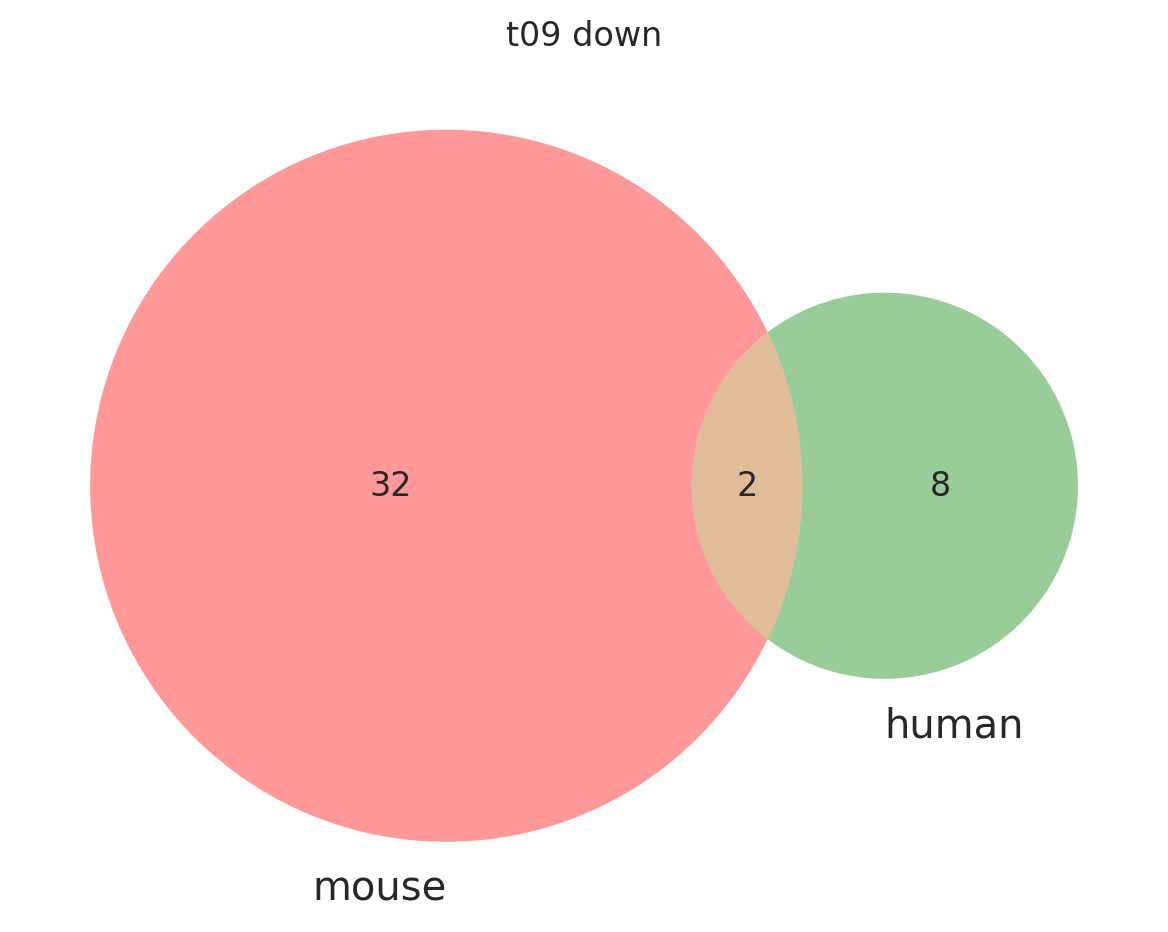

In [1307]:
treatment = 't09'
direction = 'down'

# gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
#             set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]
gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes)]


mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')



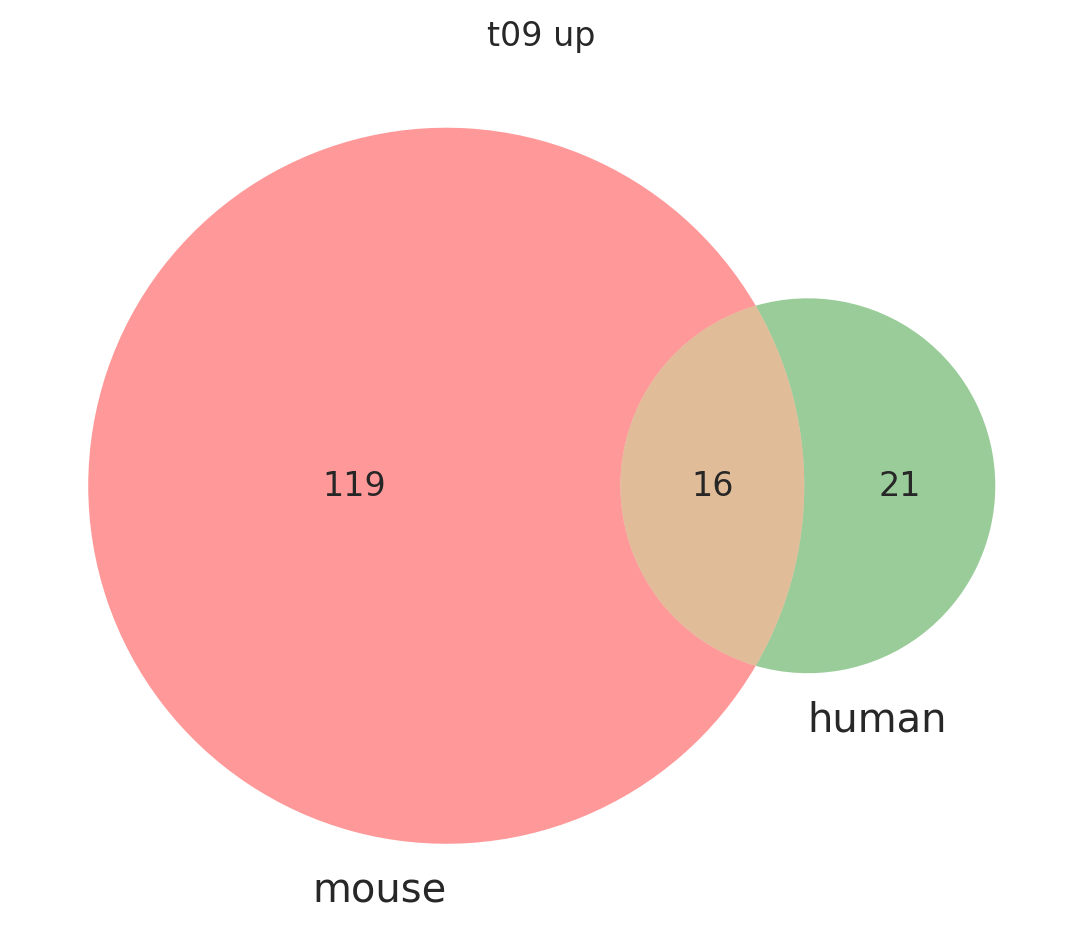

In [1308]:
treatment = 't09'
direction = 'up'

# gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]),
#             set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction])]
gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes),
            set(condition_significantGenes_dict['human_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes)]


mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
human_frame = condition_significantFrame_dict['human_' + treatment.lower() +'_'+direction]

mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]

# write output file
mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    intersection_frame.to_csv(f, index=False, sep='\t')
with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
    human_specific_frame.to_csv(f, index=False, sep='\t')

# plot venn diagram
matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
plt.title(treatment + ' ' + direction)

plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')


## Variance Stuff

In [1318]:
### match samples and treatments

# for humans
sample_treatments = set()
sampleNames = set()
treatments = set()

treatment_sample_human_dict = {}
for sample in rpkm_human_frame.columns[9:]:
    tokens = sample.split('_')
    sampleName = tokens[1]
    treatment = tokens[0]
    sampleNames.add(sampleName)
    treatments.add(treatment)
    sample_treatments.add((sampleName,treatment))
    if treatment in treatment_sample_human_dict:
        treatment_sample_human_dict[treatment].append(sample)
    else:
        treatment_sample_human_dict[treatment] = [sample]
        
treatment_sample_bool_human_dict = {x:[] for x in treatments}
for sample in sorted(sampleNames):
    for treatment in sorted(treatments):
        if (sample, treatment) in sample_treatments:
            treatment_sample_bool_human_dict[treatment].append(True)
        else:
            treatment_sample_bool_human_dict[treatment].append(False)
treatment_sample_human_frame = pd.DataFrame(treatment_sample_bool_human_dict, columns=sorted(treatments), index=sorted(sampleNames))

# pick samples to use in heatmap
selected_human_samples = treatment_sample_human_frame[treatment_sample_human_frame[['Des', 'DMHCA', 'T09', 'Vehicle']].sum(axis=1) ==4][['Des', 'DMHCA', 'T09', 'Vehicle']].index.values

In [1113]:
# for mouse
sample_treatments = set()
sampleNames = set()
treatments = set()

treatment_sample_mouse_dict = {}
for sample in rpkm_mouse_frame.columns[9:]:
    tokens = sample.split('_')
    sampleName = tokens[1]
    treatment = tokens[0]
    sampleNames.add(sampleName)
    treatments.add(treatment)
    sample_treatments.add((sampleName,treatment))
    if treatment in treatment_sample_mouse_dict:
        treatment_sample_mouse_dict[treatment].append(sample)
    else:
        treatment_sample_mouse_dict[treatment] = [sample]
        
treatment_sample_bool_mouse_dict = {x:[] for x in treatments}
for sample in sorted(sampleNames):
    for treatment in sorted(treatments):
        if (sample, treatment) in sample_treatments:
            treatment_sample_bool_mouse_dict[treatment].append(True)
        else:
            treatment_sample_bool_mouse_dict[treatment].append(False)
treatment_sample_mouse_frame = pd.DataFrame(treatment_sample_bool_mouse_dict, columns=sorted(treatments), index=sorted(sampleNames))

In [1114]:
treatment_sample_human_frame

DMHCA    Des     GW  Mepip   T09 Vehicle
006   True   True  False   True  True    True
008  False   True   True   True  True    True
012   True   True   True  False  True    True
013   True  False   True   True  True    True
015   True   True  False   True  True    True
021   True   True   True  False  True    True
024   True   True   True   True  True   False
038   True   True   True   True  True    True

In [1115]:
treatment_sample_mouse_frame

DMHCA   Des    GW Mepip   T09 Vehicle
1  True  True  True  True  True    True
2  True  True  True  True  True    True
3  True  True  True  True  True    True

### Variance Comparison

In [1116]:
### calculate median absolute deviation
genes = sorted(intersecting_genes)
column_vals_dict = {'gene':genes}
for treatment in sorted(treatment_sample_human_dict.keys()):
    human_samples = treatment_sample_human_dict[treatment]
    current_human_frame = rpkm_human_frame.ix[:, human_samples]
    
    mouse_samples = treatment_sample_mouse_dict[treatment]
    current_mouse_frame = rpkm_mouse_frame.ix[:, mouse_samples]
    
    current_human_mads = []
    current_mouse_mads = []
    for gene in genes:
        human_vals = current_human_frame.ix[gene, :].values
        mouse_vals = current_mouse_frame.ix[gene,:].values
        
        # calculate MAD
        human_mad = calcMAD(human_vals)
        mouse_mad = calcMAD(mouse_vals)
        
        current_human_mads.append(human_mad)
        current_mouse_mads.append(mouse_mad)
        
    column_vals_dict[treatment + ' human MAD'] = current_human_mads
    column_vals_dict[treatment + ' mouse MAD'] = current_mouse_mads

# create data frame
mad_frame = pd.DataFrame(column_vals_dict)
mad_frame.index = mad_frame['gene'].values
del mad_frame['gene']
mad_frame = mad_frame[sorted(mad_frame.columns.values)]
mad_frame = mad_frame.sort()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:32: FutureWarning: sort(....) is deprecated, use sort_index(.....)


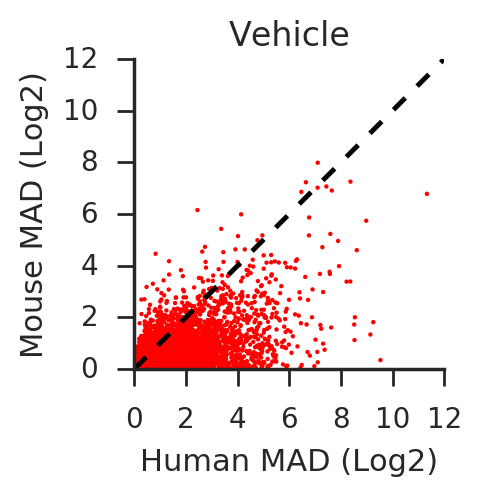

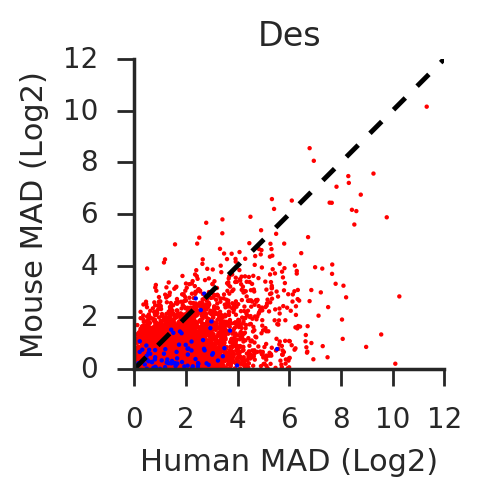

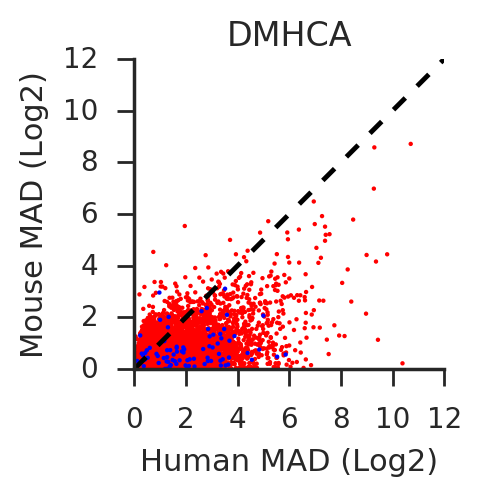

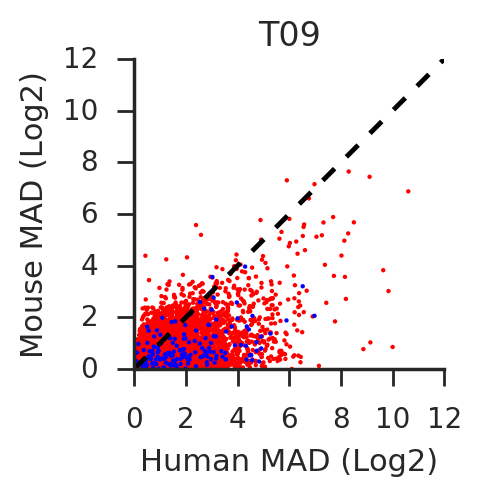

In [1117]:
genes = mad_frame.index.values
for treatment in ['Vehicle','Des', 'DMHCA', 'T09']:
    human_mads = mad_frame[treatment + ' human MAD'].values
    mouse_mads = mad_frame[treatment + ' mouse MAD'].values
    
    if not treatment == 'Vehicle':
        up_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']
        down_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']
        diff_genes = set(up_genes).union(down_genes)
    else:
        diff_genes = set()
    colors = ['blue' if x in diff_genes else 'red' for x in genes]
    
    tuples = zip(genes, human_mads, mouse_mads, colors)
    sorted_tuples = sorted(tuples, key=lambda x:x[3], reverse=True)
    sorted_genes = [x[0] for x in sorted_tuples]
    sorted_human_mads = np.array([x[1] for x in sorted_tuples])
    sorted_mouse_mads = np.array([x[2] for x in sorted_tuples])
    sorted_colors = [x[3] for x in sorted_tuples]
    
    with sns.axes_style('ticks'):
        plt.figure(figsize=(2,2))
        plt.scatter(np.log2(sorted_human_mads+1),
                    np.log2(sorted_mouse_mads + 1),
                    marker='.', edgecolor='None', s=10,c=sorted_colors)
        plt.plot([0,12], [0,12], linestyle='--', c='black')
        ax = plt.gca()
        ax.set_xlim((0,12))
        ax.set_ylim((0,12))
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 

        plt.title(treatment)
        plt.ylabel('Mouse MAD (Log2)')
        plt.xlabel('Human MAD (Log2)')
        
        sns.despine()
        plt.show()

### Effect Size VS Variance

In [1118]:
### calculate median absolute difference (wrt Vehicle)
genes = sorted(intersecting_genes)
column_vals_dict = {'gene':genes}
for treatment in sorted(treatment_sample_human_dict.keys()):
    if treatment == 'Vehicle':
        break
    human_veh_frame = rpkm_human_frame.ix[:, treatment_sample_human_dict['Vehicle']]
    mouse_veh_frame = rpkm_mouse_frame.ix[:, treatment_sample_mouse_dict['Vehicle']]
    
    human_samples = treatment_sample_human_dict[treatment]
    current_human_frame = rpkm_human_frame.ix[:, human_samples]
    
    mouse_samples = treatment_sample_mouse_dict[treatment]
    current_mouse_frame = rpkm_mouse_frame.ix[:, mouse_samples]
    
    current_human_differences = []
    current_mouse_differences = []
    for gene in genes:
        human_vals = current_human_frame.ix[gene,:].values
        mouse_vals = current_mouse_frame.ix[gene,:].values
        
        human_veh_vals = human_veh_frame.ix[gene,:].values
        mouse_veh_vals = mouse_veh_frame.ix[gene,:].values
        
        # calculate MAD
        human_difference = abs(np.median(human_vals) - np.median(human_veh_vals))
        mouse_difference = abs(np.median(mouse_vals) - np.median(mouse_veh_vals))
        
        current_human_differences.append(human_difference)
        current_mouse_differences.append(mouse_difference)
        
    column_vals_dict[treatment + ' human median difference'] = current_human_differences
    column_vals_dict[treatment + ' mouse median difference'] = current_mouse_differences

# create data frame
medianDifference_frame = pd.DataFrame(column_vals_dict)
medianDifference_frame.index = medianDifference_frame['gene'].values
del medianDifference_frame['gene']
medianDifference_frame = medianDifference_frame[sorted(medianDifference_frame.columns.values)]
medianDifference_frame = medianDifference_frame.sort()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [1009]:
# ### plot MAD vs median difference (wrt Vehicle)
# genes = mad_frame.index.values
# for treatment in ['Des', 'DMHCA', 'T09']:
#     human_mads = mad_frame[treatment + ' human MAD'].values
#     mouse_mads = mad_frame[treatment + ' mouse MAD'].values
    
#     human_medDiffs = medianDifference_frame[treatment + ' human median difference'].values
#     mouse_medDiffs = medianDifference_frame[treatment + ' mouse median difference'].values

#     up_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']
#     down_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']
#     diff_genes = set(up_genes).union(down_genes)
#     colors = ['blue' if x in diff_genes else 'red' for x in genes]
    
    
#     tuples = zip(genes, 
#                  human_mads, 
#                  mouse_mads, 
#                  human_medDiffs, 
#                  mouse_medDiffs, 
#                  colors)
#     sorted_tuples = sorted(tuples, key=lambda x:x[5], reverse=True)
#     sorted_genes = [x[0] for x in sorted_tuples]
#     sorted_human_mads = np.array([x[1] for x in sorted_tuples])
#     sorted_mouse_mads = np.array([x[2] for x in sorted_tuples])
#     sorted_human_medDiffs = np.array([x[3] for x in sorted_tuples])
#     sorted_mouse_medDiffs = np.array([x[4] for x in sorted_tuples])
#     sorted_colors = [x[5] for x in sorted_tuples]
    
#     with sns.axes_style('ticks'):
#         # make human plot
#         plt.figure(figsize=(2,2))
#         plt.scatter(np.log2(sorted_human_medDiffs + 1), np.log2(sorted_human_mads+1),
#                     marker='.', edgecolor='None', s=10,c=sorted_colors)
# #         plt.plot([0,12], [0,12], linestyle='--', c='black')
#         ax = plt.gca()
# #         ax.set_xlim((0,12))
# #         ax.set_ylim((0,12))
#         x0,x1 = ax.get_xlim()
#         y0,y1 = ax.get_ylim()
#         ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 

#         plt.title('Human ' +treatment)
#         plt.xlabel('Human Median Difference (Log2)')
#         plt.ylabel('Human MAD (Log2)')
        
#         sns.despine()
#         plt.show()
        
#         # make mouse plot
#         plt.figure(figsize=(2,2))
#         plt.scatter(np.log2(sorted_mouse_medDiffs + 1), np.log2(sorted_mouse_mads+1),
#                     marker='.', edgecolor='None', s=10,c=sorted_colors)
# #         plt.plot([0,12], [0,12], linestyle='--', c='black')
#         ax = plt.gca()
# #         ax.set_xlim((0,12))
# #         ax.set_ylim((0,12))
#         x0,x1 = ax.get_xlim()
#         y0,y1 = ax.get_ylim()
#         ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 

#         plt.title('Mouse ' +treatment)
#         plt.xlabel('Mouse Median Difference (Log2)')
#         plt.ylabel('Mouse MAD (Log2)')
        
#         sns.despine()
#         plt.show()

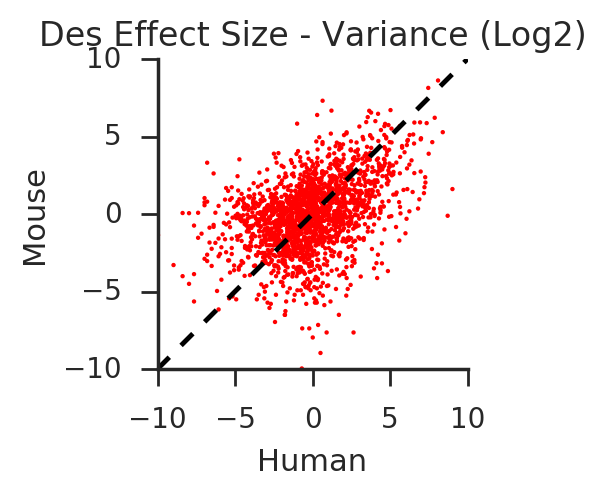

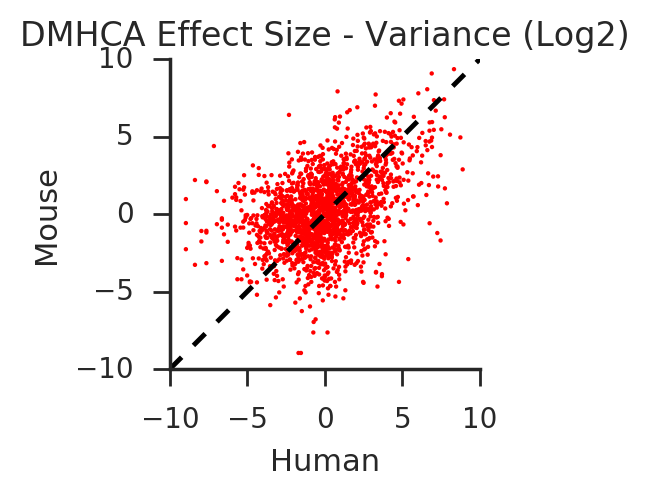

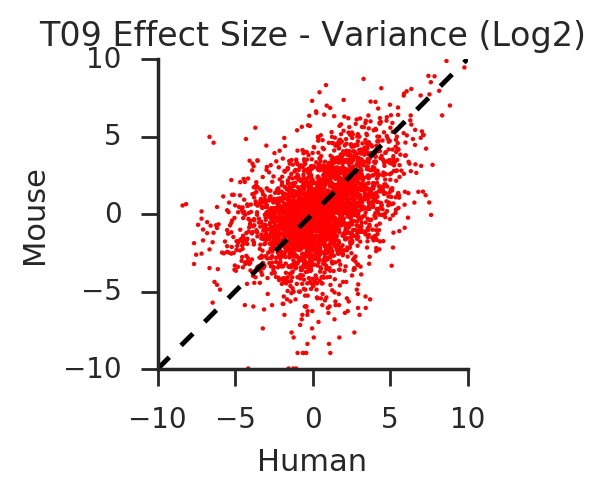

In [1167]:
### plot MAD vs median difference (wrt Vehicle)
genes = mad_frame.index.values
for treatment in ['Des', 'DMHCA', 'T09']:
    human_mads = mad_frame[treatment + ' human MAD'].values
    mouse_mads = mad_frame[treatment + ' mouse MAD'].values
    
    human_medDiffs = medianDifference_frame[treatment + ' human median difference'].values
    mouse_medDiffs = medianDifference_frame[treatment + ' mouse median difference'].values

    up_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']
    down_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']
    diff_genes = set(up_genes).union(down_genes)
    colors = ['blue' if x in diff_genes else 'red' for x in genes]
    
    
    tuples = zip(genes, 
                 human_mads, 
                 mouse_mads, 
                 human_medDiffs, 
                 mouse_medDiffs, 
                 colors)
    sorted_tuples = sorted(tuples, key=lambda x:x[5], reverse=True)
    sorted_genes = [x[0] for x in sorted_tuples]
    sorted_human_mads = np.array([x[1] for x in sorted_tuples])
    sorted_mouse_mads = np.array([x[2] for x in sorted_tuples])
    sorted_human_medDiffs = np.array([x[3] for x in sorted_tuples])
    sorted_mouse_medDiffs = np.array([x[4] for x in sorted_tuples])
    sorted_colors = [x[5] for x in sorted_tuples]
    
    with sns.axes_style('ticks'):
        # make human plot
        plt.figure(figsize=(2,2))
#         transformed_human_vals = [np.log2(x+1) if x > 0 else -1*np.log2(abs(x)+1) for x in sorted_human_medDiffs - sorted_human_mads]
#         transformed_mouse_vals = [np.log2(x+1) if x > 0 else -1*np.log2(abs(x)+1) for x in sorted_mouse_medDiffs - sorted_mouse_mads]
        transformed_human_vals = np.log2(abs(sorted_human_medDiffs) - abs(sorted_human_mads))
        transformed_mouse_vals = np.log2(abs(sorted_mouse_medDiffs) - abs(sorted_mouse_mads))
#         transformed_human_vals = ((sorted_human_medDiffs+1) / (sorted_human_mads+1))
#         transformed_mouse_vals = ((sorted_mouse_medDiffs+1) / (sorted_mouse_mads+1))

        plt.scatter(transformed_human_vals,
                    transformed_mouse_vals,
                    marker='.', edgecolor='None', s=10,c=sorted_colors)
        plt.plot([-10,10], [-10,10], linestyle='--', c='black')
        ax = plt.gca()
        ax.set_xlim((-10,10))
        ax.set_ylim((-10,10))
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 

        plt.title(treatment + ' Effect Size - Variance (Log2)')
        plt.xlabel('Human')
        plt.ylabel('Mouse')
        
        sns.despine()
        plt.show()
        

### Fold Change

In [1124]:
### calculate fold change (wrt Vehicle)

genes = sorted(intersecting_genes)
column_vals_dict = {'gene':genes}
for treatment in sorted(treatment_sample_human_dict.keys()):
    if treatment == 'Vehicle':
        break
    ### calculate fold changes
    # for human
    current_column_val_dict = {}
    for sample in treatment_sample_human_frame.index.values:
        if treatment_sample_human_frame.ix[sample, 'Vehicle']:
            if treatment_sample_human_frame.ix[sample, treatment]:
                current_column_val_dict[sample] = (rpkm_human_frame[treatment + '_' + sample] +1)/(rpkm_human_frame['Vehicle_'+sample] +1)
    current_human_frame = pd.DataFrame(current_column_val_dict)
    current_human_frame.index = genes
    
    # for mouse
    current_column_val_dict = {}
    for sample in treatment_sample_mouse_frame.index.values:
        if treatment_sample_mouse_frame.ix[sample, 'Vehicle']:
            if treatment_sample_mouse_frame.ix[sample, treatment]:
                current_column_val_dict[sample] = (rpkm_mouse_frame[treatment + '_' + sample] +1)/(rpkm_mouse_frame['Vehicle_'+sample] +1)
    current_mouse_frame = pd.DataFrame(current_column_val_dict)
    current_mouse_frame.index = genes
    
    ### calculate MAD values
    current_human_mads = []
    current_mouse_mads = []
    for gene in genes:
        human_vals = current_human_frame.ix[gene, :].values
        mouse_vals = current_mouse_frame.ix[gene,:].values
        
        # calculate MAD
        human_mad = calcMAD(human_vals)
        mouse_mad = calcMAD(mouse_vals)
        
        current_human_mads.append(human_mad)
        current_mouse_mads.append(mouse_mad)
        
    column_vals_dict[treatment + ' human FC MAD'] = current_human_mads
    column_vals_dict[treatment + ' mouse FC MAD'] = current_mouse_mads
    
# create data frame
fc_mad_frame = pd.DataFrame(column_vals_dict)
fc_mad_frame.index = fc_mad_frame['gene'].values
del fc_mad_frame['gene']
fc_mad_frame = fc_mad_frame[sorted(fc_mad_frame.columns.values)]
fc_mad_frame = fc_mad_frame.sort()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [1125]:
### calculate the median fold change
genes = sorted(intersecting_genes)
column_vals_dict = {'gene':genes}
for treatment in sorted(treatment_sample_human_dict.keys()):
    if treatment == 'Vehicle':
        break
    ### calculate fold changes
    # for human
    current_column_val_dict = {}
    for sample in treatment_sample_human_frame.index.values:
        if treatment_sample_human_frame.ix[sample, 'Vehicle']:
            if treatment_sample_human_frame.ix[sample, treatment]:
                current_column_val_dict[sample] = (rpkm_human_frame[treatment + '_' + sample] +1)/(rpkm_human_frame['Vehicle_'+sample] +1)
    current_human_frame = pd.DataFrame(current_column_val_dict)
    current_human_frame.index = genes
    
    # for mouse
    current_column_val_dict = {}
    for sample in treatment_sample_mouse_frame.index.values:
        if treatment_sample_mouse_frame.ix[sample, 'Vehicle']:
            if treatment_sample_mouse_frame.ix[sample, treatment]:
                current_column_val_dict[sample] = (rpkm_mouse_frame[treatment + '_' + sample] +1)/(rpkm_mouse_frame['Vehicle_'+sample] +1)
    current_mouse_frame = pd.DataFrame(current_column_val_dict)
    current_mouse_frame.index = genes
    
    ### calculate MAD values
    current_human_meds = []
    current_mouse_meds = []
    for gene in genes:
        human_vals = current_human_frame.ix[gene,:].values
        mouse_vals = current_mouse_frame.ix[gene,:].values
        
        # calculate MAD
        human_med = np.median(human_vals)
        mouse_med = np.median(mouse_vals)
        
        current_human_meds.append(human_med)
        current_mouse_meds.append(mouse_med)
        
    column_vals_dict[treatment + ' human median FC'] = current_human_meds
    column_vals_dict[treatment + ' mouse median FC'] = current_mouse_meds
    
# create data frame
medFoldChange_frame = pd.DataFrame(column_vals_dict)
medFoldChange_frame.index = medFoldChange_frame['gene'].values
del medFoldChange_frame['gene']
medFoldChange_frame = medFoldChange_frame[sorted(medFoldChange_frame.columns.values)]
medFoldChange_frame = medFoldChange_frame.sort()

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:48: FutureWarning: sort(....) is deprecated, use sort_index(.....)


In [1169]:
# genes = fc_mad_frame.index.values
# for treatment in ['Des', 'DMHCA', 'T09']:
#     human_mads = fc_mad_frame[treatment + ' human FC MAD'].values
#     mouse_mads = fc_mad_frame[treatment + ' mouse FC MAD'].values
    
#     if not treatment == 'Vehicle':
#         up_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']
#         down_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']
#         diff_genes = set(up_genes).union(down_genes)
#     else:
#         diff_genes = set()
#     colors = ['blue' if x in diff_genes else 'red' for x in genes]
    
#     tuples = zip(genes, human_mads, mouse_mads, colors)
#     sorted_tuples = sorted(tuples, key=lambda x:x[3], reverse=True)
#     sorted_genes = [x[0] for x in sorted_tuples]
#     sorted_human_mads = np.array([x[1] for x in sorted_tuples])
#     sorted_mouse_mads = np.array([x[2] for x in sorted_tuples])
#     sorted_colors = [x[3] for x in sorted_tuples]
    
#     with sns.axes_style('ticks'):
#         plt.figure(figsize=(2,2))
#         plt.scatter(np.log2(sorted_human_mads+1),
#                     np.log2(sorted_mouse_mads + 1),
#                     marker='.', edgecolor='None', s=10,c=sorted_colors)
#         plt.plot([0,12], [0,12], linestyle='--', c='black')
#         ax = plt.gca()
#         ax.set_xlim((0,1))
#         ax.set_ylim((0,1))
#         x0,x1 = ax.get_xlim()
#         y0,y1 = ax.get_ylim()
#         ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 

#         plt.title(treatment)
#         plt.ylabel('Mouse FC MAD (Log2)')
#         plt.xlabel('Human FC MAD (Log2)')
        
#         sns.despine()
#         plt.show()

In [ ]:
### plot MAD vs median difference (wrt Vehicle)
genes = mad_frame.index.values
for treatment in ['Des', 'DMHCA', 'T09']:
    human_mads = fc_mad_frame[treatment + ' human FC MAD'].values
    mouse_mads = fc_mad_frame[treatment + ' mouse FC MAD'].values
    
    human_medFolds = medFoldChange_frame[treatment + ' human median FC'].values
    mouse_medFolds = medFoldChange_frame[treatment + ' mouse median FC'].values

    up_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']
    down_genes = condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']
    diff_genes = set(up_genes).union(down_genes)
    colors = ['blue' if x in diff_genes else 'red' for x in genes]
    
    
    tuples = zip(genes, 
                 human_mads, 
                 mouse_mads, 
                 human_medFolds, 
                 mouse_medFolds, 
                 colors)
    sorted_tuples = sorted(tuples, key=lambda x:x[5], reverse=True)
    sorted_genes = [x[0] for x in sorted_tuples]
    sorted_human_mads = np.array([x[1] for x in sorted_tuples])
    sorted_mouse_mads = np.array([x[2] for x in sorted_tuples])
    sorted_human_medFolds = np.array([x[3] for x in sorted_tuples])
    sorted_mouse_medFolds = np.array([x[4] for x in sorted_tuples])
    sorted_colors = [x[5] for x in sorted_tuples]
    
    with sns.axes_style('ticks'):
        # make human plot
        plt.figure(figsize=(3,3))
        plt.scatter(np.log2(abs((sorted_human_medFolds+1) - abs(sorted_human_mads+1))),
                    np.log2(abs((sorted_mouse_medFolds+1) - abs(sorted_mouse_mads+1))),
                    marker='.', edgecolor='None', s=10,c=sorted_colors)
        plt.plot([-4,4], [-4,4], linestyle='--', c='black')
        ax = plt.gca()
        ax.set_xlim((-4,4))
        ax.set_ylim((-4,4))
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0)) 

        plt.title(treatment + ' Fold Change Effect Size - Variance (Log2)')
        plt.xlabel('Human')
        plt.ylabel('Mouse')
        
        sns.despine()
        plt.show()
        

## Z-test for finding diff expressed genes

In [1066]:
treatment_sample_human_frame

DMHCA    Des     GW  Mepip   T09 Vehicle
006   True   True  False   True  True    True
008  False   True   True   True  True    True
012   True   True   True  False  True    True
013   True  False   True   True  True    True
015   True   True  False   True  True    True
021   True   True   True  False  True    True
024   True   True   True   True  True   False
038   True   True   True   True  True    True

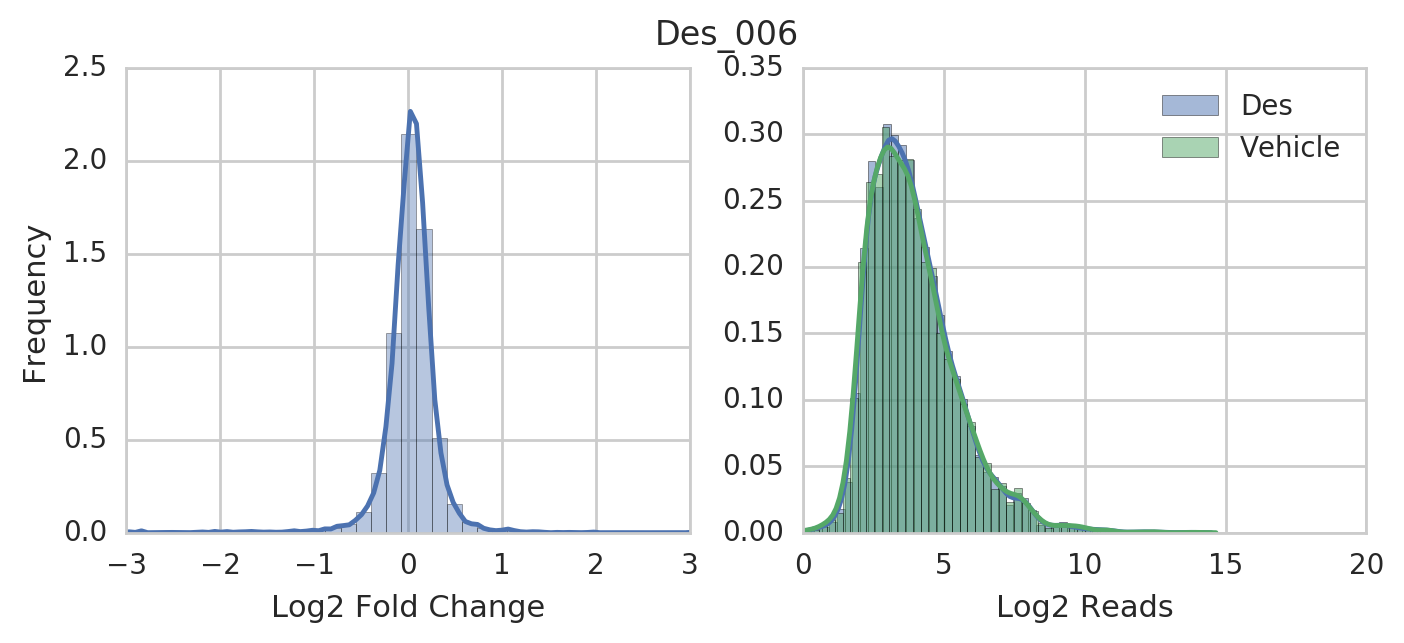

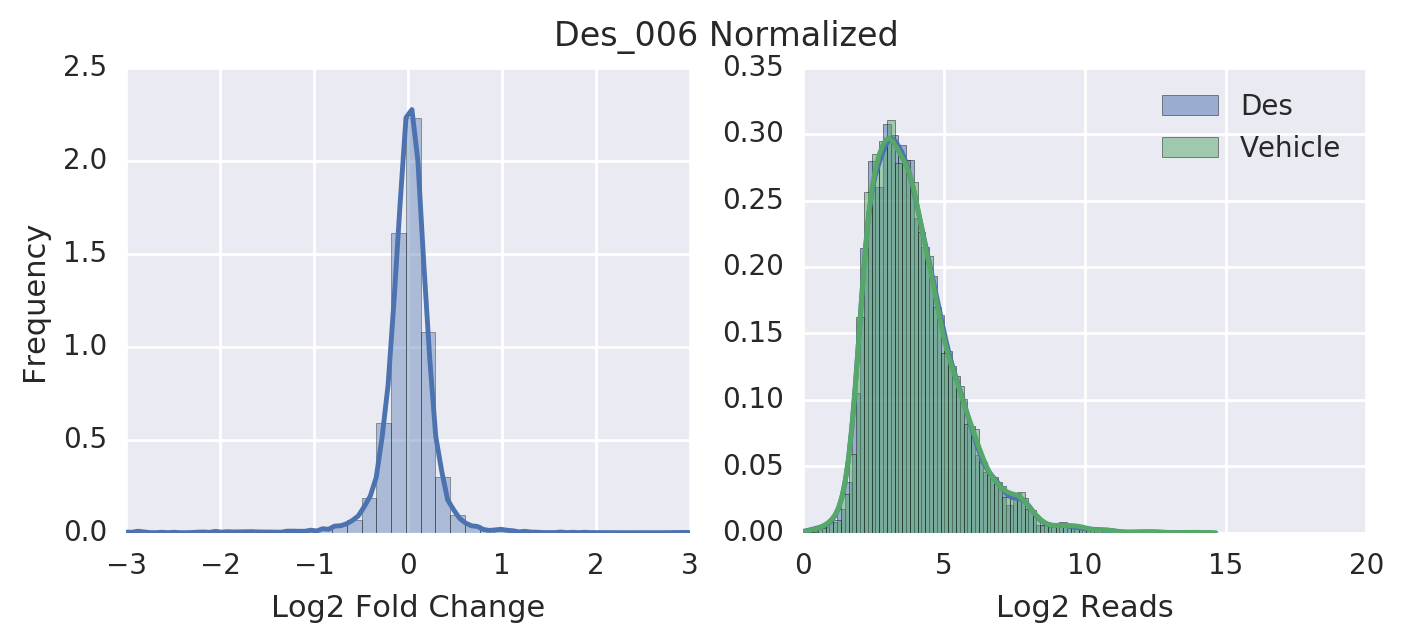

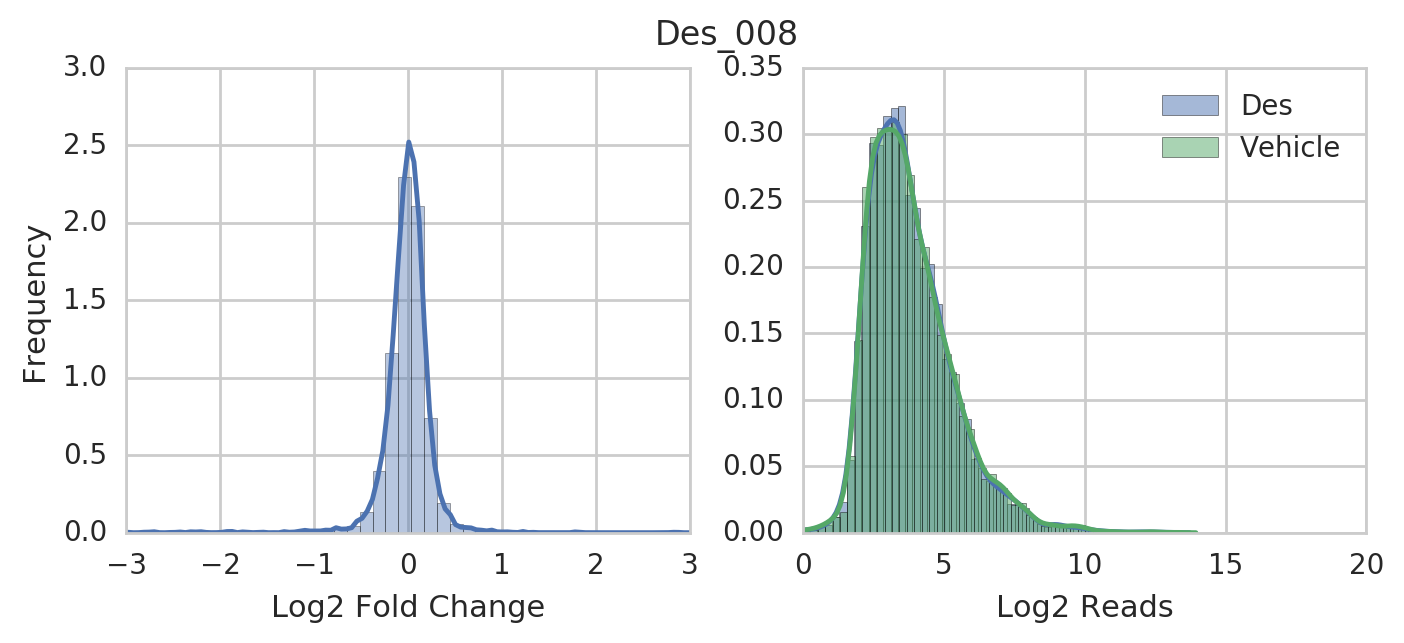

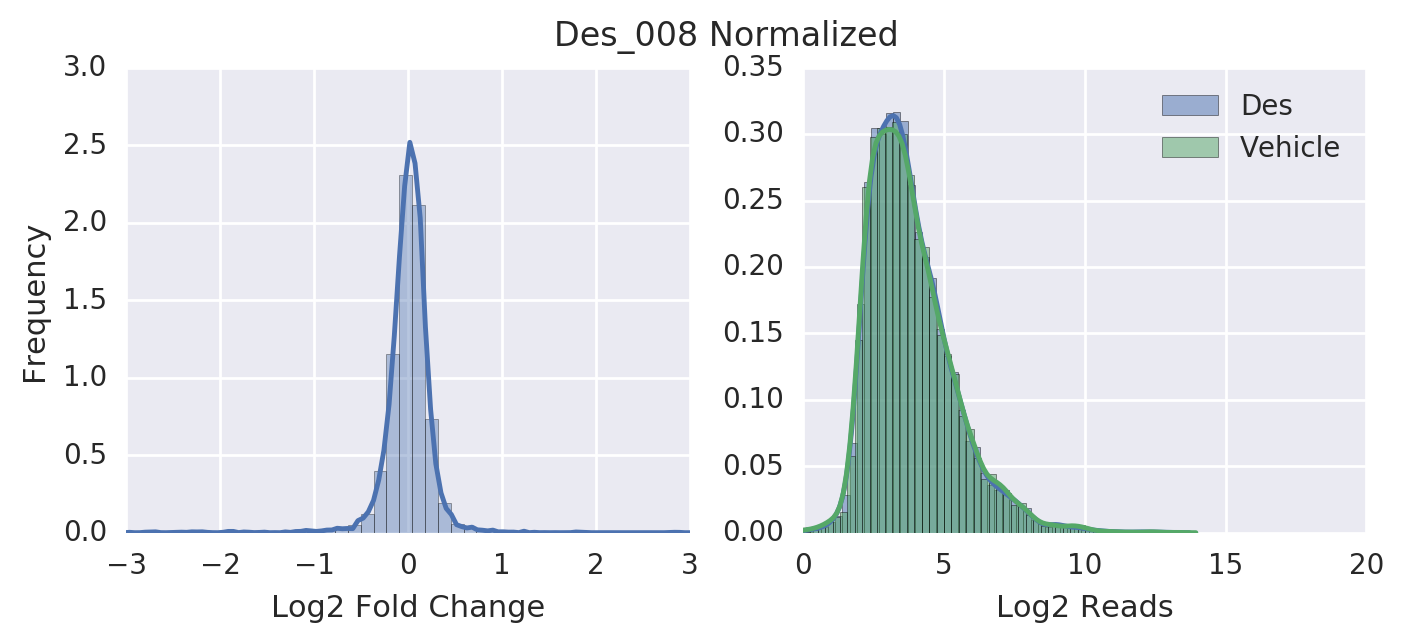

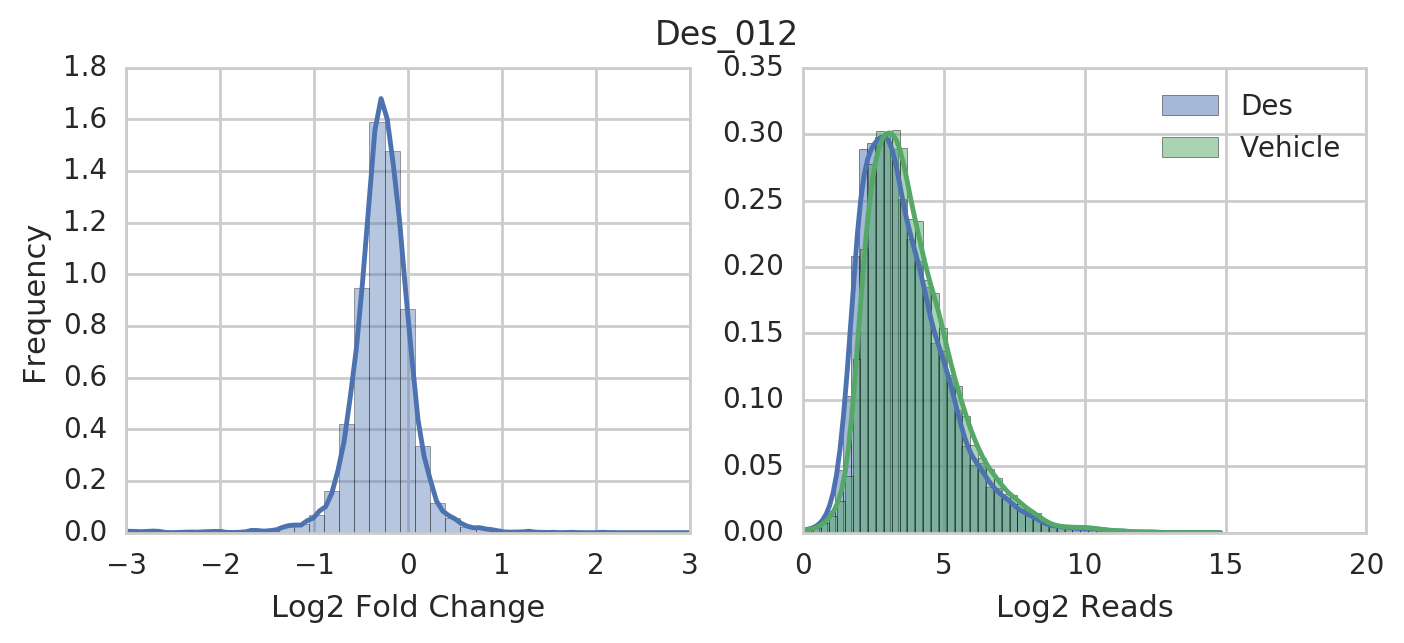

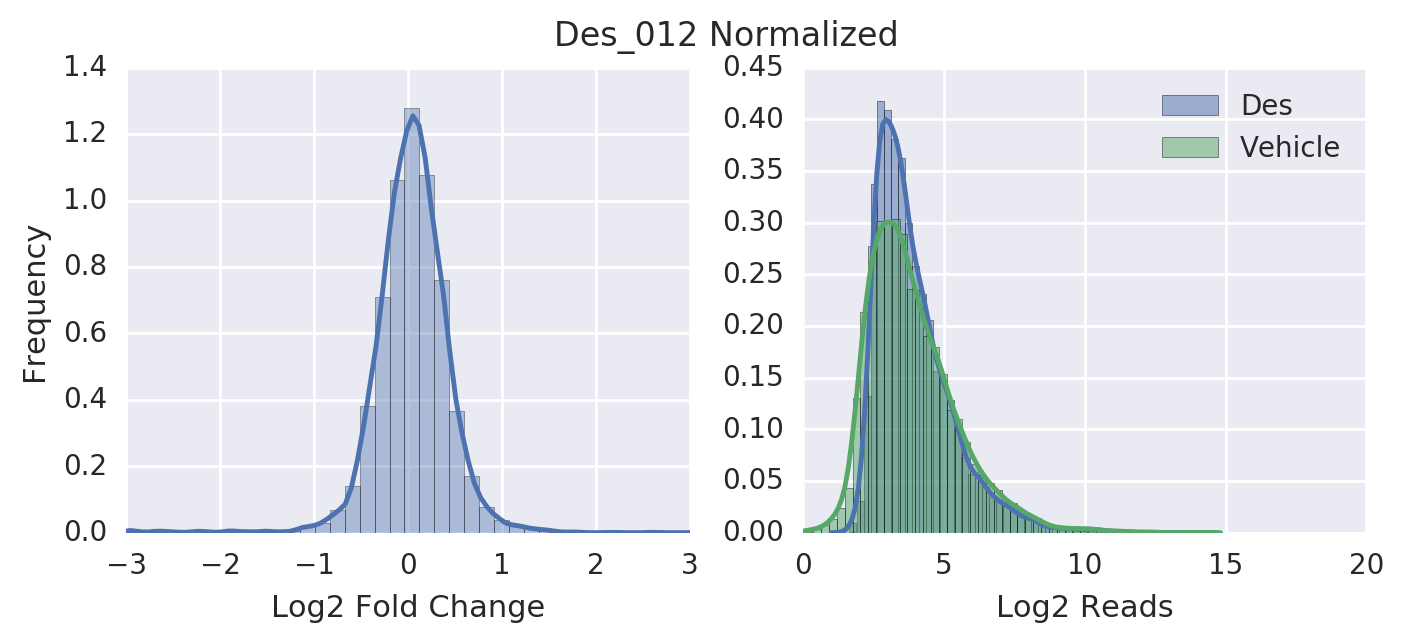

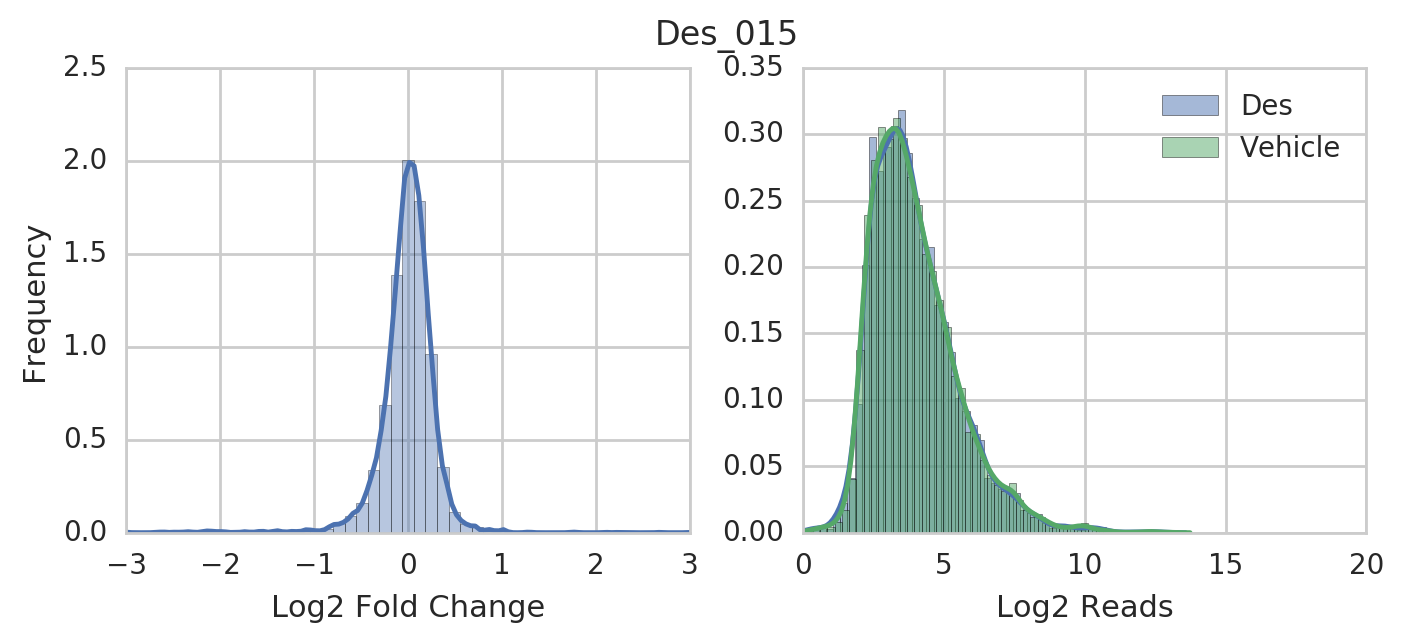

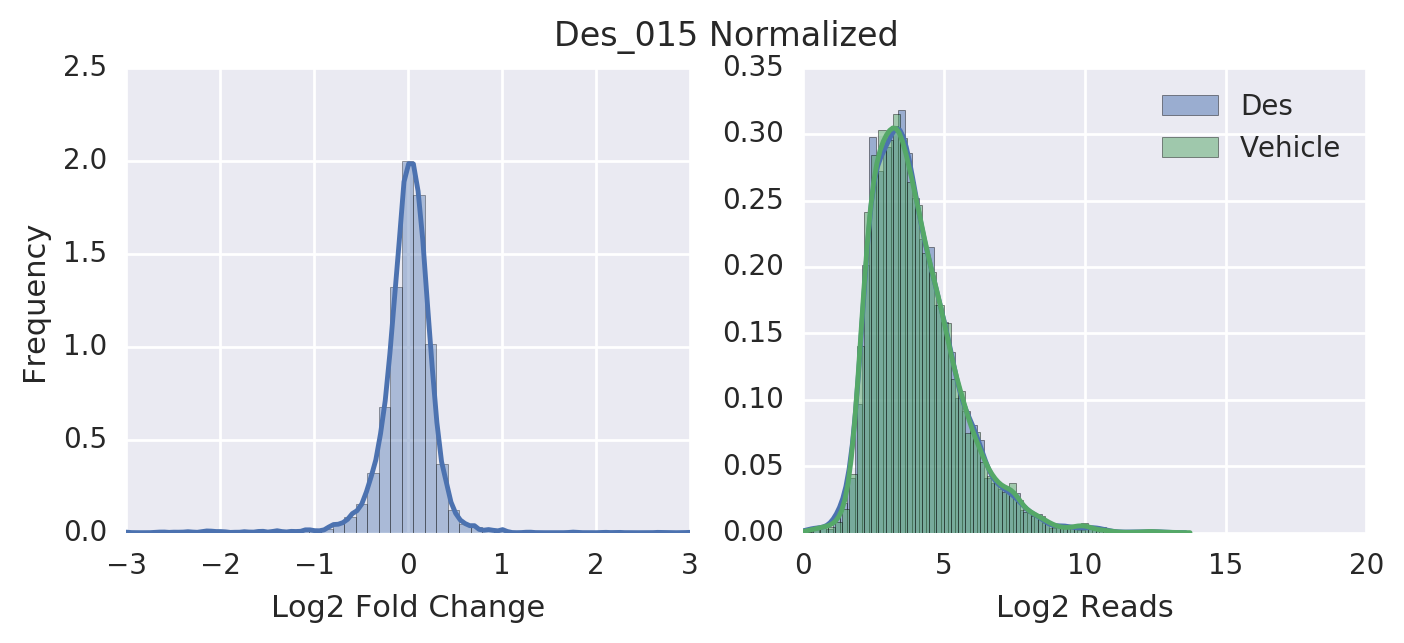

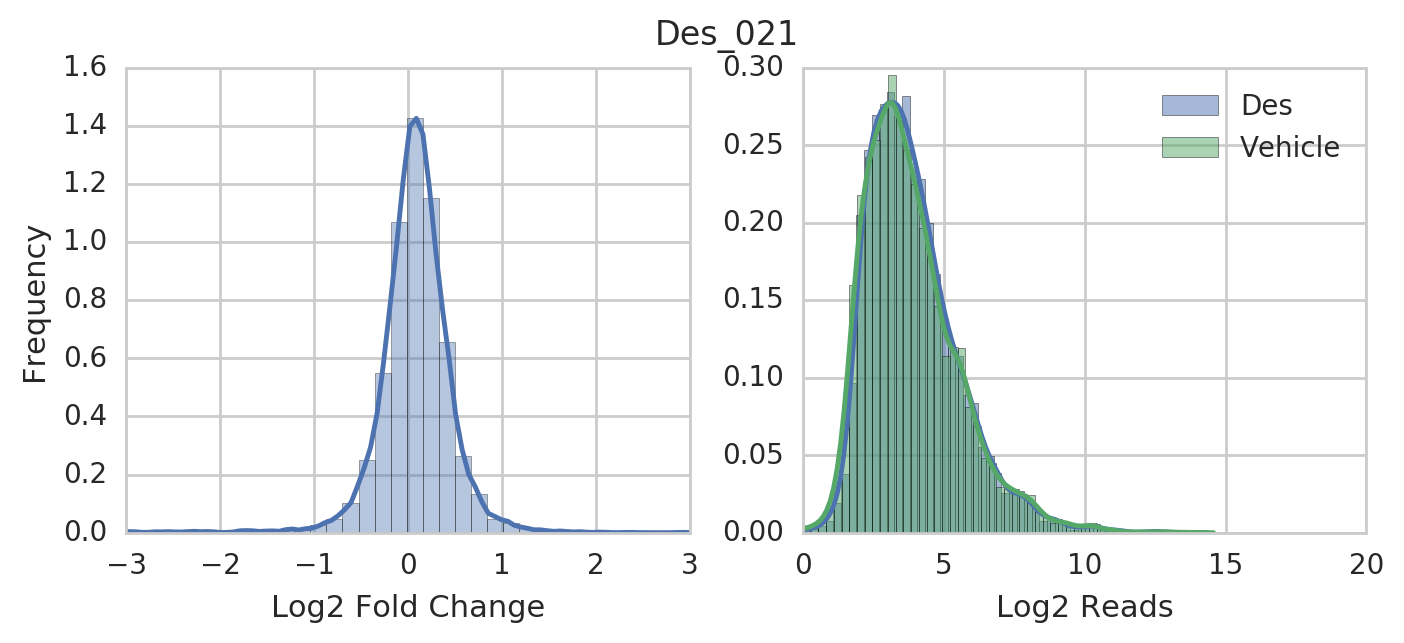

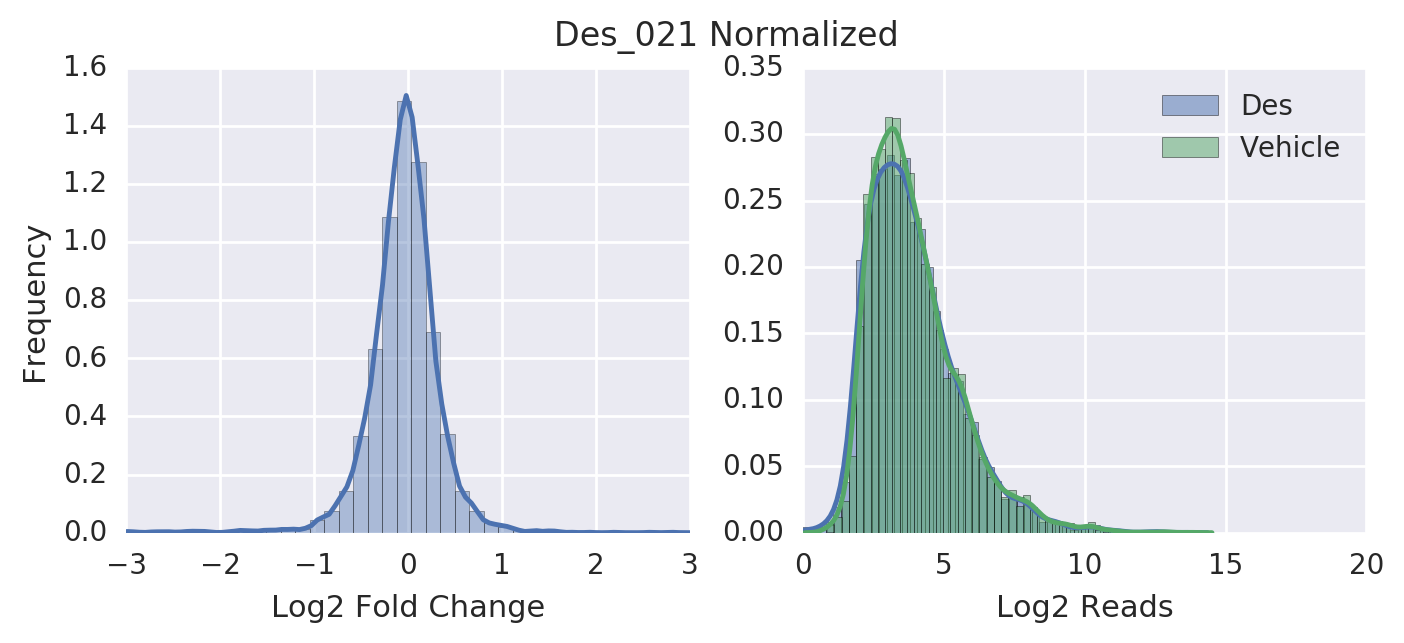

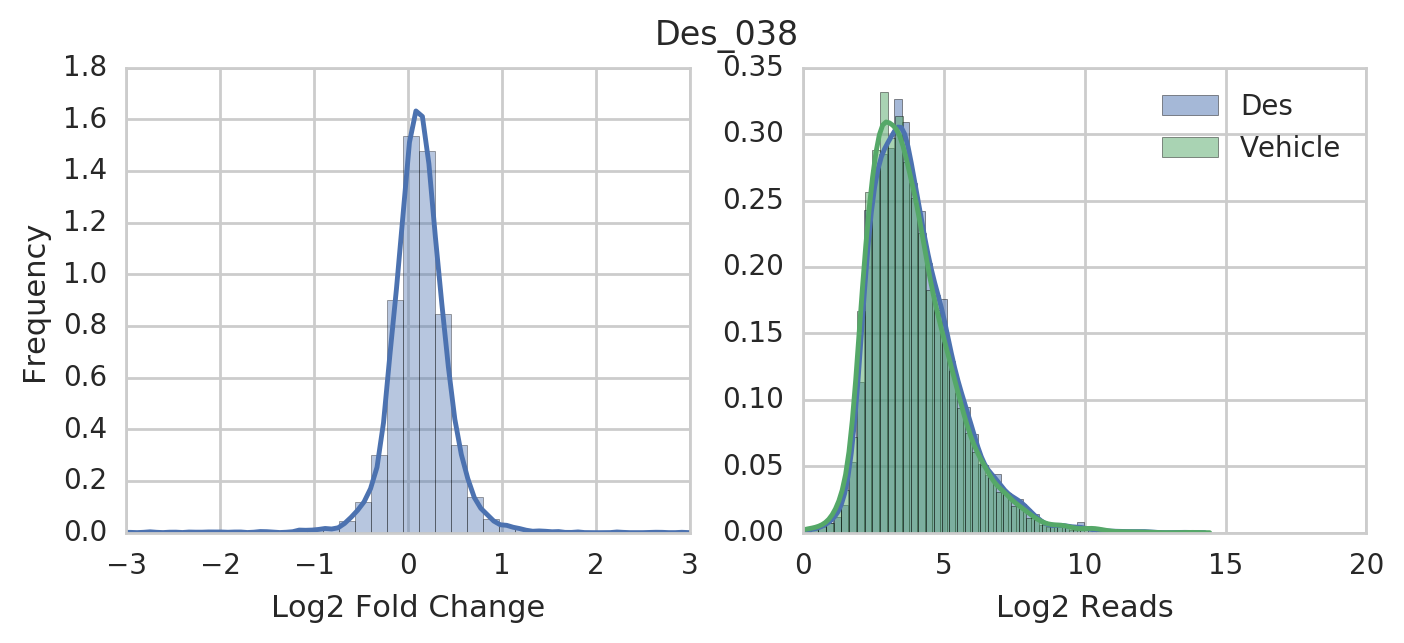

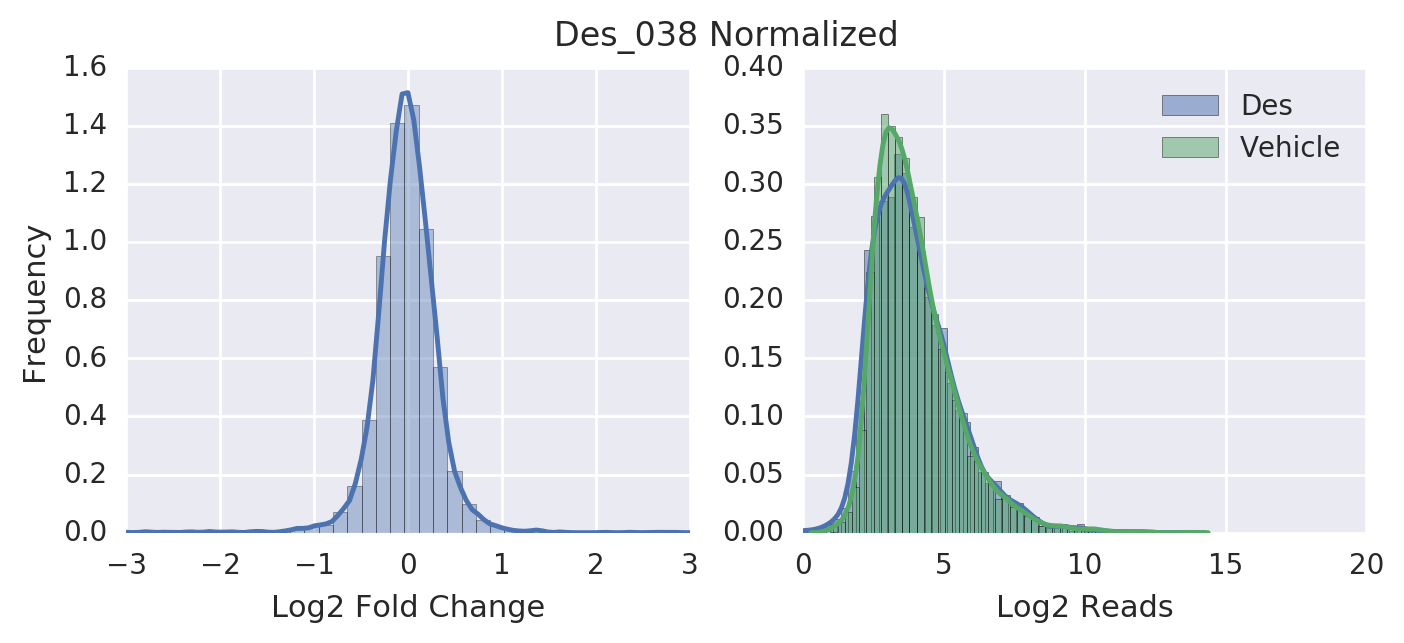

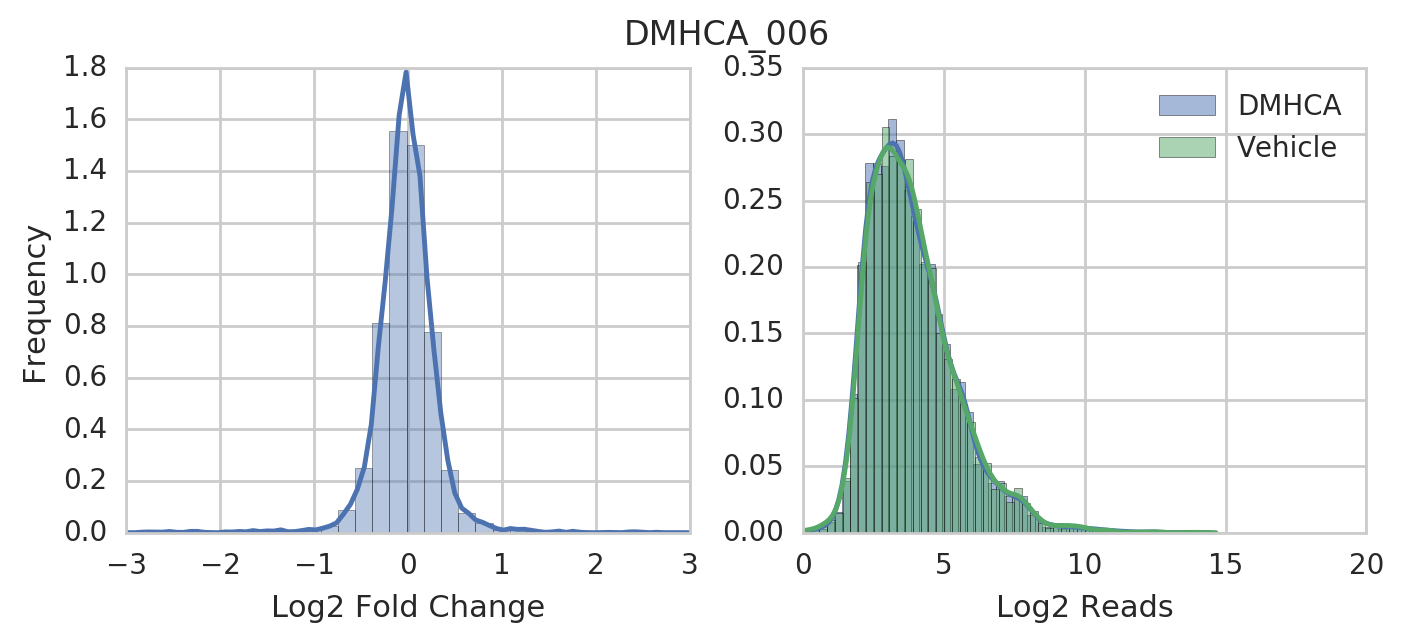

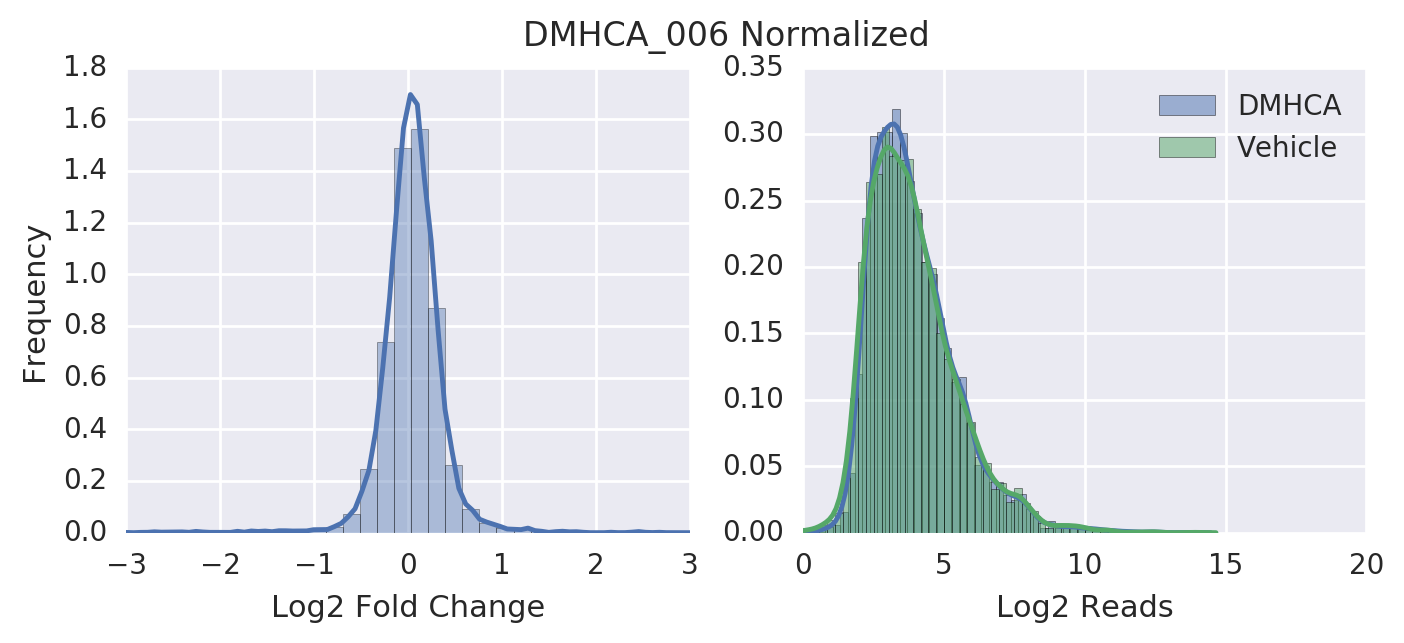

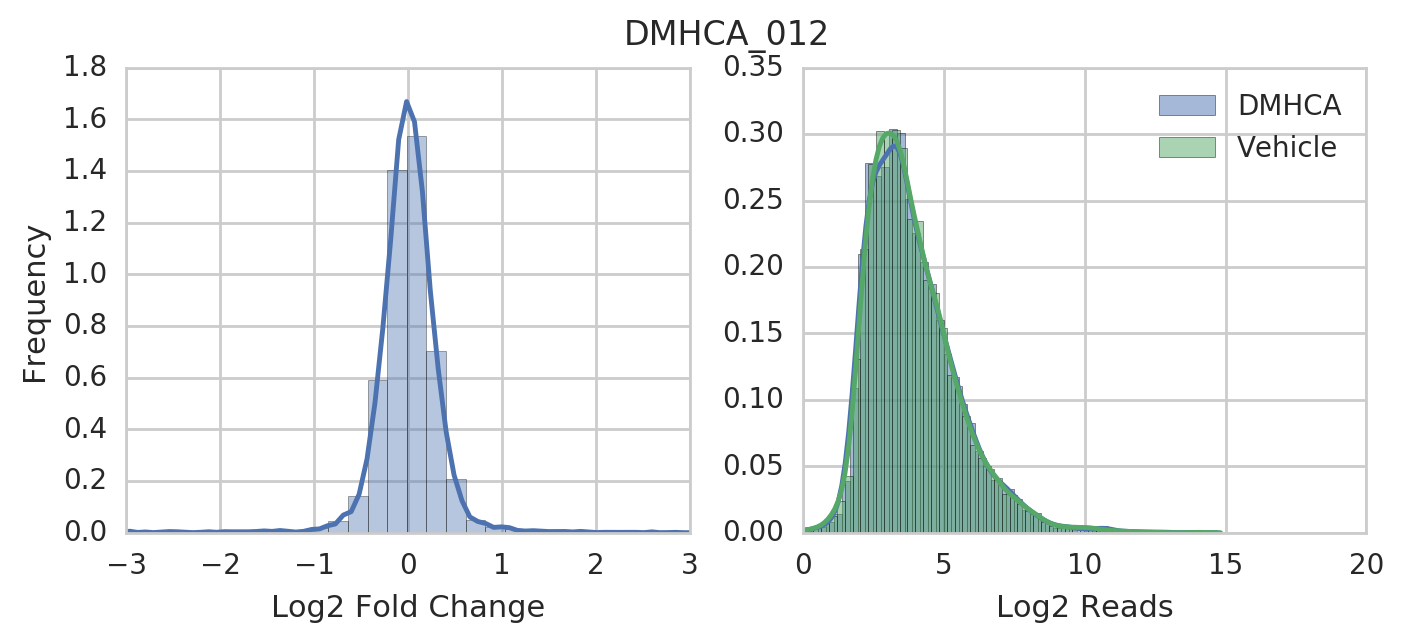

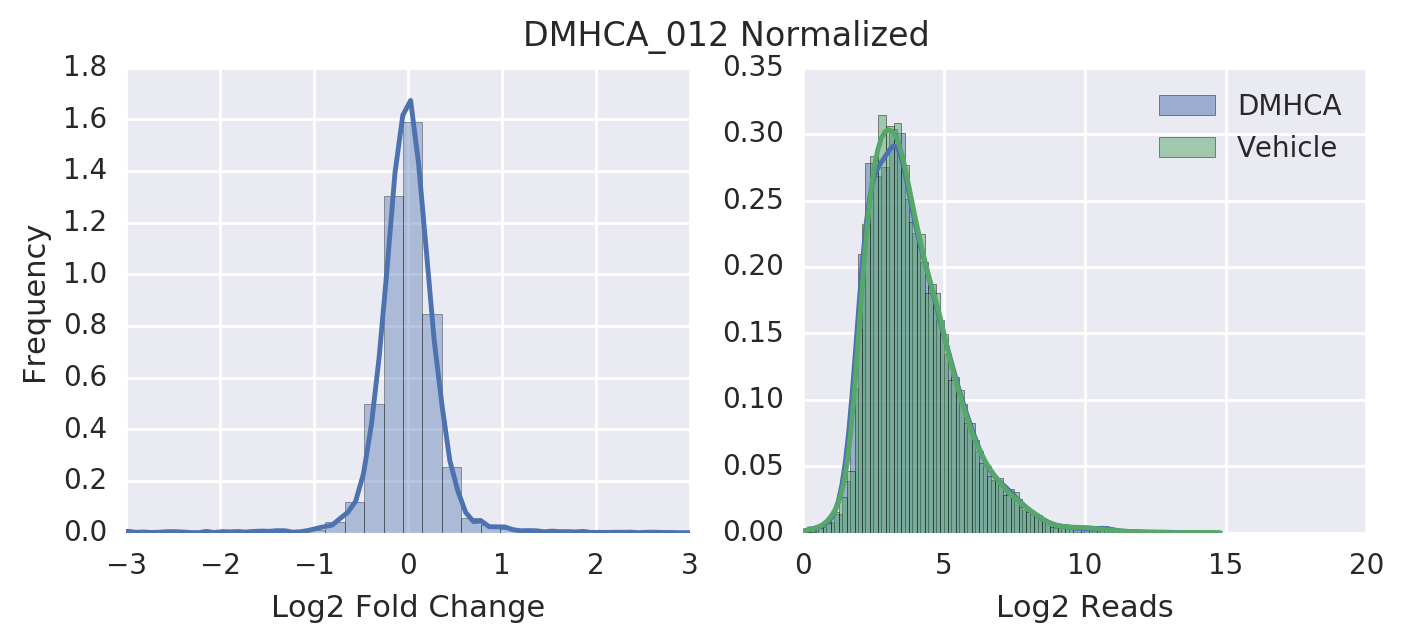

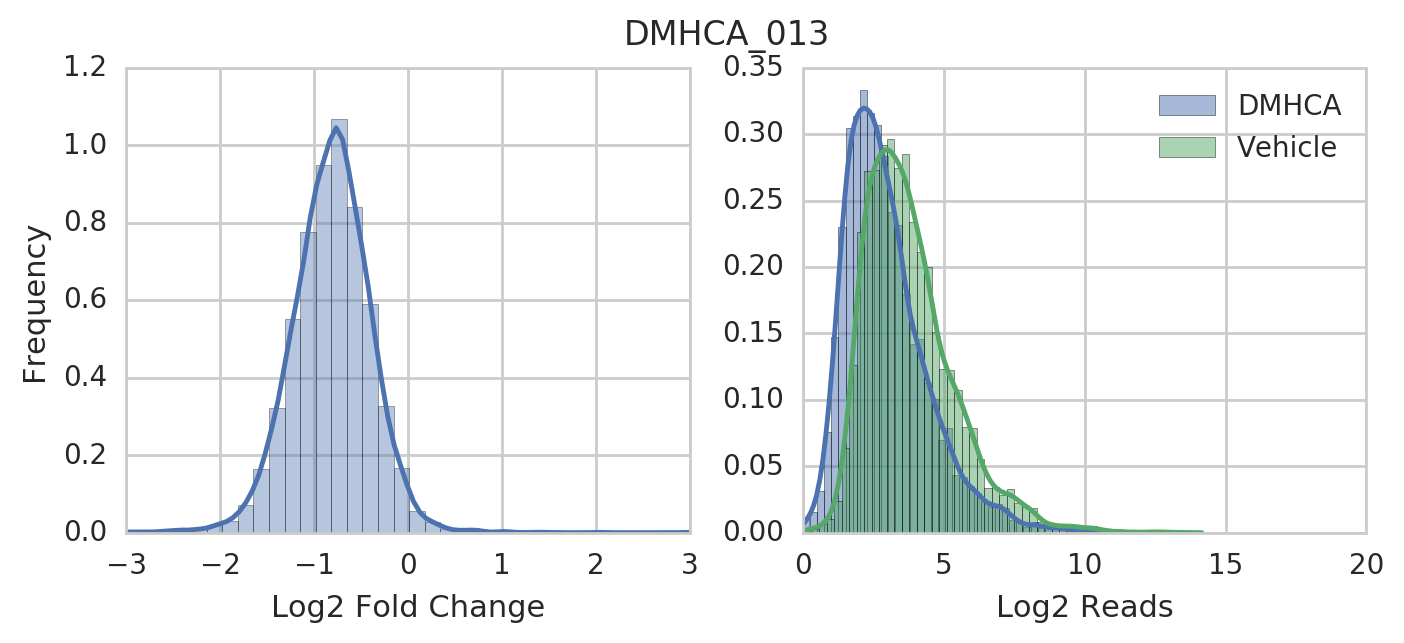

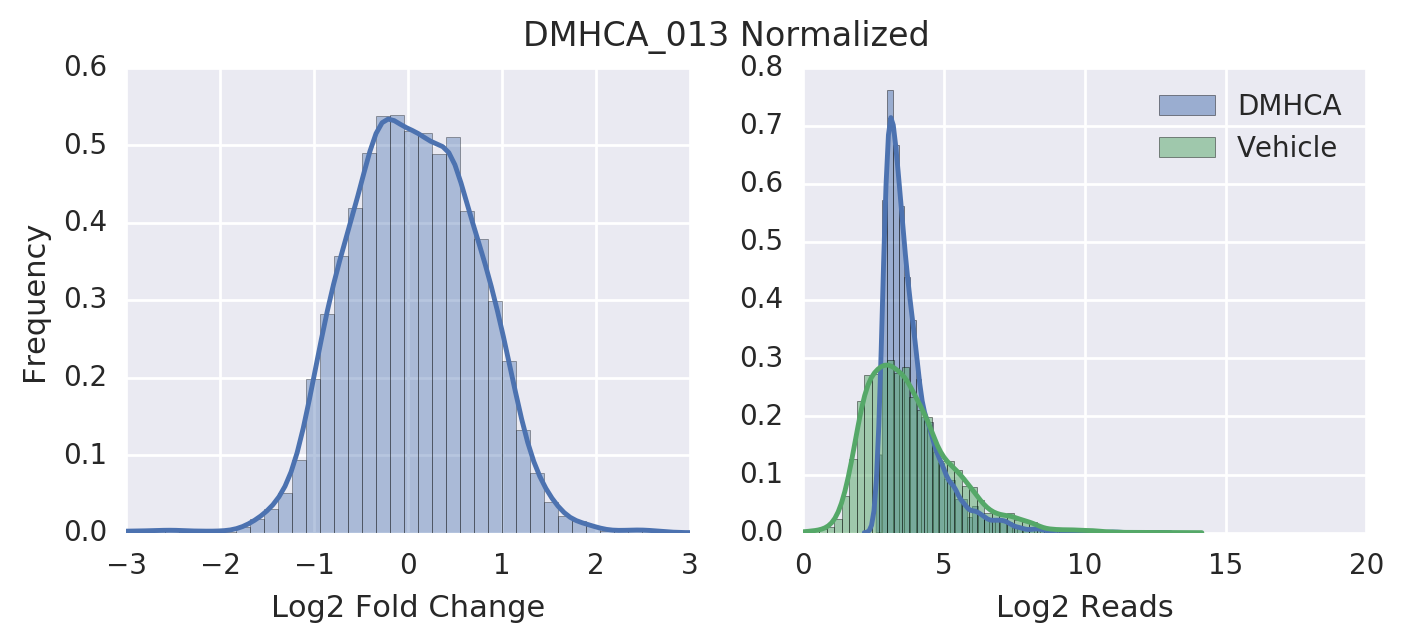

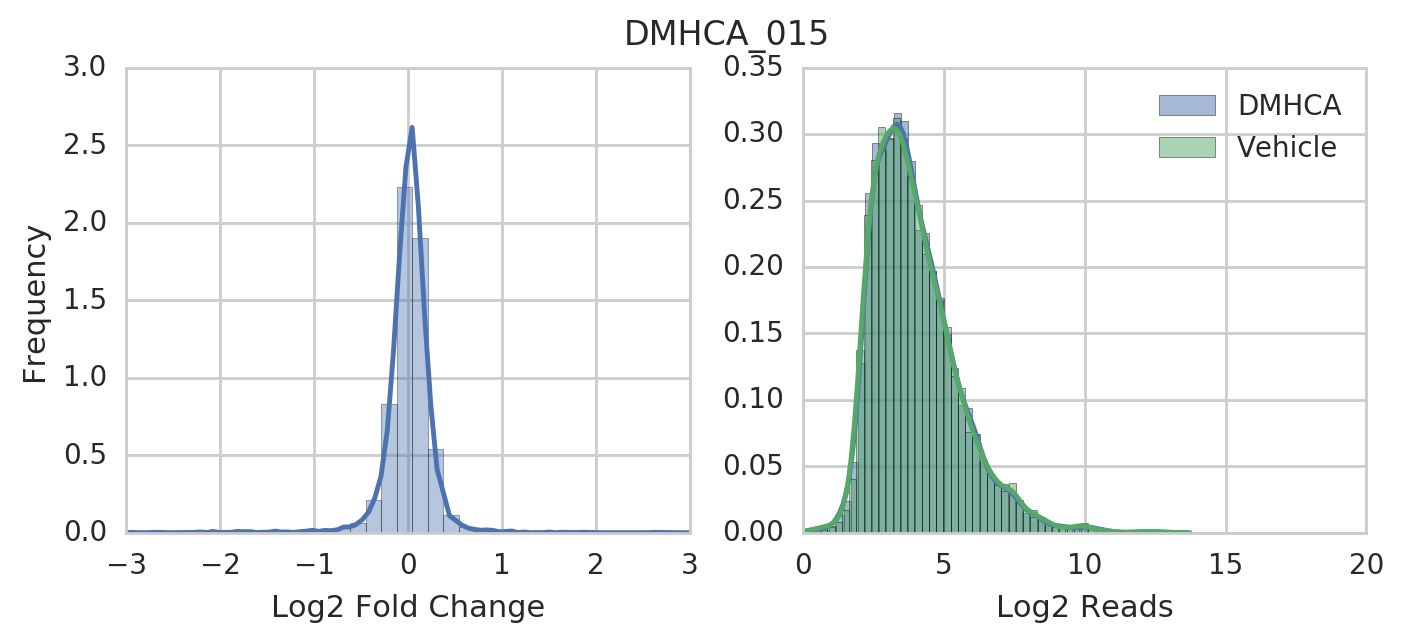

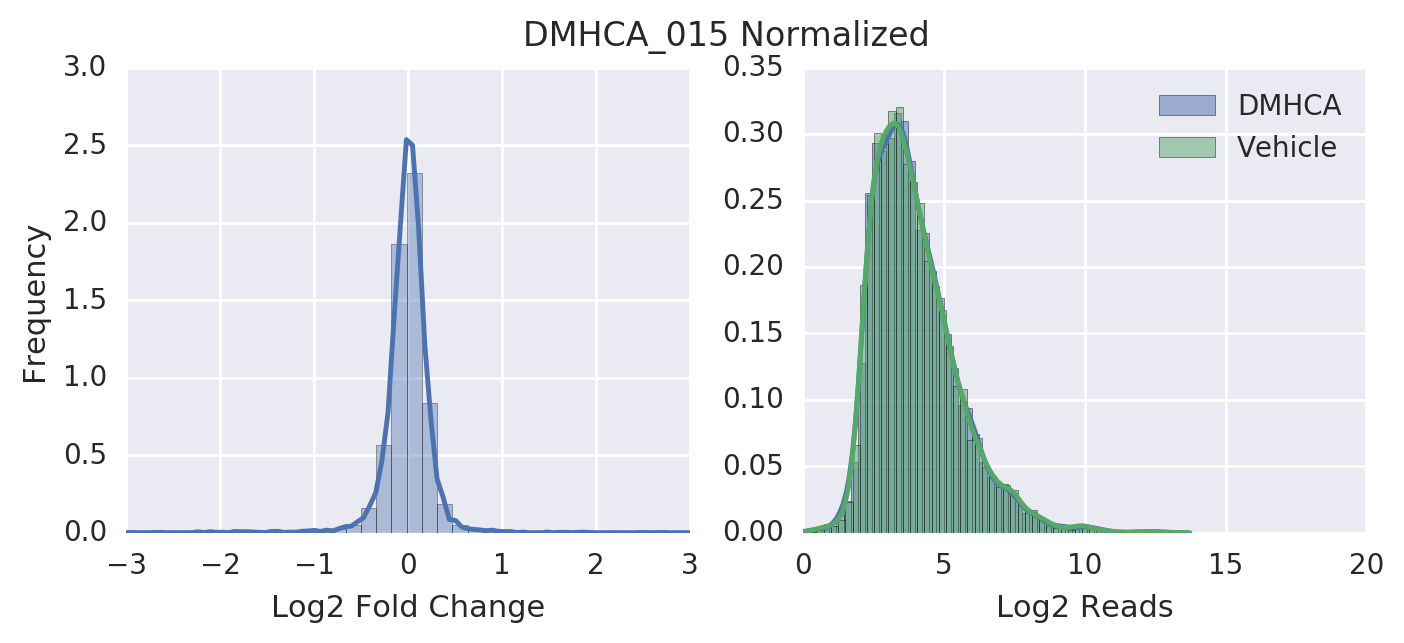

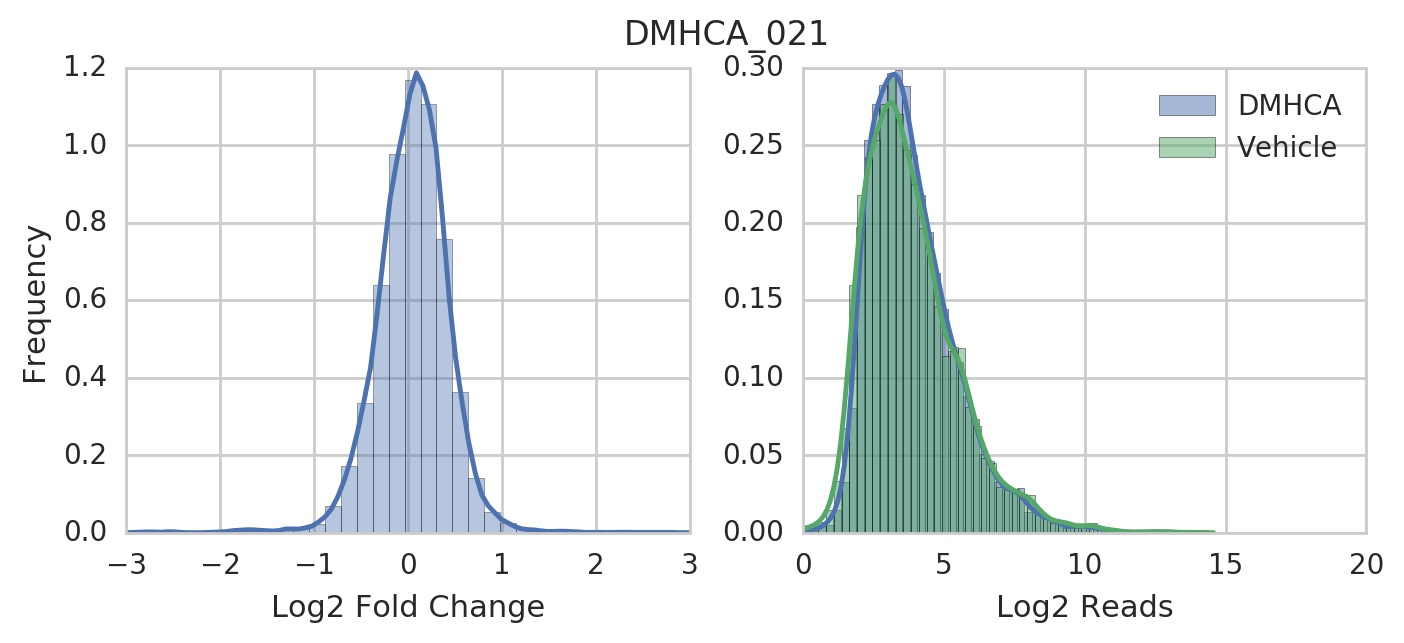

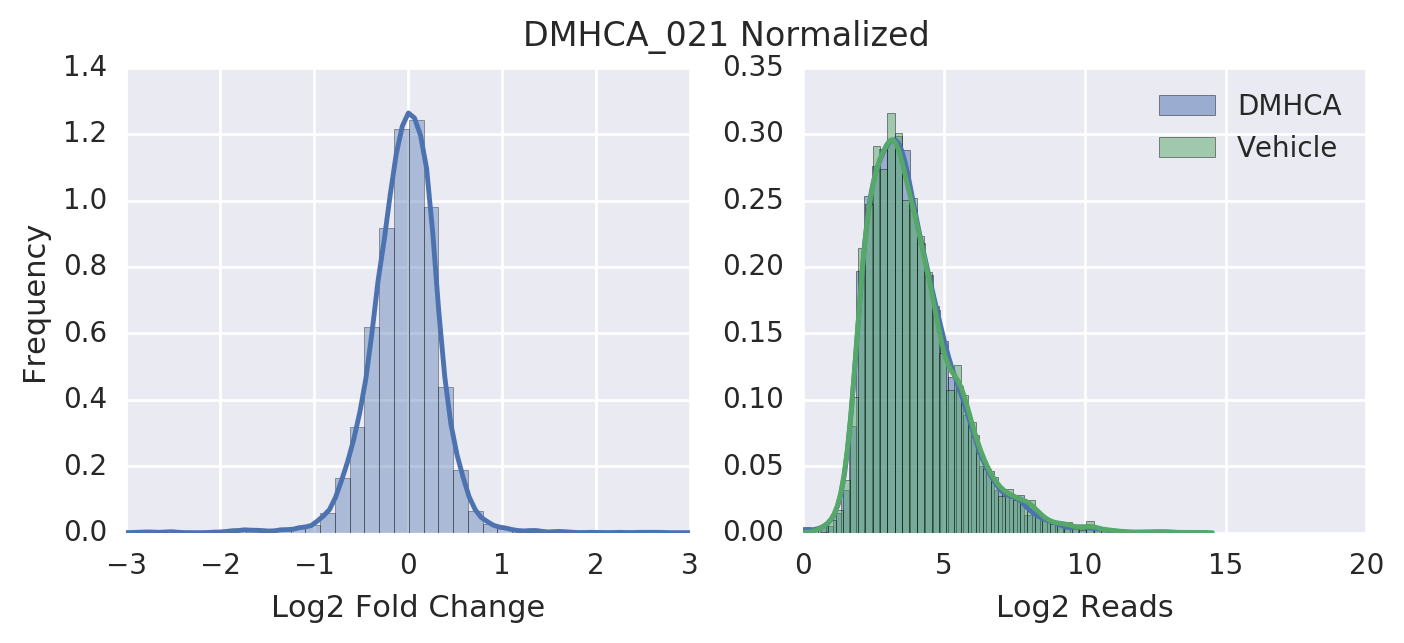

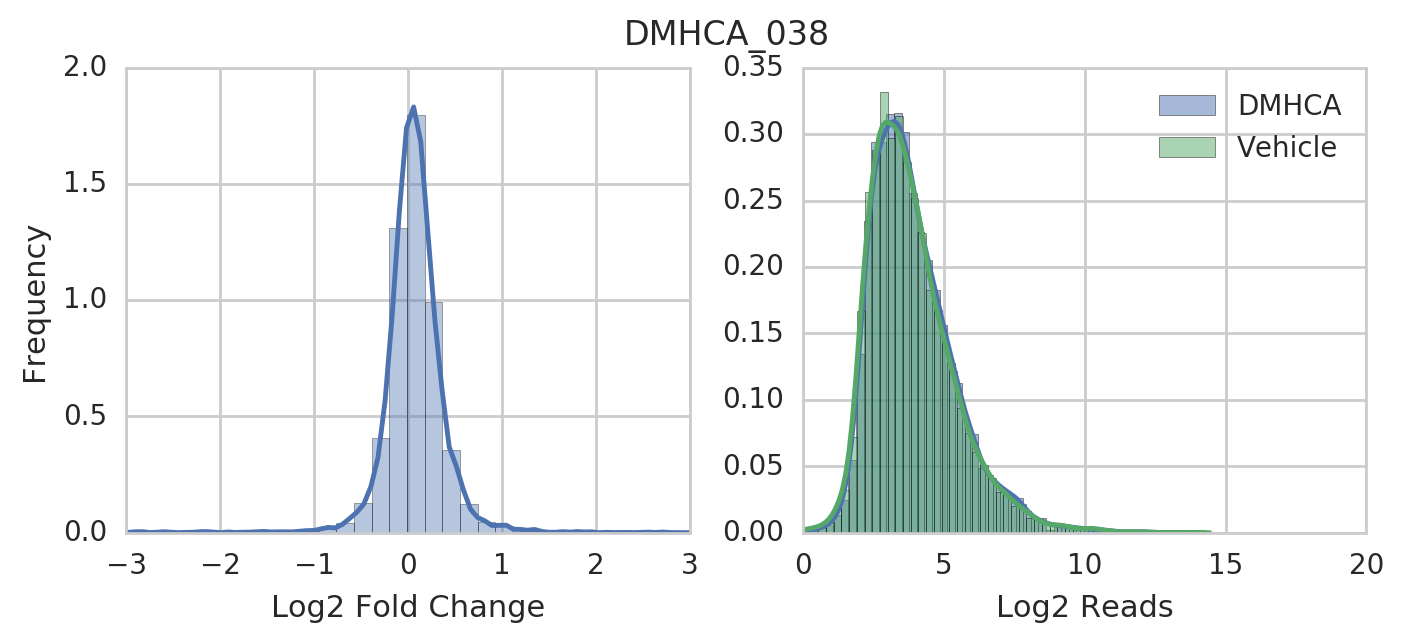

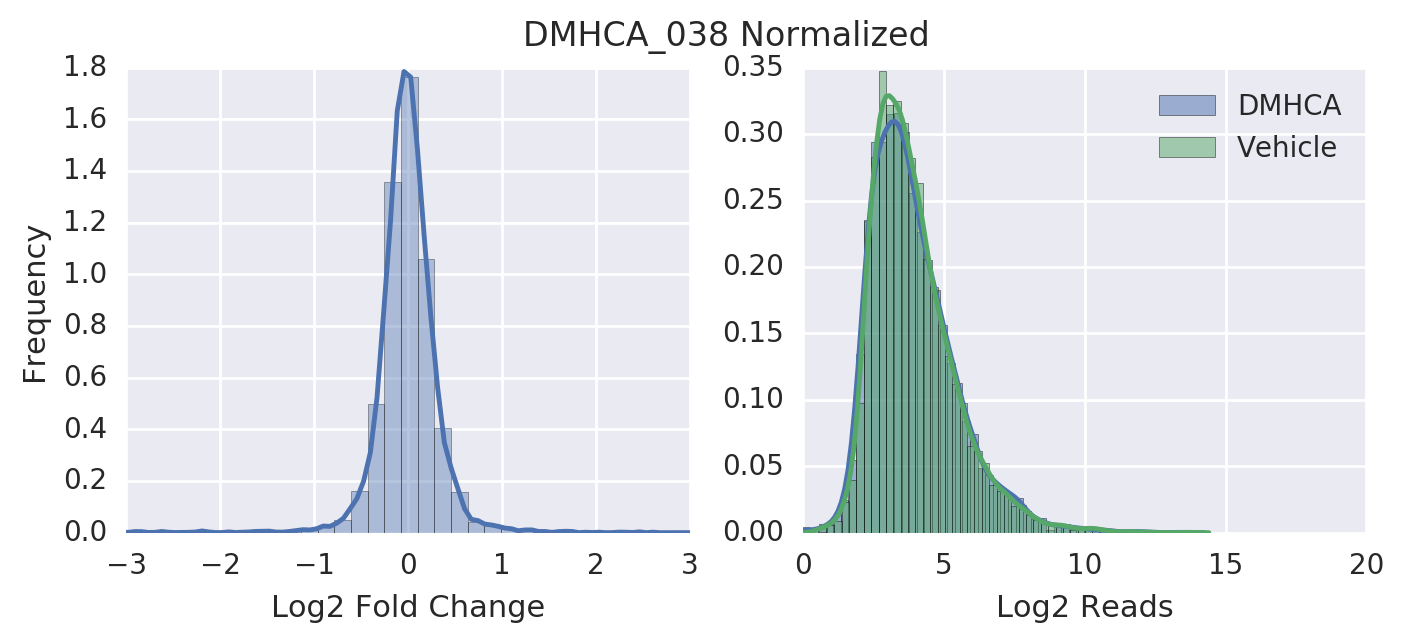

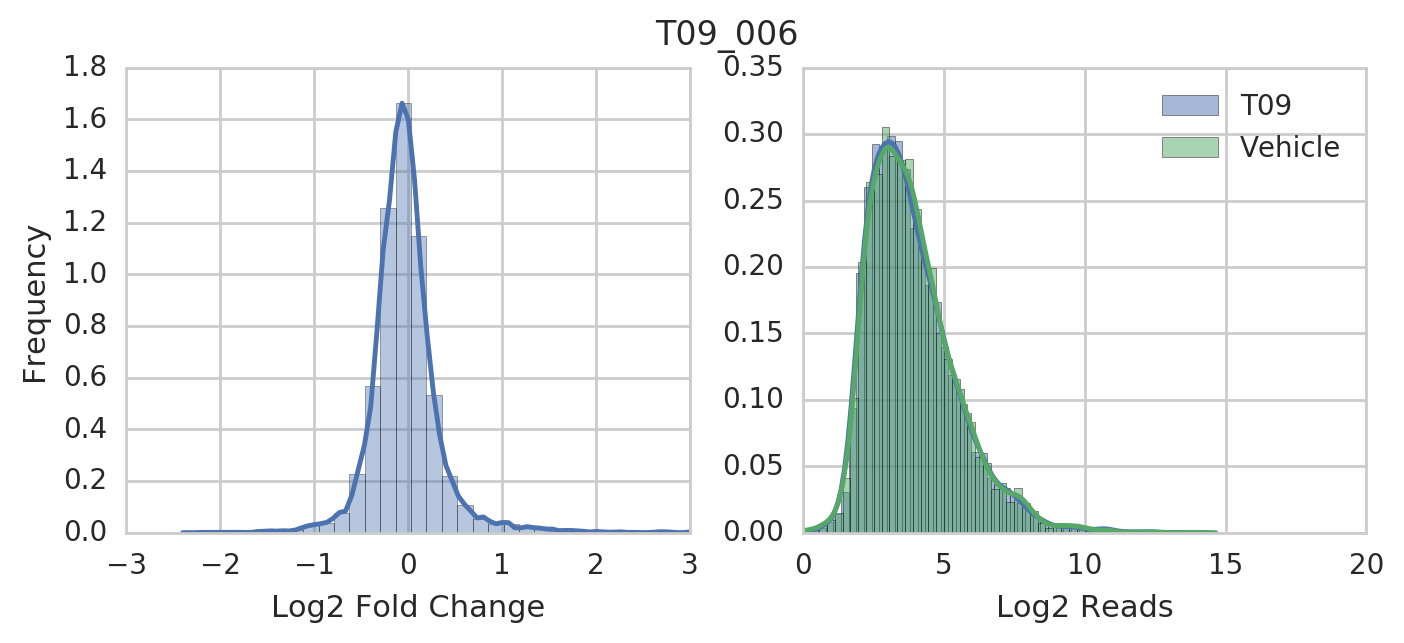

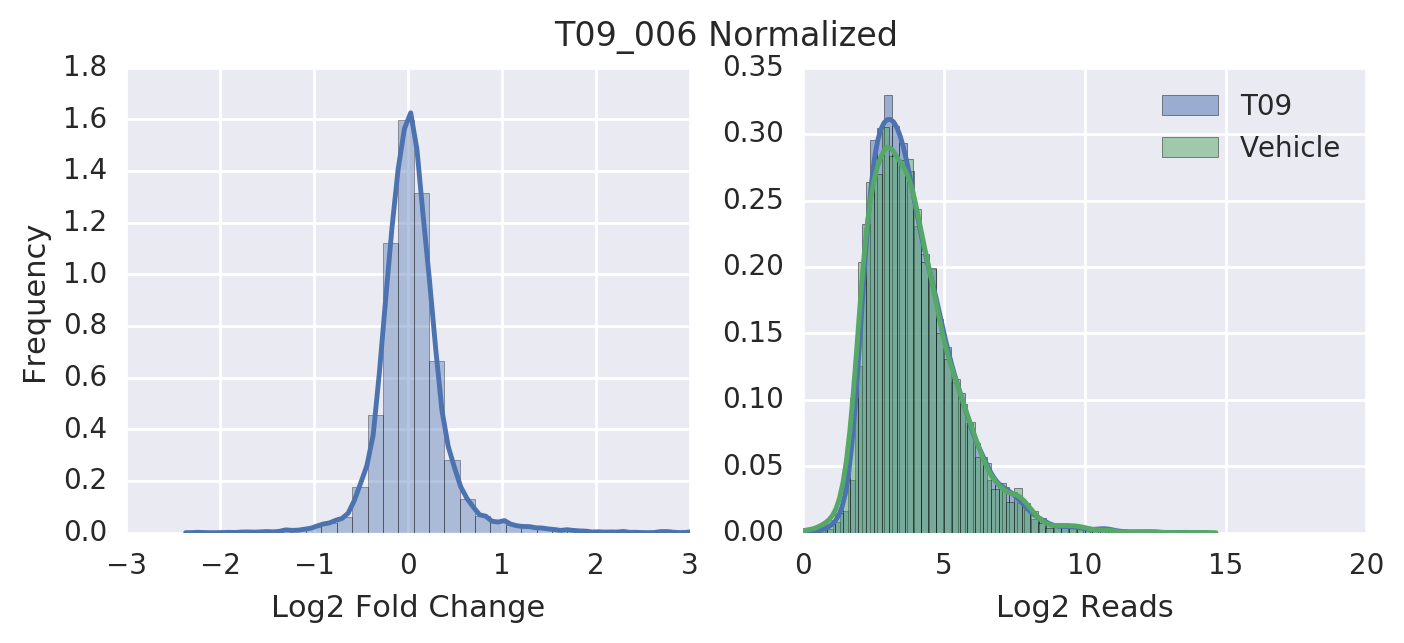

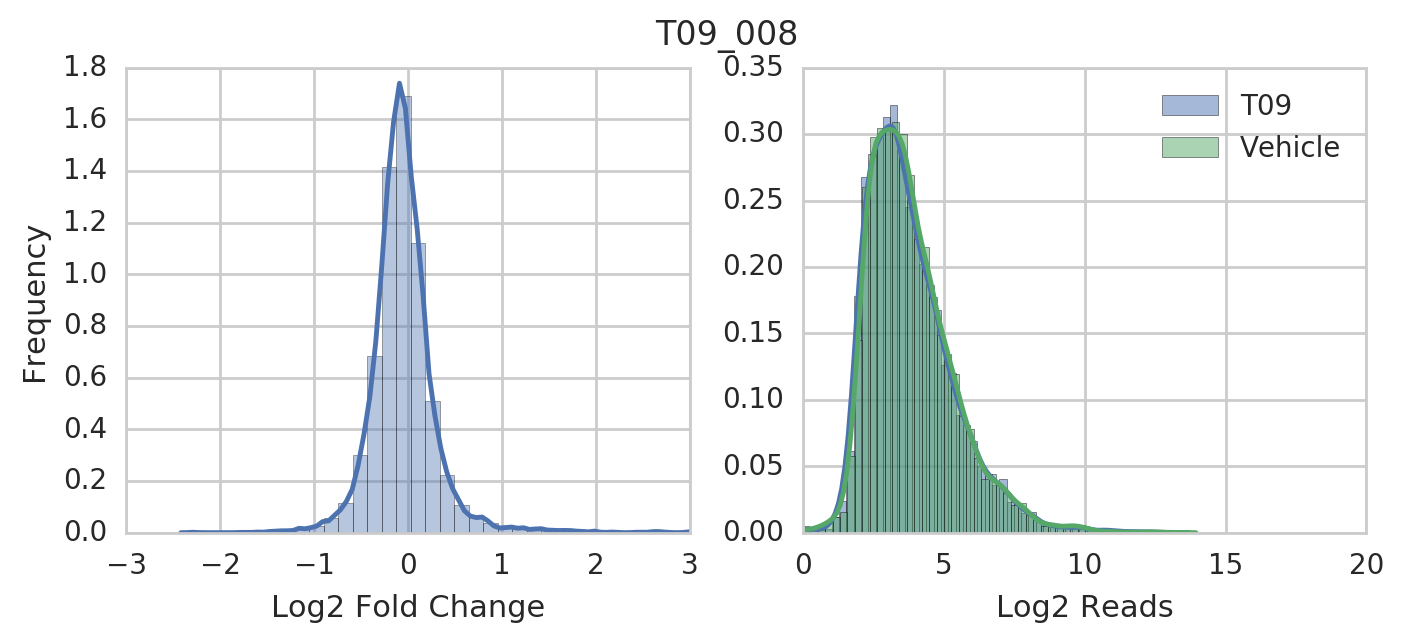

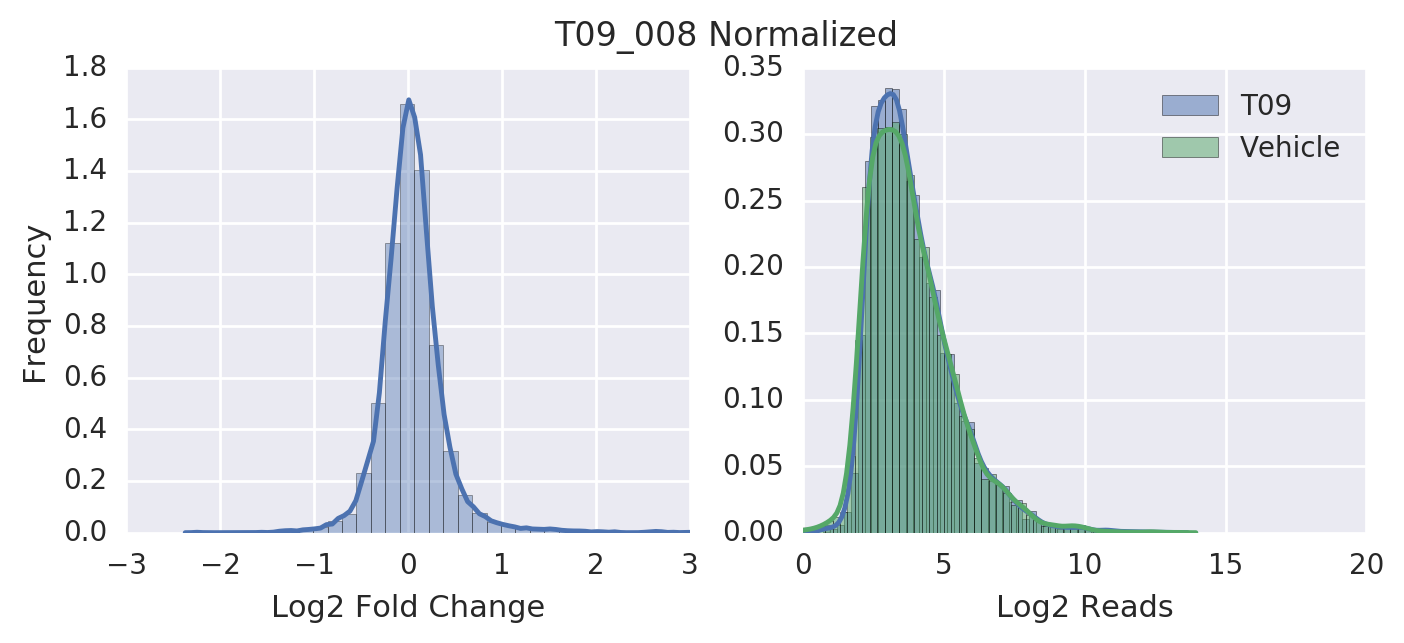

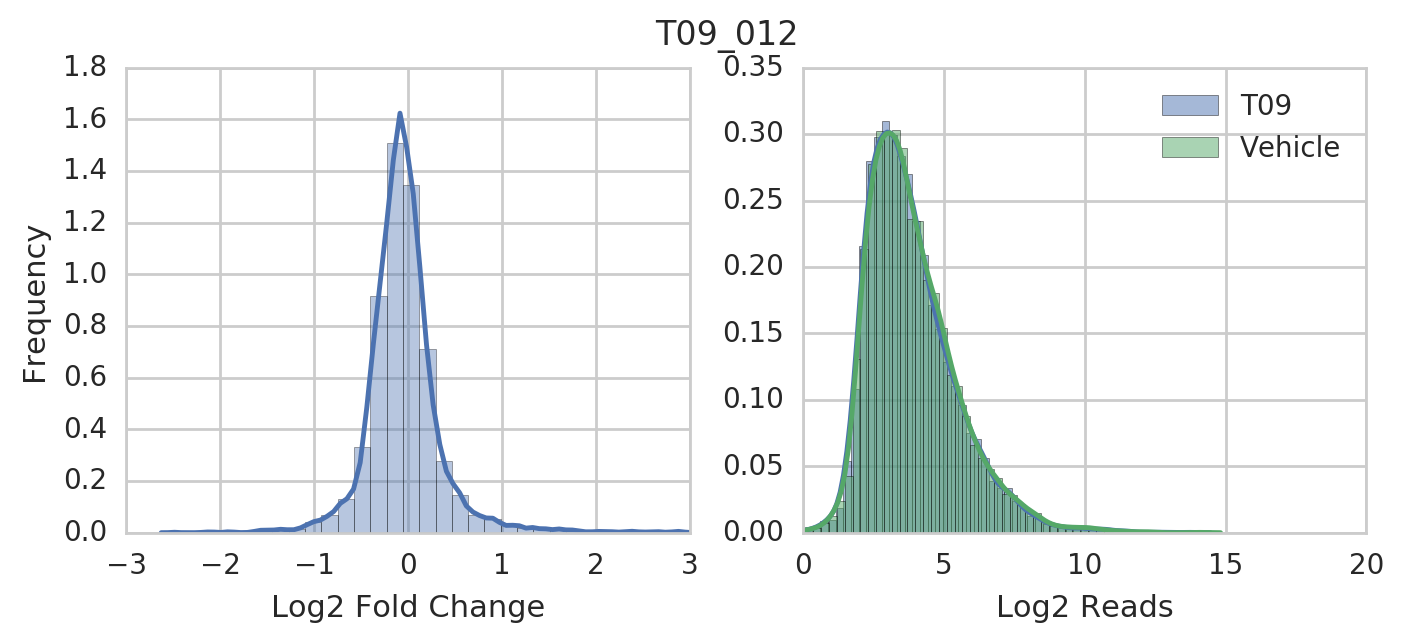

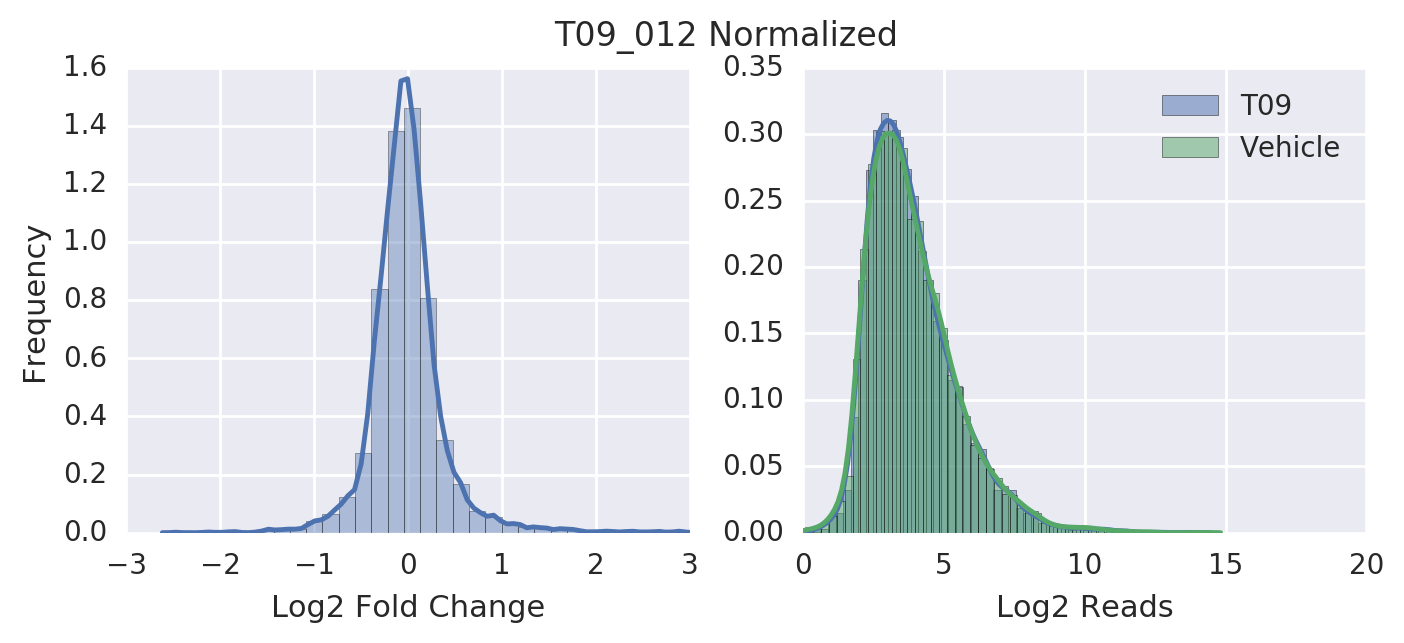

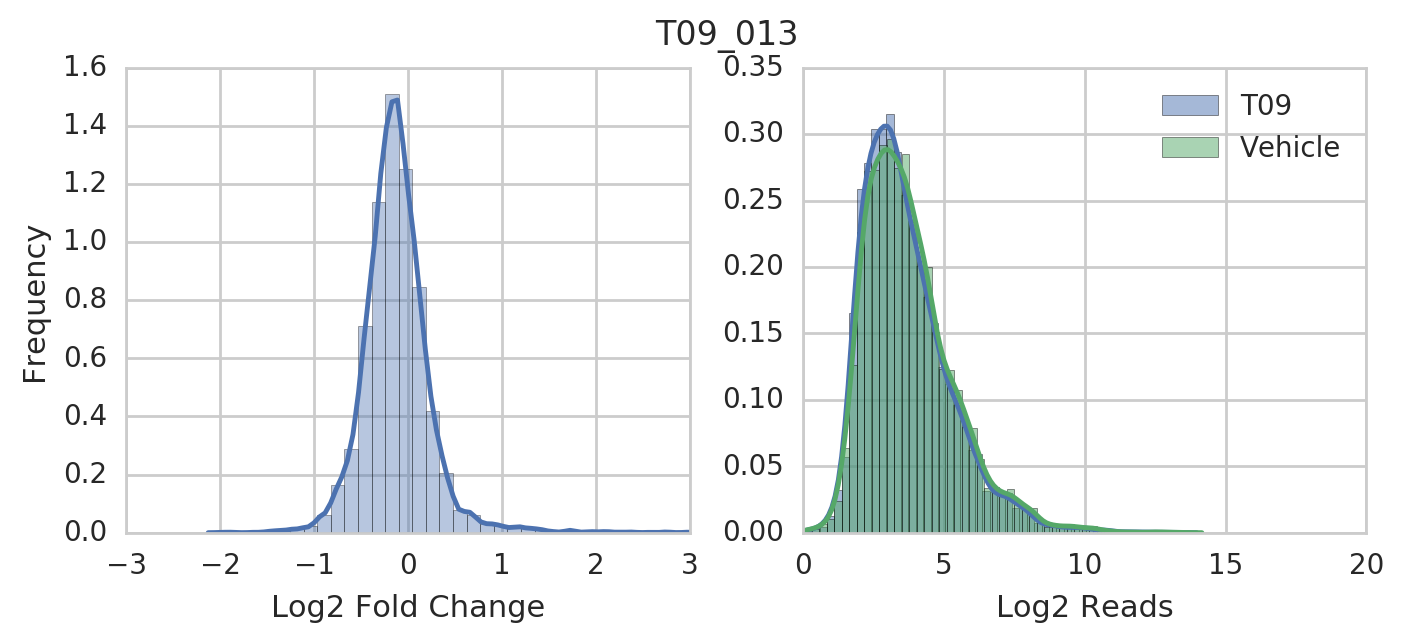

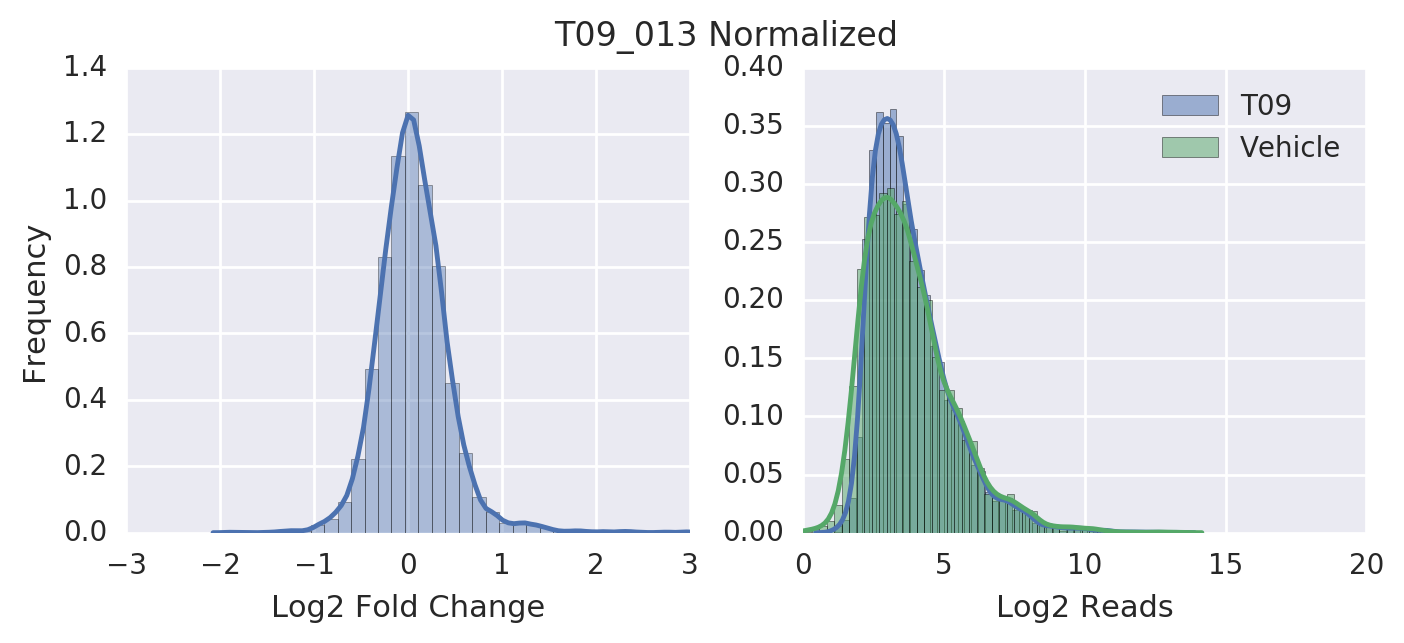

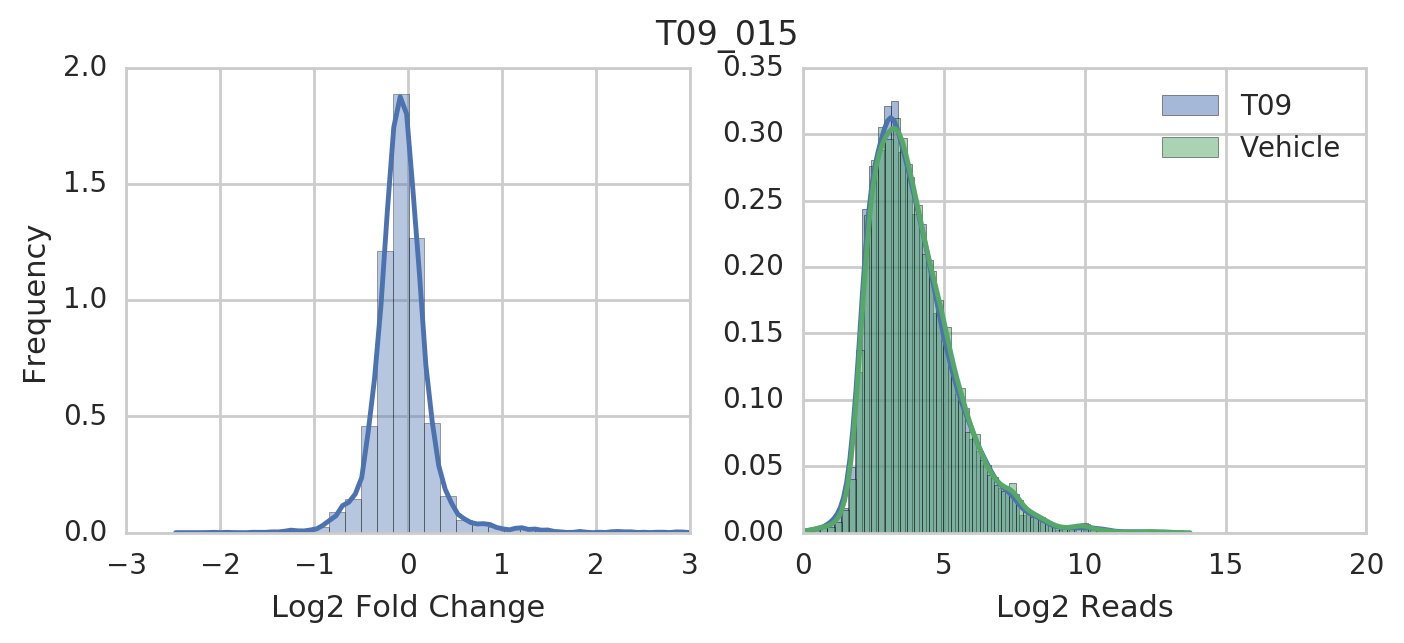

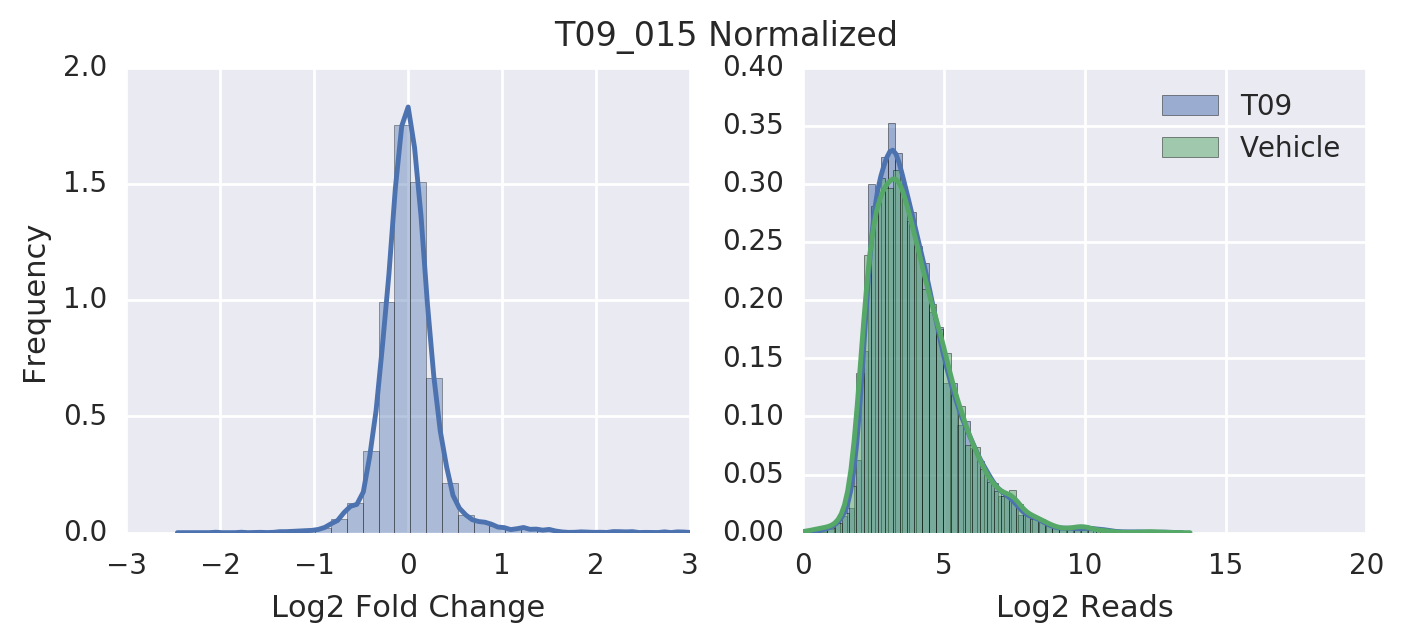

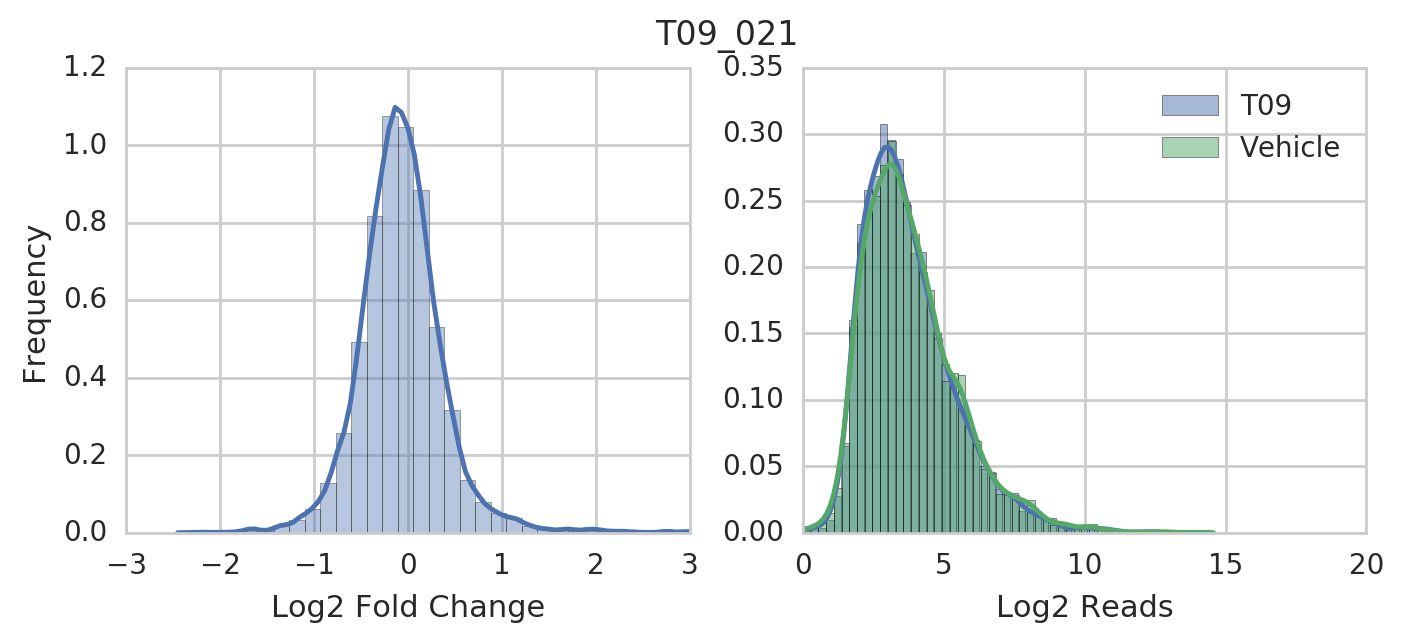

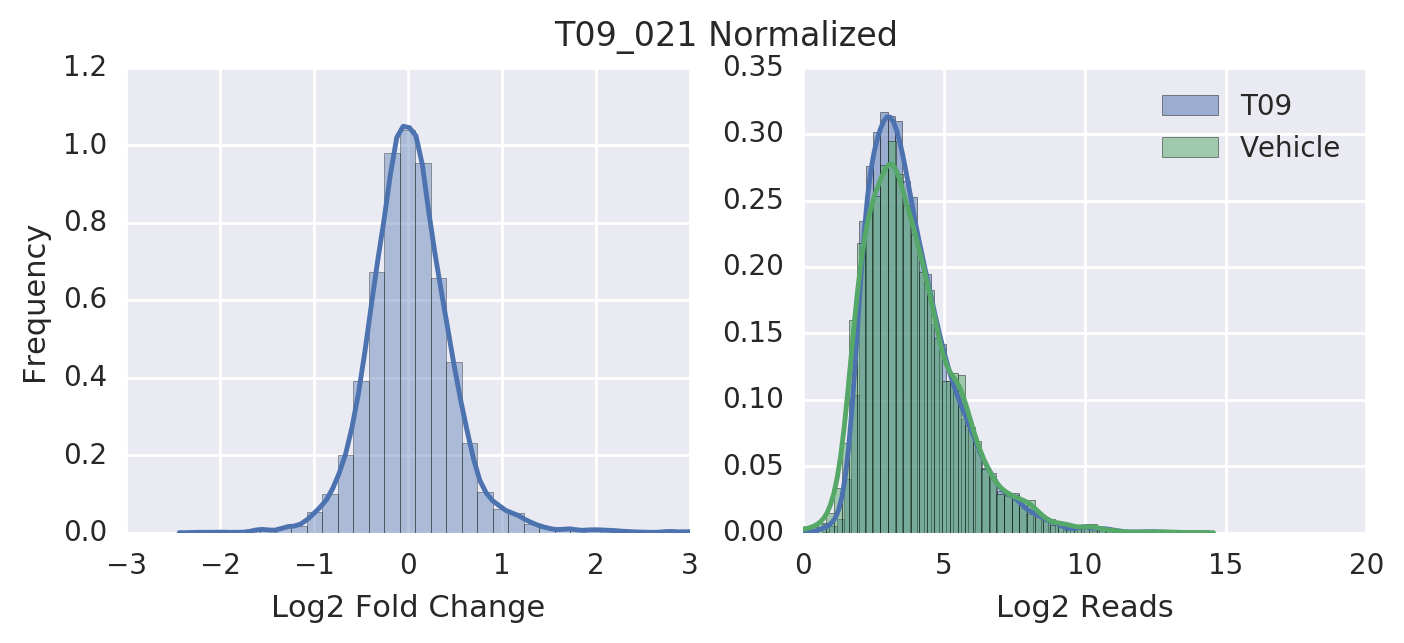

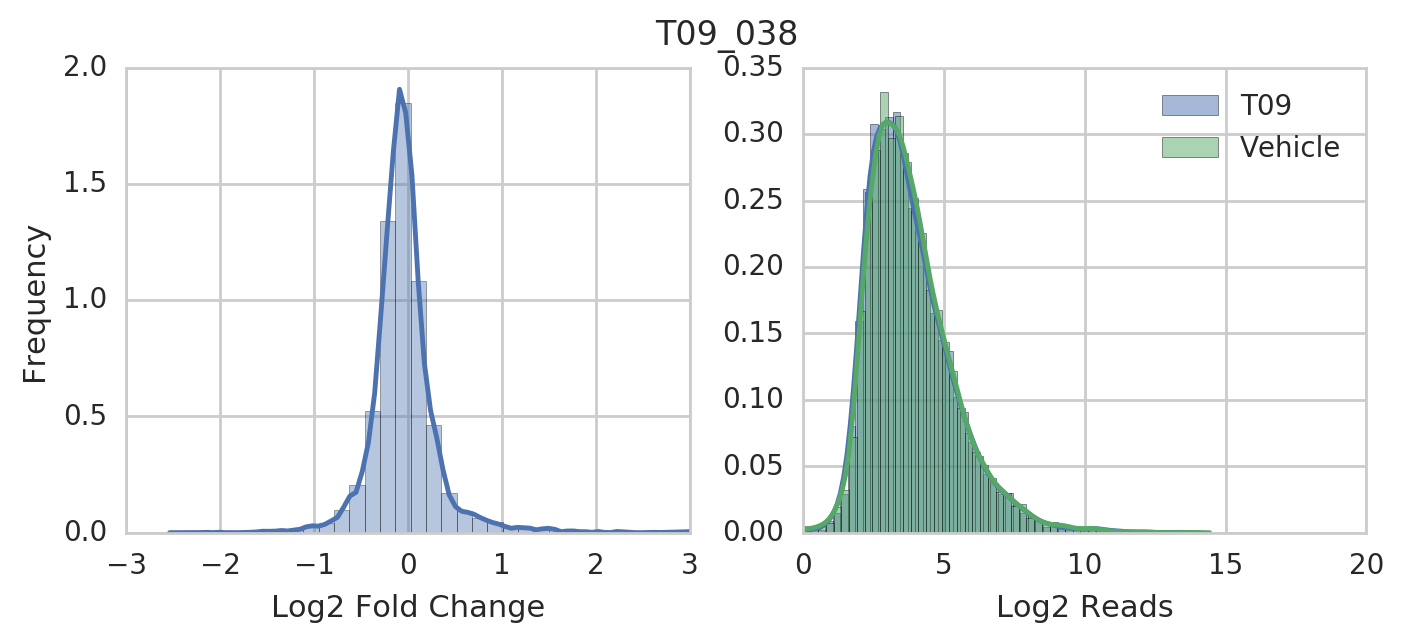

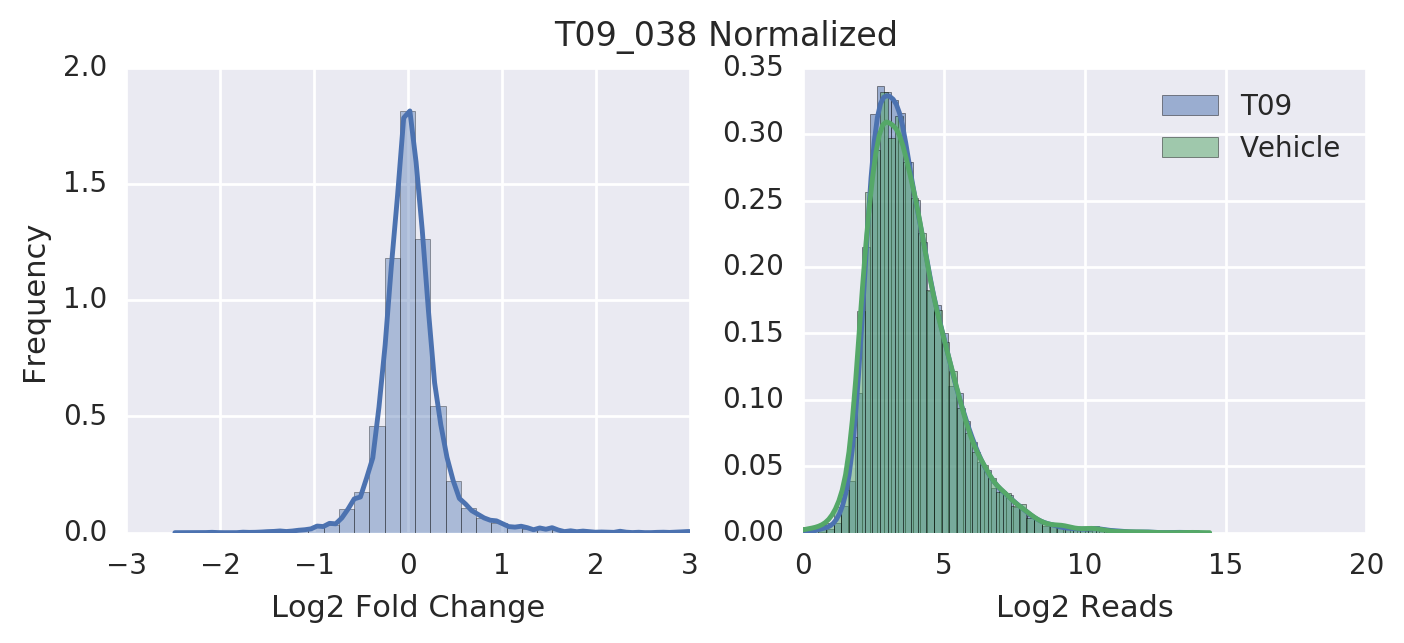

In [1446]:
genes = sorted(intersecting_genes)
column_vals_dict = {'gene':genes}
# for treatment in sorted(treatment_sample_human_frame.columns.values):
for treatment in ['Des', 'DMHCA', 'T09']:
    if treatment == 'Vehicle':
        break
    for sample in treatment_sample_human_frame.index.values:
        if treatment_sample_human_frame.ix[sample,'Vehicle']:
            if treatment_sample_human_frame.ix[sample,treatment]:
                # uncorrected plots
                with sns.axes_style('whitegrid'):
                    plt.figure(figsize=(8,3))
                    # plot fold change distribution
                    plt.subplot(1,2,1)
                    treated_vals = rpkm_human_frame[treatment + '_' + sample]
                    vehicle_vals = rpkm_human_frame['Vehicle_'+sample]
                    
                    fold_change = (treated_vals +1) / (vehicle_vals +1)
                    fold_change = np.log2(fold_change)
                    sns.distplot(fold_change)
                    plt.xlabel('Log2 Fold Change')
                    plt.ylabel('Frequency')
                    plt.xlim(-3,3)

                    # plot rpkm distribution
                    plt.subplot(1,2,2)
                    sns.distplot(np.log2(treated_vals +1), hist_kws={'alpha':0.5}, label=treatment)
                    plt.xlim(0,10)
                    sns.distplot(np.log2(vehicle_vals +1), hist_kws={'alpha':0.5}, label='Vehicle')
                    plt.legend()
                    plt.xlim(0,20)
                    plt.xlabel('Log2 Reads')
                    plt.suptitle(treatment + '_' + sample)
                    plt.show()
                    plt.close()
                
                # corrected plots
                
#                 correct according to mean
                veh_mean = np.median(vehicle_vals)
                treated_mean = np.median(treated_vals)
                if veh_mean > treated_mean:
                    corrected_vehicle_vals = vehicle_vals
                    corrected_treated_vals = treated_vals + (veh_mean - treated_mean)
                else:
                    corrected_vehicle_vals = vehicle_vals+ (treated_mean - veh_mean)
                    corrected_treated_vals = treated_vals
#                 corrected_vehicle_vals, corrected_treated_vals = quantileNormalize(vehicle_vals, treated_vals)
                with sns.axes_style('darkgrid'):
                    plt.figure(figsize=(8,3))
                    plt.subplot(1,2,1)
                    fold_change = (corrected_treated_vals +1) / (corrected_vehicle_vals +1)
                    fold_change = np.log2(fold_change)
                    sns.distplot(fold_change)
                    plt.xlabel('Log2 Fold Change')
                    plt.ylabel('Frequency')
                    plt.xlim(-3,3)

                    # plot rpkm distribution
                    plt.subplot(1,2,2)
                    sns.distplot(np.log2(corrected_treated_vals +1), hist_kws={'alpha':0.5}, label=treatment)
                    plt.xlim(0,10)
                    sns.distplot(np.log2(corrected_vehicle_vals +1), hist_kws={'alpha':0.5}, label='Vehicle')
                    plt.legend()
                    plt.xlim(0,20)
                    plt.xlabel('Log2 Reads')
                    plt.suptitle(treatment + '_' + sample + ' Normalized')
                    plt.show()
                

In [1414]:
import warnings
warnings.filterwarnings('ignore')

In [1604]:
fold_threshold = 2.0
ratio_threshold = 2.0
stats_frame = rpkm_human_frame[[]]
stats_frame['gene'] = rpkm_human_frame.index.values
distance_threshold = fold_threshold - 1
fold_change_frame = rpkm_human_frame[[]]
for treatment in ['Des', 'DMHCA', 'T09']:
    print(treatment)   
    foldChange_data = rpkm_human_frame[[]]
    for sample in selected_human_samples:
        if treatment_sample_human_frame.ix[sample,'Vehicle']:
            if treatment_sample_human_frame.ix[sample,treatment]:
                sample_genes_dict[sample] = set()
                treated_vals = rpkm_human_frame[treatment + '_' + sample]
                vehicle_vals = rpkm_human_frame['Vehicle_'+sample]
                
                # normalize values
#                 corrected_vehicle_vals, corrected_treated_vals = quantileNormalize(vehicle_vals, treated_vals)
                corrected_vehicle_vals = vehicle_vals
                corrected_treated_vals = treated_vals
                
                #calculate fold change
                fold_change = np.log2((corrected_treated_vals +1) / (corrected_vehicle_vals +1)                 )
                foldChange_data[treatment + '_' + sample] = fold_change
                fold_change_frame[treatment + '_' + sample] = fold_change
    mads = []
    medians = []
    vals = foldChange_data.values
    current_diff_genes = []
    for i in range(len(current_genes)):
        current_vals = vals[i]
        current_mad = calcMAD(current_vals)
        mads.append(current_mad)
        median = np.median(current_vals)
        medians.append(median)

    stats_frame[treatment + ' Median Log2 FC'] = medians
    stats_frame[treatment + ' Log2 FC MAD'] = mads


Des
DMHCA
T09


In [1605]:
### wilcoxon rank test
treatment_gene_wilcoxon_dict = {x:set() for x in ['Des', 'DMHCA', 'T09']}
for treatment in ['Des', 'DMHCA', 'T09']:
    pvals = []
    for gene in rpkm_human_frame.index.values:
        veh_vals = rpkm_human_frame.ix[gene, ['Vehicle_' + x for x in selected_human_samples]].values
        treatment_vals = rpkm_human_frame.ix[gene, [treatment + '_' + x for x in selected_human_samples]].values
        stat, p = scipy.stats.wilcoxon(veh_vals, treatment_vals)
        pvals.append(p)
    stats_frame[treatment + ' Wilcoxon p-value'] = pvals
stats_frame = stats_frame[sorted(stats_frame.columns.values)]

In [1606]:
### find significant genes
# condition_significantGenes_dict = {}
ratio_threshold = 2.0
fold_threshold = abs(np.log2(2.0))
p_threshold = 0.05
for treatment in ['Des', 'DMHCA', 'T09']:
    
    significant_frame = stats_frame[(stats_frame[treatment + ' Median Log2 FC'].abs() > fold_threshold) &
                                    (stats_frame[treatment + ' Wilcoxon p-value'] < p_threshold)]
    significant_frame[treatment + ' Effect/Variance Ratio'] = \
        significant_frame[treatment + ' Median Log2 FC'].abs()/significant_frame[treatment + ' Log2 FC MAD']
    significant_frame = significant_frame[significant_frame[treatment + ' Effect/Variance Ratio'] > ratio_threshold]
    significant_frame = significant_frame.sort(treatment + ' Effect/Variance Ratio')

    up_genes = significant_frame[significant_frame[treatment + ' Median Log2 FC'] > 0].index.values
    down_genes = significant_frame[significant_frame[treatment + ' Median Log2 FC'] < 0].index.values
    condition_significantGenes_dict['humanMatched_'+treatment.lower()+'_up'] = set(up_genes)
    condition_significantGenes_dict['humanMatched_'+treatment.lower()+'_down'] = set(down_genes)
    print(treatment, significant_genes)

Des ['SLC44A2' 'MS4A6A' 'TPD52' 'SEMA6B' 'VEGFA' 'LY75' 'NCF1' 'PPARG' 'PRKCH'
 'C3' 'CD300LF' 'SLC2A1' 'CEBPD' 'MADD' 'PRNP' 'CARD14' 'MERTK' 'HPSE'
 'CDC42EP4' 'ACSL3' 'AKNA' 'FNDC3B' 'ARRDC3' 'MID1IP1' 'RAPGEF2' 'CD180'
 'FAM102B' 'MCU' 'CENPV' 'PNPLA2' 'TFPI' 'ADPGK' 'UTRN' 'CLEC4E' 'PKIG'
 'ACVRL1' 'PTGS1' 'CORO7-PAM16' 'PTGER2' 'P4HA1' 'PIK3CD' 'PLAUR'
 'FGFR1OP2' 'ATP11C' 'APOC2' 'GBP2' 'KLHL5' 'ACACA' 'ZNF436' 'FASN' 'PLTP'
 'HIF1A' 'NAGK' 'COQ2' 'DNASE2' 'CD300A' 'SEL1L3' 'NR1H3' 'TKT' 'PLA2G15'
 'TNS1' 'ZNF609' 'PKIB' 'CD82' 'TLR4' 'PREX1' 'TNFRSF21' 'HK2' 'RASA3'
 'ICAM1' 'FIG4' 'SLC29A1' 'THEMIS2' 'CD14' 'TMCC3' 'C1ORF54' 'PTK2'
 'SLC40A1' 'TRPV4' 'TM7SF3' 'CDCA7L' 'IQSEC1' 'TP53INP1' 'ABCD1' 'IL10RA'
 'EPN1' 'S1PR1' 'ACSL1' 'SDC3' 'SLC29A3' 'BCL2L1' 'MYLIP' 'RARA' 'CPNE2'
 'CXCL16' 'SREBF1' 'STOM' 'ABCA1' 'SCD' 'PLIN2' 'LPCAT3' 'CSF3R' 'TMEM135'
 'CFP' 'EEPD1' 'ARL4C' 'DHRS3' 'ABCG1' 'RAB20' 'CXCR4' 'TSPAN14' 'SMPDL3A'
 'NEURL2']
DMHCA ['SLC44A2' 'MS4A6A' 'TPD52' 'SEMA6B' 

### Show Overlap with Mouse Genes

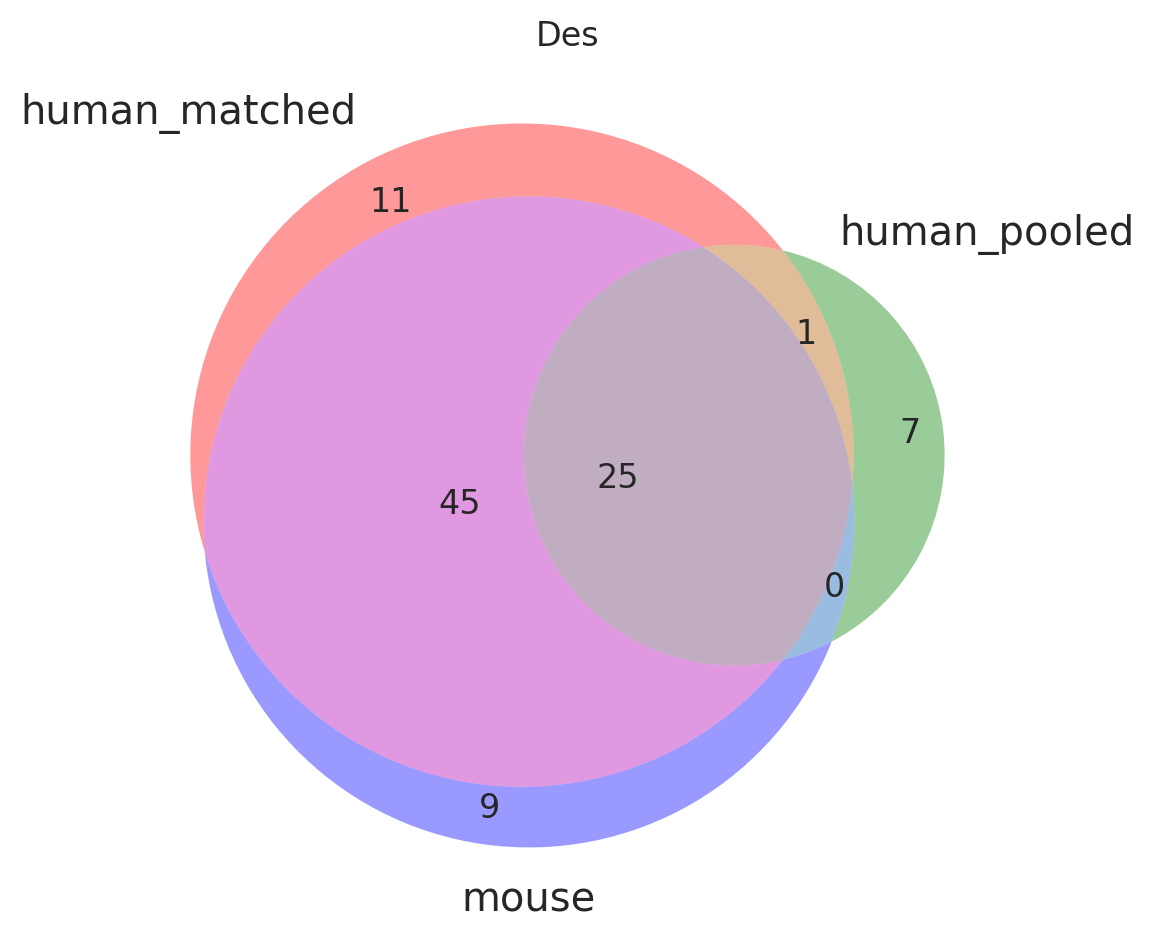

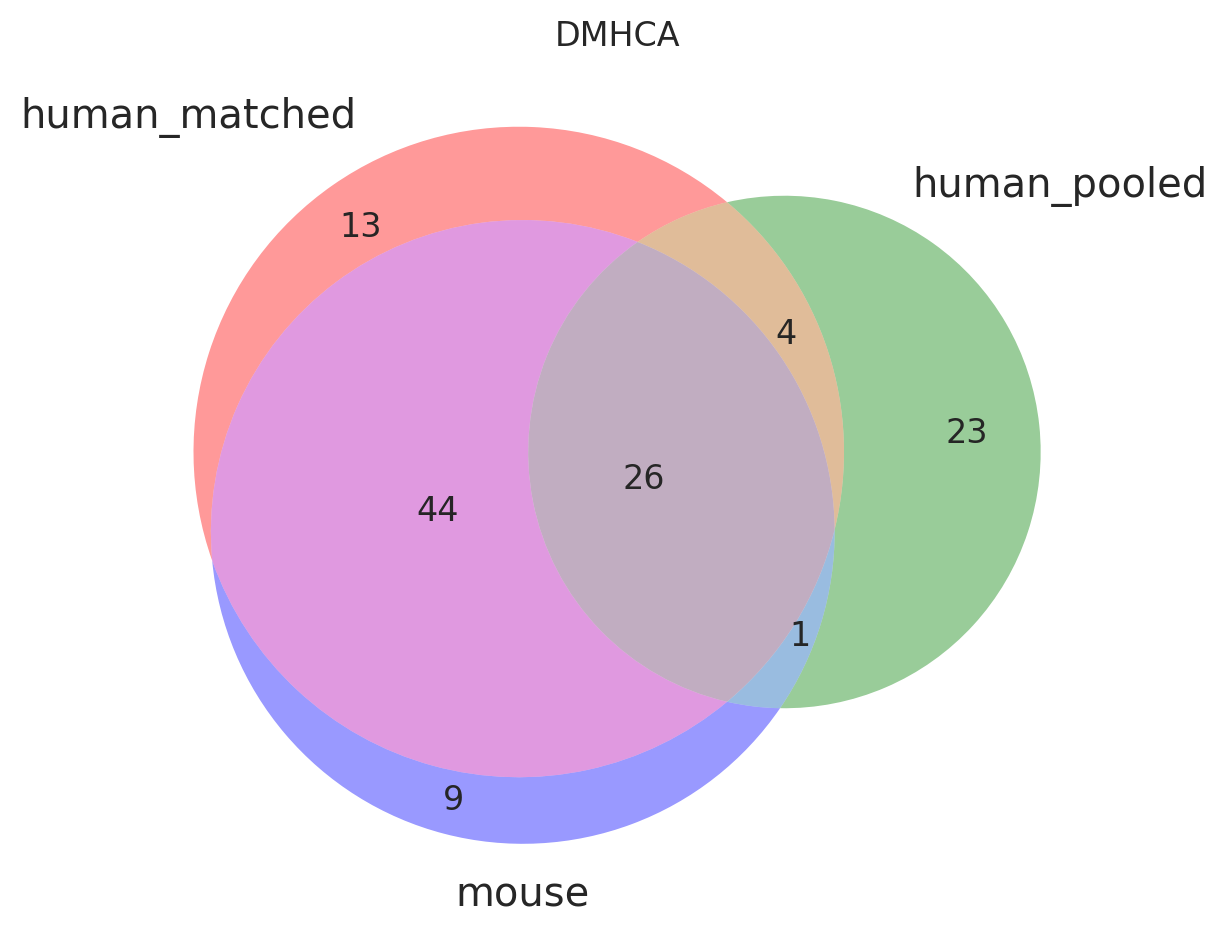

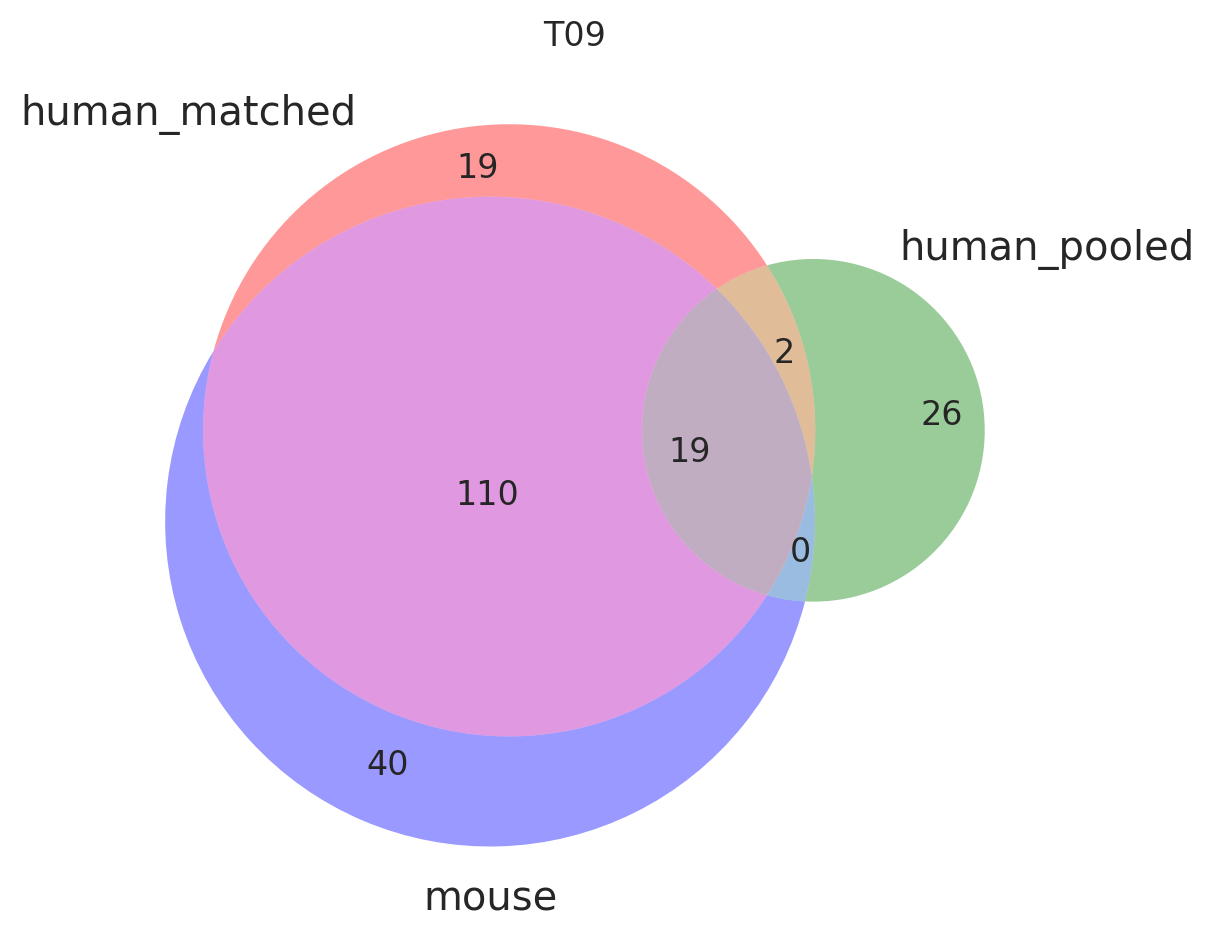

In [1607]:
for treatment in ['Des', 'DMHCA', 'T09']:
    mouse_genes_up = set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    mouse_genes_down = set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    
    mouse_genes = mouse_genes_up.union(mouse_genes_down)
    
    human_genes_up_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_matched = human_genes_up_matched.union(human_genes_down_matched)

    human_genes_up_pooled = set(condition_significantGenes_dict['human_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_pooled = set(condition_significantGenes_dict['human_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_pooled = human_genes_up_pooled.union(human_genes_down_pooled)
    
    matplotlib_venn.venn3([human_genes_matched, human_genes_pooled, mouse_genes],['human_matched', 'human_pooled', 'mouse'])
    plt.title(treatment)
    plt.savefig(treatment + '_matched_pooled_mouse.png', bbox_inches='tight')
    plt.show()
    

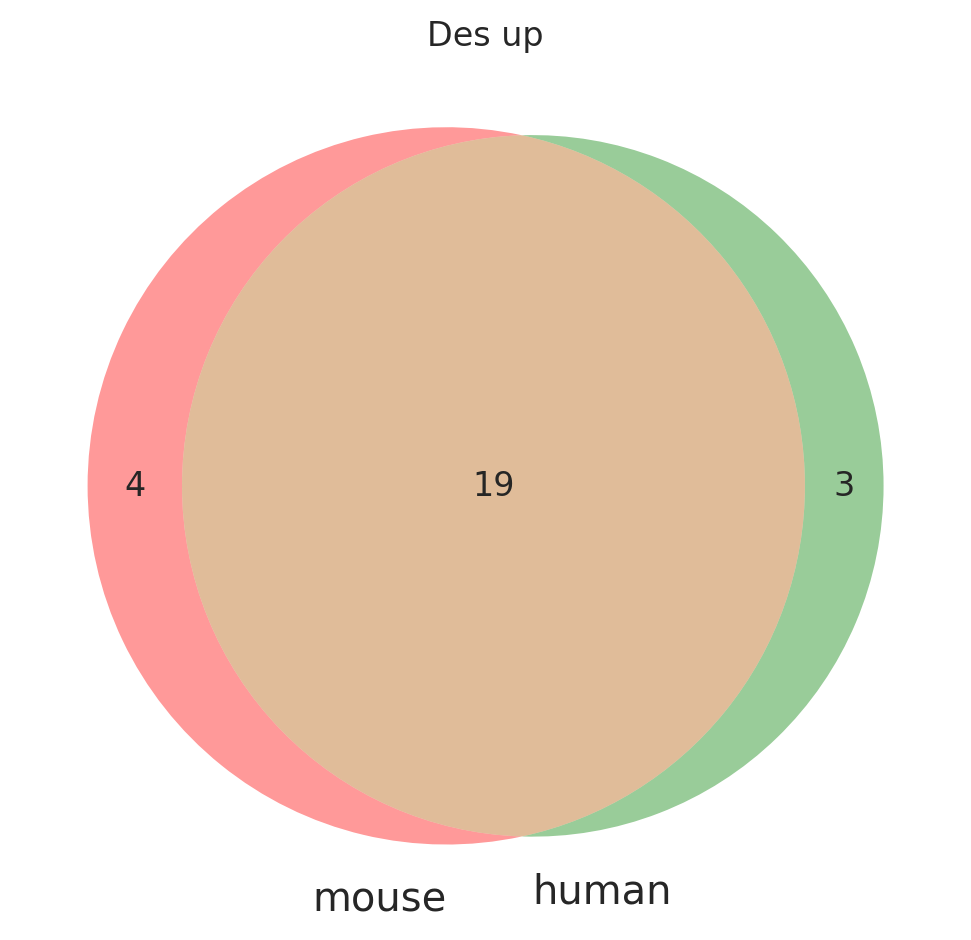

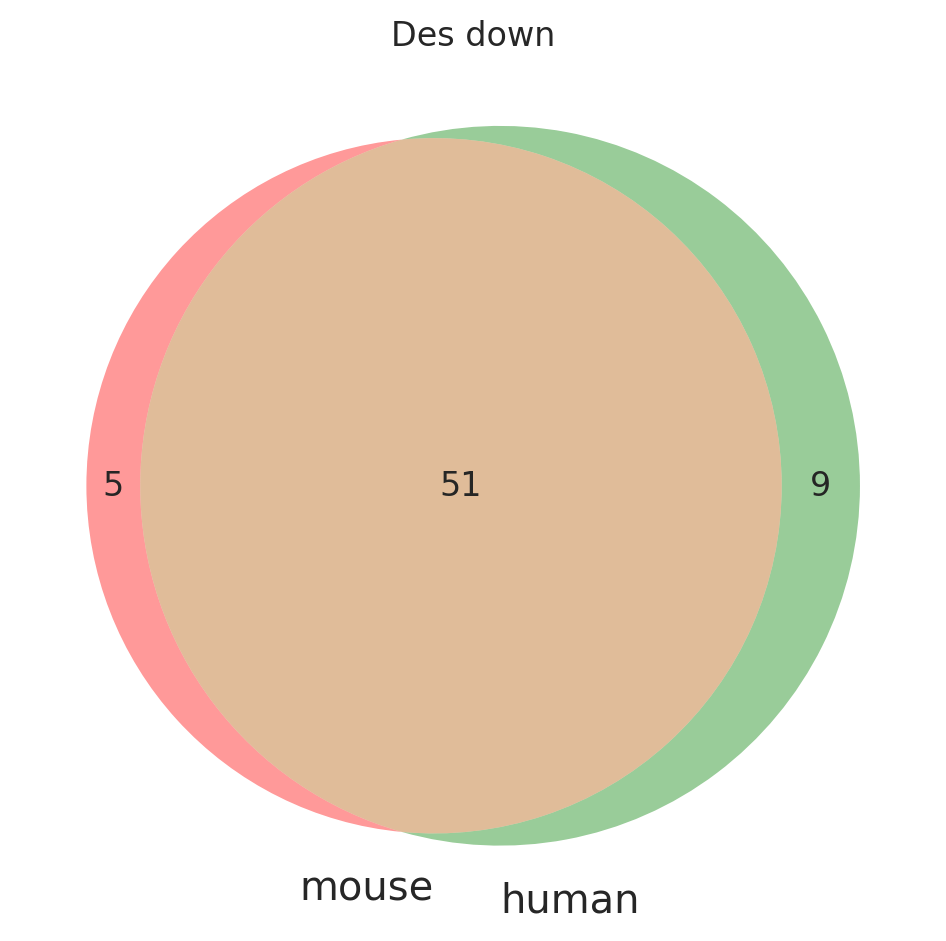

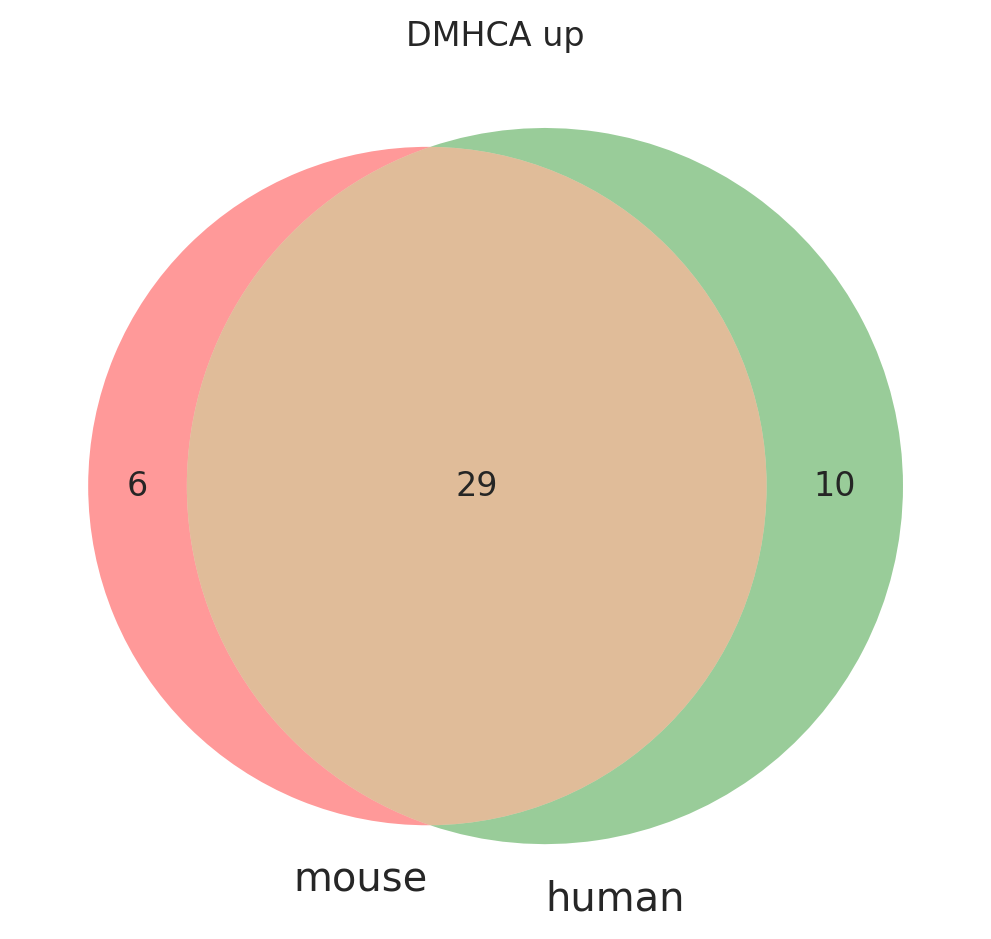

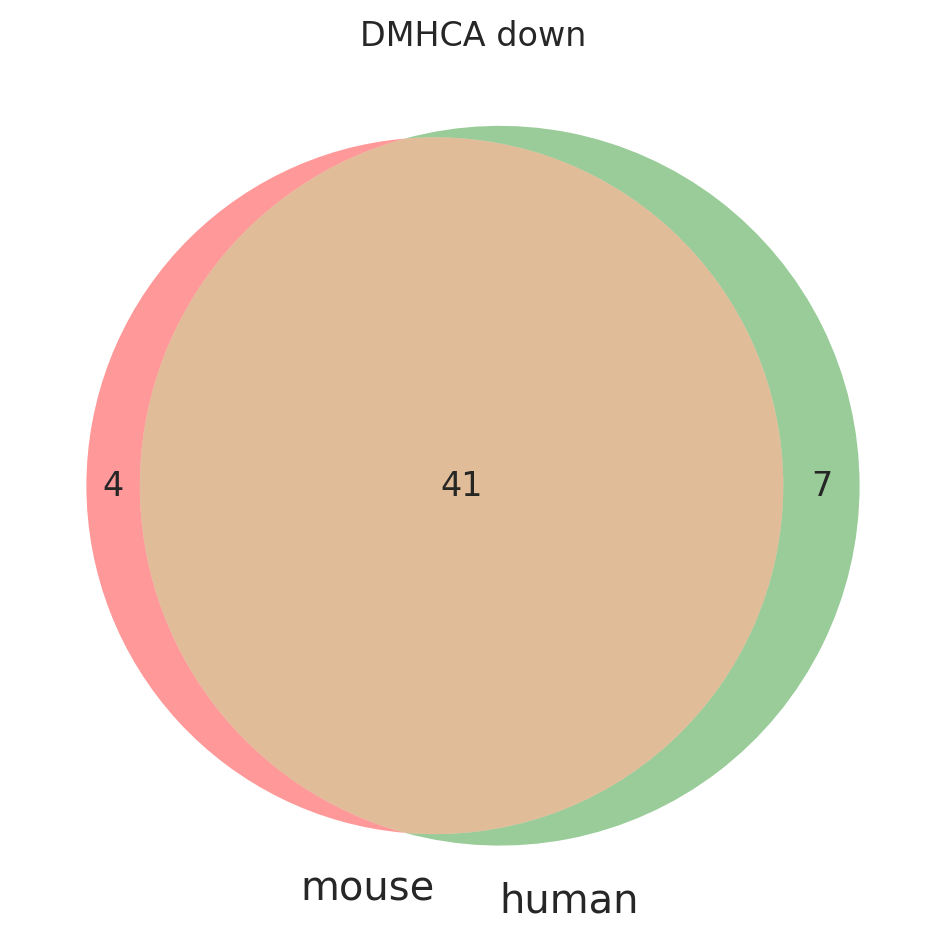

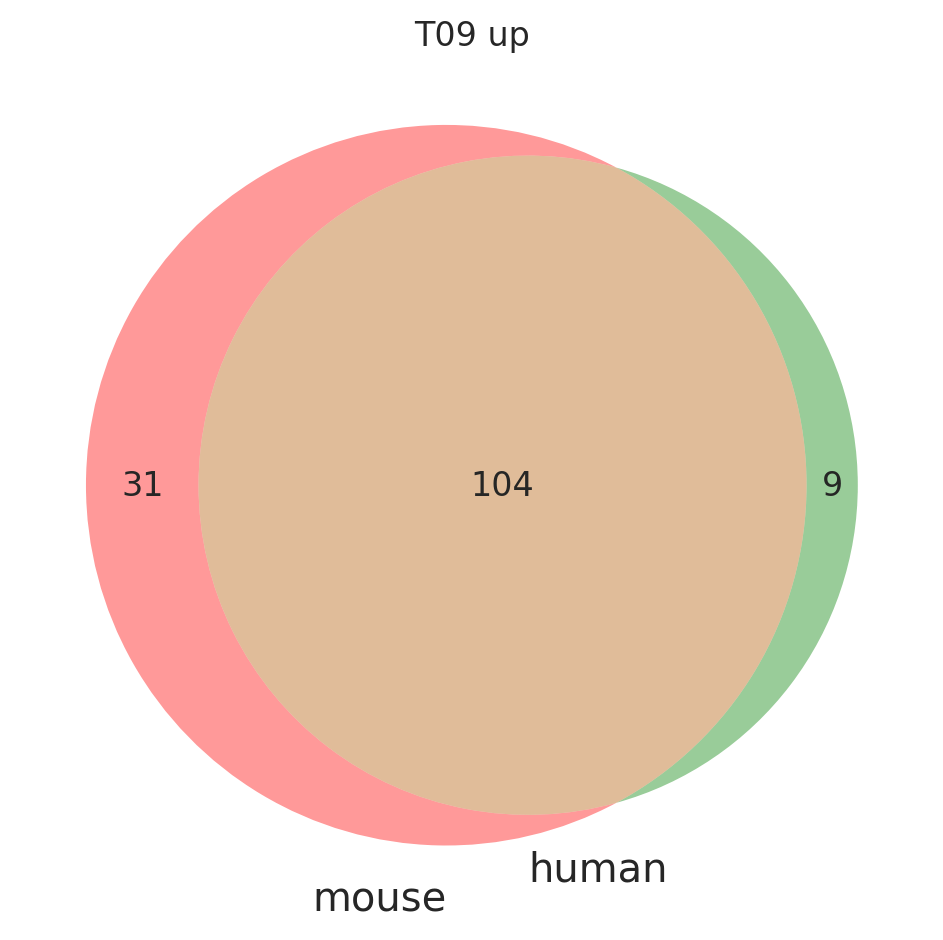

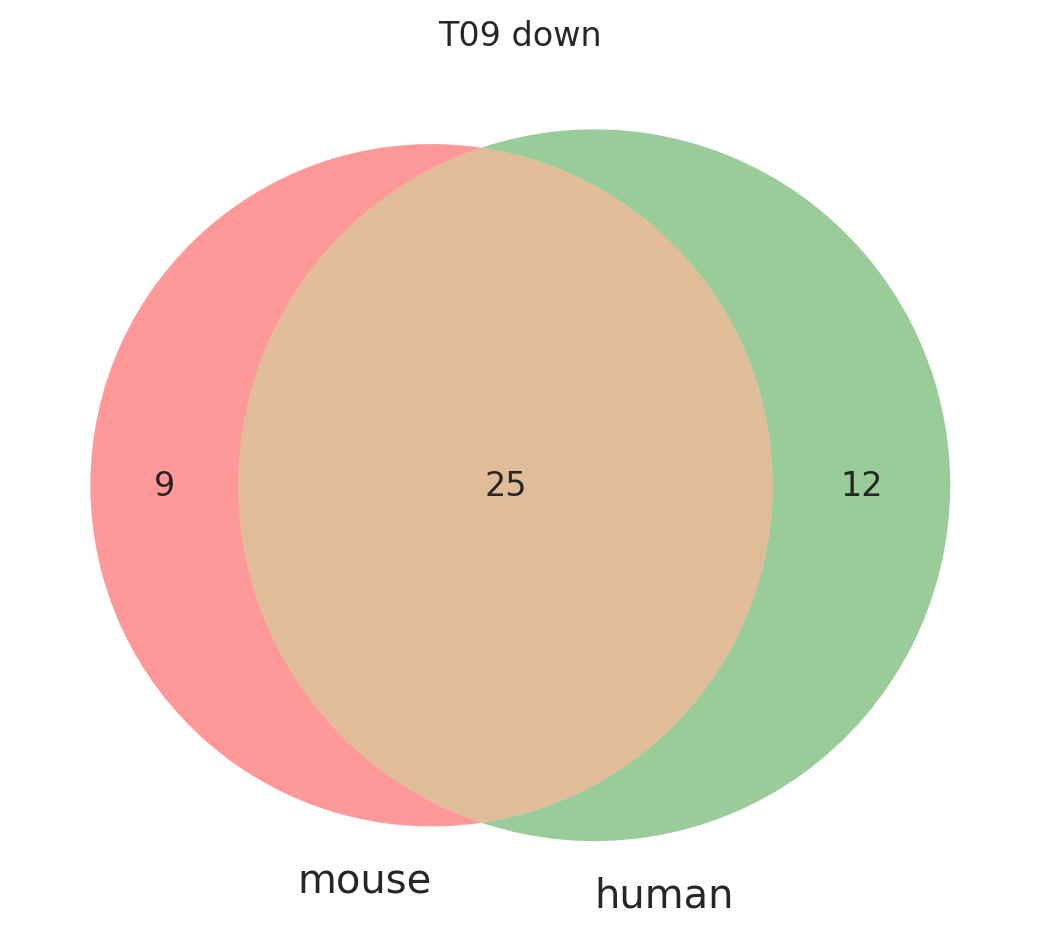

In [1612]:
for treatment in ['Des', 'DMHCA', 'T09']:
    for direction in ['up', 'down']:
        gene_sets = [set(condition_significantGenes_dict['mouse_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes),
            set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_'+direction]).intersection(intersecting_genes)]


        mouse_specific_genes = sorted(gene_sets[0] - gene_sets[1])
        intersection_genes = sorted(gene_sets[0].intersection(gene_sets[1]))
        human_specific_genes = sorted(gene_sets[1] - gene_sets[0])

        mouse_frame = condition_significantFrame_dict['mouse_' + treatment.lower() +'_'+direction]
        human_frame = stats_frame[['gene']+[treatment + ' '+ x for x in ['Log2 FC MAD', 'Median Log2 FC', 'Wilcoxon p-value']]]
        mouse_specific_frame = mouse_frame[mouse_frame.index.isin(mouse_specific_genes)]
        intersection_frame = pd.concat([mouse_frame[mouse_frame.index.isin(intersection_genes)],
                                        human_frame[human_frame.index.isin(intersection_genes)]], axis=1)
        intersection_frame = intersection_frame.sort(treatment + ' Median Log2 FC')
        human_specific_frame = human_frame[human_frame.index.isin(human_specific_genes)]
        human_specific_frame = human_specific_frame.sort(treatment + ' Median Log2 FC')
        # write output file
        mouse_specific_frame.to_csv(treatment + '_' + direction + '_geneList.tsv', sep='\t', index=False)
        with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
            intersection_frame.to_csv(f, index=False, sep='\t')
        with open(treatment + '_' + direction + '_geneList.tsv','a') as f:
            human_specific_frame.to_csv(f, index=False, sep='\t')

        # plot venn diagram
        matplotlib_venn.venn2(gene_sets,set_labels=['mouse','human'])
        plt.title(treatment + ' ' + direction)

        plt.savefig(treatment + '_' + direction + '_vennDiagram.pdf', bbox_inches='tight')
        plt.show()


## Heatmap

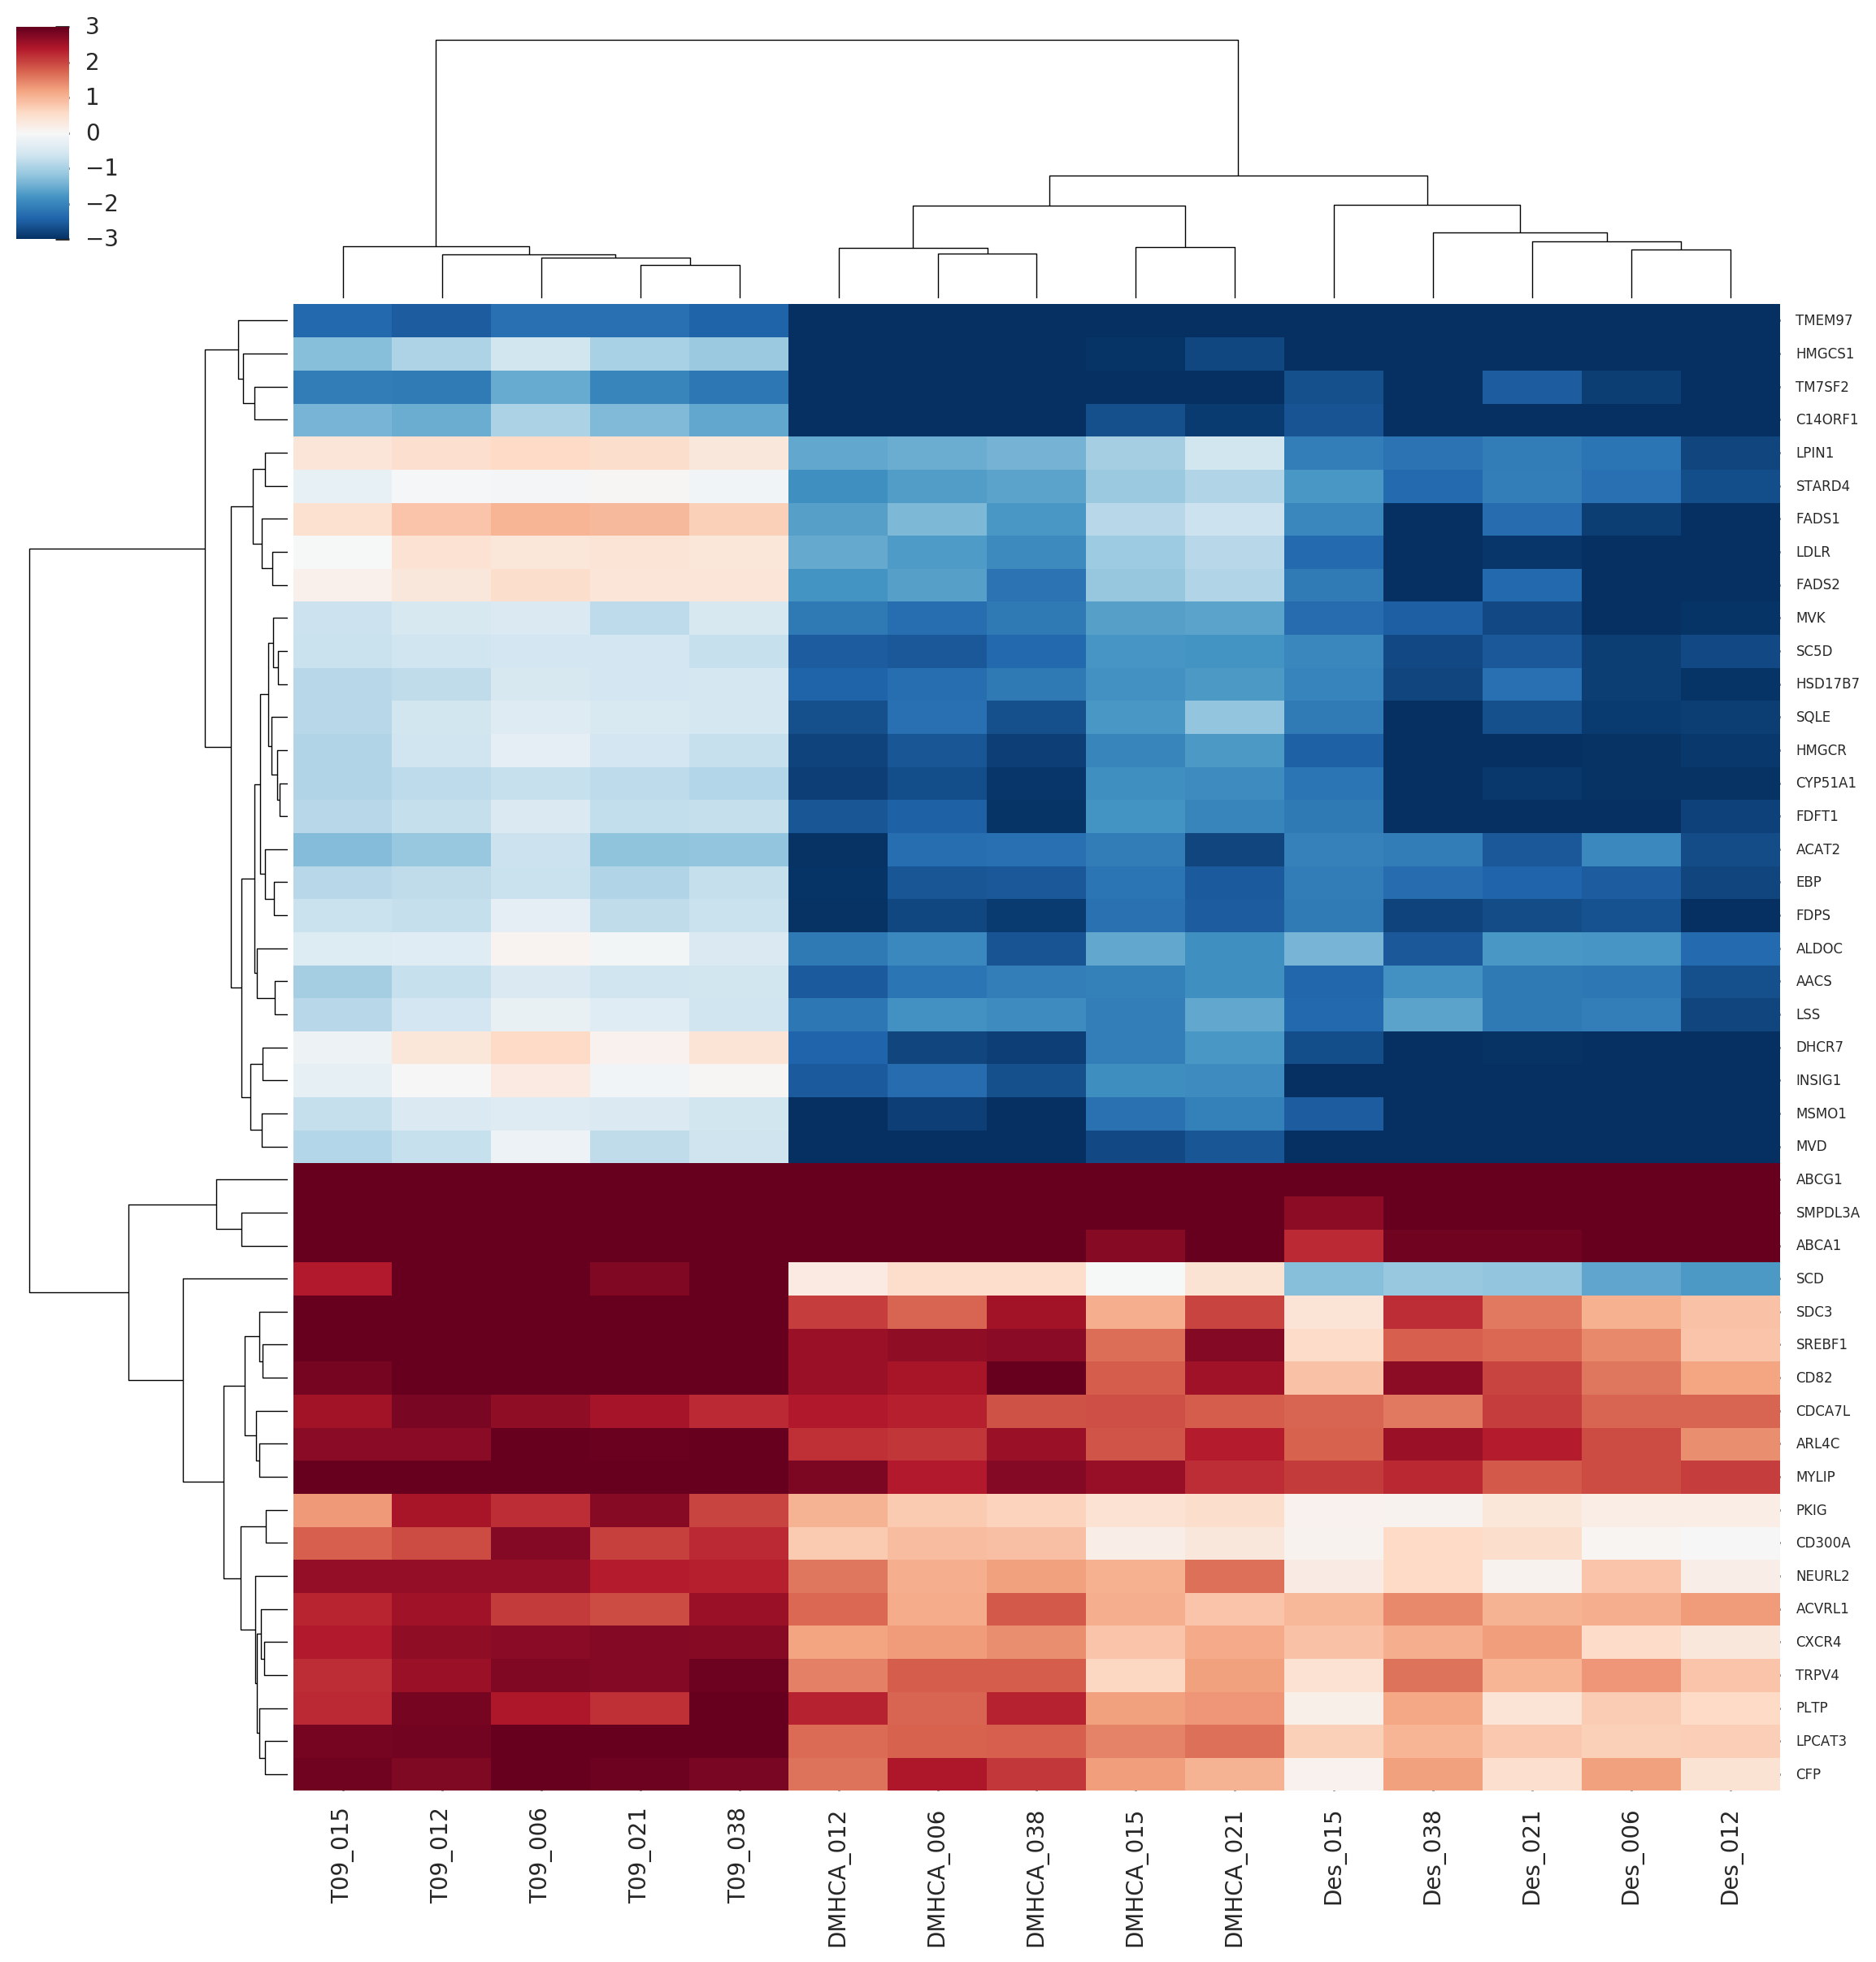

In [1610]:
fold_threshold = 2.5
for treatment in ['Des', 'DMHCA', 'T09']:
    
    human_genes_up_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_up']).intersection(intersecting_genes)
    human_genes_down_matched = set(condition_significantGenes_dict['humanMatched_' + treatment.lower() +'_down']).intersection(intersecting_genes)
    human_genes_matched = human_genes_up_matched.union(human_genes_down_matched)
    diff_genes = diff_genes.union(human_genes_matched)

data= fold_change_frame[fold_change_frame.index.isin(diff_genes)]
data = data[data.abs().max(axis=1) > fold_threshold]
with sns.axes_style('ticks',{'ytick.direction':'in', 'xtick.direction':'in'}):
    cg = sns.clustermap(data,
                        figsize=(14,14),
                        vmin=-3,
                        vmax=3)

    plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, size=6);
    plt.savefig('matched_human_heatmap.pdf',bbox_inches='tight')